In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt
    
%run model_evaluation
from read_experiments import *

from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch

import proplot as pplt
from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity
'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts(model, envs, rollouts, num_steps, seed=None, deterministic=False):
    if seed != None:
        torch.manual_seed(seed)

    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            auxiliary_preds = outputs['auxiliary_preds']

        obs, reward, done, infos = envs.step(action)
        # if (reward != 0).any():
        #     print(reward, done, infos)
        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        
        auxiliary_truths = []
        for info in infos:
            if 'auxiliary' in info:
                if len(info['auxiliary'] > 0):
                    auxiliary_truths.append(info['auxiliary'])
        if len(auxiliary_truths) > 0:
            auxiliary_truths = torch.tensor(np.vstack(auxiliary_truths))
        else:
            auxiliary_truths = None

        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks,
                        auxiliary_preds, auxiliary_truths)
        
def clone_rollouts(copy, paste, num_steps, start=0, copy_first=True):
    if copy_first:
        #Copy the first steps of storage types that need it
        paste.obs[0].copy_(copy.obs[start])
        paste.recurrent_hidden_states[0].copy_(copy.recurrent_hidden_states[start])
        paste.masks[0].copy_(copy.masks[start])
        paste.bad_masks[0].copy_(copy.bad_masks[start])
        
    for step in range(num_steps):
        obs = copy.obs[step+start+1]
        recurrent_hidden_states = copy.recurrent_hidden_states[step+start+1]
        action = copy.actions[step+start]
        action_log_prob = copy.action_log_probs[step+start]
        value = copy.value_preds[step+start]
        reward = copy.rewards[step+start]
        masks = copy.masks[step+start+1]
        bad_masks = copy.bad_masks[step+start+1]
        paste.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss



def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBase', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False, take_optimizer_step=True,
                            normalize=True):
    
    #Initialize vectorized environments
    # envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
    #                      capture_video=capture_video, env_kwargs=env_kwargs)
    
    env = gym.make('NavEnv-v0', **env_kwargs)

    if model is None:
        model = Policy(env.observation_space.shape,
                       env.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    # agent = algo.PPO(model, clip_param, ppo_epoch, num_mini_batch,
    agent = LoudPPO(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm,
                     take_optimizer_step=take_optimizer_step)

    #Initialize storage
    rollouts = RolloutStorage(num_steps, num_processes, env.observation_space.shape, env.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_size)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)
    
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)
    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    
    if normalize:
        vec_norm = utils.get_vec_normalize(envs)
        if vec_norm is not None and obs_rms is not None:
            vec_norm.obs_rms = obs_rms

        
    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts



def collect_batches_and_grads(agent, envs, rollouts, num_batches=1, seed=None, num_layers=None,
                             decompose_grads=False):
    rewarded = []
    value_losses = []
    action_losses = []
    num_rewards = []
    value_diffs = []

    params = list(agent.actor_critic.base.parameters())
    if num_layers == None:
        num_layers = len(list(params))

    if decompose_grads:
        grad_types = ['value', 'action', 'auxiliary', 'entropy']
        all_grads = {name: [] for name in grad_types}
        for name in grad_types:
            for i in range(num_layers):
                all_grads[name].append([])
    else:
        all_grads = []
        for i in range(num_layers):
            all_grads.append([])
        
    
    for n in range(num_batches):
        populate_rollouts(agent.actor_critic, envs, rollouts, rollouts.num_steps, seed=seed)
        
        agent.optimizer.zero_grad()
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                     rollouts.masks[-1]).detach()
        rollouts.compute_returns(next_value, False, 0.99, 0.95)
        
        
        if decompose_grads:
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss, \
                grads = agent.update(rollouts)
            
            for name in grad_types:
                for i in range(num_layers):
                    all_grads[name][i].append(grads[name][i])
        else:
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)

            for i in range(num_layers):
                all_grads[i].append(params[i].grad.clone())
            
        rew = rollouts.rewards
        rewarded.append((rew != 0).any().item())
        num_rewards.append(len(rew[rew != 0]))
        value_losses.append(value_loss)
        action_losses.append(action_loss)
        
        value_diff = torch.sum(rollouts.returns - rollouts.value_preds)
        value_diffs.append(value_diff.item())
        rollouts.after_update()
    
    return {
        'all_grads': all_grads,
        'rewarded': rewarded,
        'value_losses': value_losses,
        'action_losses': action_losses,
        'rewards': num_rewards,
        'value_diff': value_diffs
    }



def aux_cos_sims_from_all_grads(all_grads, use_layer_subset=True, actor_layer_subset=False,
                                pairwise=False):
    """From an all_grads object which has auxiliary and RL grads,
    compute the cosine similarities between the gradients 

    Args:
        all_grads (dict): Dictionary of gradients to be used
        use_layer_subset (bool, optional): If set to True, only compute gradients
            for specific layers affected by auxiliary gradient. Will assume these are the
            actor layer by default, but switch to critic layer if the auxiliary task
            key ends in a c (e.g., all_grad['goaldistc']). Defaults to True.
        actor_layer_subset (bool, optional): Used for if we are not indexing the all_grads
            dict by auxiliary task (e.g., indexing by trial). If this is True, force use
            of actor test layers for comparisons (if use_layer_subset is True)
        pairwise (bool, optional): If set to True, compute the pairwise cosine similarities
            between gradients for each batch to each other. Otherwise, only compute cosine
            similarity for aux and RL gradients coming from the same batch. Defaults to False.

    Returns:
        dict: Results with 'x', 'y' (cos_sim means), 'std', 'low' (12.5 percentile), 
            'high' (87.5 percentile), 'c' (colors)
            Each dict entry will be a list of lists. The list indexes by [aux][batch]
            e.g., y[0][3] will give the mean cos_sims for aux_tasks[0] ('goaldist') and
                3rd batch
    """

    num_layers = 16
    
    # Colors to assign to auxiliary tasks (they will be assigned in order)
    colors = pplt.Cycle('default').by_key()['color']
    hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

    
    # Assume the first iteration of all_grads is a dict
    all_xs = []
    all_ys = []
    all_lows = []
    all_highs = []
    all_stds = []
    all_cs = []
    
    for n, key in enumerate(all_grads):
        xs = []
        ys = []
        lows = []
        stds = []
        highs = []
        colors = []
        
        # Next layer of all_grads may be dict or list
        if type(all_grads[key]) == dict:
            grads = [all_grads[key][key2] for key2 in all_grads[key]]
        elif type(all_grads[key]) == list:
            grads = all_grads[key]
        
        if use_layer_subset:
            if type(key) == str and key[-1] == 'c':
                # Auxiliary head placed on critic side
                layers = [0, 1, 4, 8]
            else:
                # Auxiliary head place on actor side
                layers = [0, 1, 6, 10]
        else:
            layers = range(num_layers)
                
        for x, grad in enumerate(grads):
            cos_sims = []
            
            for i in layers:
                # Combine gradients and calculate cosine similarities
                value_grad = torch.vstack([g.reshape(-1) for g in grad['value'][i]])
                action_grad = torch.vstack([g.reshape(-1) for g in grad['action'][i]])
                entropy_grad = torch.vstack([g.reshape(-1) for g in grad['entropy'][i]])
                aux_grad = torch.vstack([g.reshape(-1) for g in grad['auxiliary'][i]])
                cumu_grad = value_grad + action_grad + entropy_grad
                
                if pairwise:
                    # If pairwise is True, compare every batch to every other batch gradient
                    cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
                    cs = cs[cs != 0]
                    cos_sims += list(cs)
                else:
                    # Otherwise only compare each gradient to its counterpart in the same batch
                    for j in range(len(cumu_grad)):
                        cs = cosine_similarity(cumu_grad[j].reshape(1, -1),
                                               aux_grad[j].reshape(1, -1))
                        cos_sims += list(cs)
            
            xs.append(x)
            ys.append(np.mean(cos_sims))
            stds.append(np.std(cos_sims))
            lows.append(np.percentile(cos_sims, 12.5))
            highs.append(np.percentile(cos_sims, 87.5))
            colors.append(rgb_colors[n])
            
        all_xs.append(xs)
        all_ys.append(ys)
        all_stds.append(stds)
        all_lows.append(lows)
        all_highs.append(highs)
        all_cs.append(colors)
        
    return {
        'x': all_xs,
        'y': all_ys,
        'std': all_stds,
        'low': all_lows,
        'high': all_highs,
        'c': all_cs
    }
            
            
            

C:\Users\14and\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
[param.shape for param in (agent.actor_critic.parameters())]

[torch.Size([48, 24]),
 torch.Size([48, 16]),
 torch.Size([48]),
 torch.Size([48]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([16, 16]),
 torch.Size([16]),
 torch.Size([1, 16]),
 torch.Size([1]),
 torch.Size([4, 16]),
 torch.Size([4])]

In [2]:
class LoudPPO():
    '''
    Variation on our trainer object that allows for printing of 
    some debugging information and more importantly allows us to compute
    gradients without taking the actual update step to network weights
    '''
    def __init__(self,
                 actor_critic,
                 clip_param,
                 ppo_epoch,
                 num_mini_batch,
                 value_loss_coef,
                 entropy_coef,
                 auxiliary_loss_coef=0,
                 lr=None,
                 eps=None,
                 max_grad_norm=None,
                 use_clipped_value_loss=True,
                 verbose=False,
                 take_optimizer_step=True):

        self.actor_critic = actor_critic

        self.clip_param = clip_param
        self.ppo_epoch = ppo_epoch
        self.num_mini_batch = num_mini_batch

        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.auxiliary_loss_coef = auxiliary_loss_coef

        self.max_grad_norm = max_grad_norm
        self.use_clipped_value_loss = use_clipped_value_loss

        self.optimizer = optim.Adam(actor_critic.parameters(), lr=lr, eps=eps)
        
        #Additional parameter that allows us to skip taking optimizer step so that
        #we can keep trajectories same for different batch sizes
        self.take_optimizer_step = take_optimizer_step
        self.verbose = verbose

    def update(self, rollouts):
        advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0
        auxiliary_loss_epoch = 0

        clipfracs = []
        explained_vars = []
        
        num_update_steps = 0
        for e in range(self.ppo_epoch):
            if self.actor_critic.is_recurrent:
                data_generator = rollouts.recurrent_generator(
                    advantages, self.num_mini_batch)
            else:
                data_generator = rollouts.feed_forward_generator(
                    advantages, self.num_mini_batch)

            for sample in data_generator:
                num_update_steps += 1
                if self.verbose:
                    print(num_update_steps)
                obs_batch, recurrent_hidden_states_batch, actions_batch, \
                   value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                    adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

                # Reshape to do in a single forward pass for all steps
                values, action_log_probs, dist_entropy, _, auxiliary_preds = self.actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

                logratio = action_log_probs - old_action_log_probs_batch 
                ratio = torch.exp(logratio)
                surr1 = ratio * adv_targ
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv_targ
                action_loss = -torch.min(surr1, surr2).mean()

                #Andy: compute approx kl
                with torch.no_grad():
                    # old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [
                        ((ratio - 1.0).abs() > self.clip_param).float().mean().item()
                    ]

                if self.use_clipped_value_loss:
                    value_pred_clipped = value_preds_batch + \
                        (values - value_preds_batch).clamp(-self.clip_param, self.clip_param)
                    value_losses = (values - return_batch).pow(2)
                    value_losses_clipped = (
                        value_pred_clipped - return_batch).pow(2)
                    value_loss = 0.5 * torch.max(value_losses,
                                                 value_losses_clipped).mean()
                else:
                    value_loss = 0.5 * (return_batch - values).pow(2).mean()
                
                if self.actor_critic.has_auxiliary:
                    auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()
                else:
                    auxiliary_loss = torch.zeros(1)
                # print(auxiliary_truth_batch, auxiliary_preds, auxiliary_loss)


                self.optimizer.zero_grad()
                (value_loss * self.value_loss_coef + action_loss + 
                 auxiliary_loss * self.auxiliary_loss_coef -
                 dist_entropy * self.entropy_coef).backward()
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(),
                                         self.max_grad_norm)
                if self.take_optimizer_step:
                    self.optimizer.step()

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
                auxiliary_loss_epoch += auxiliary_loss.item()

        num_updates = self.ppo_epoch * self.num_mini_batch

        value_loss_epoch /= num_updates
        action_loss_epoch /= num_updates
        dist_entropy_epoch /= num_updates



        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, \
            approx_kl, clipfracs, auxiliary_loss_epoch

    
    
class DecomposeGradPPO():
    '''
    Variation on our trainer object that further keeps track of grads induced
    by each individual loss and returns them on the update function
    Note this is going to assume that we only have one single ppo_epoch and one
    minibatch 
    '''
    def __init__(self,
                 actor_critic,
                 clip_param,
                 ppo_epoch,
                 num_mini_batch,
                 value_loss_coef,
                 entropy_coef,
                 auxiliary_loss_coef=0,
                 lr=None,
                 eps=None,
                 max_grad_norm=None,
                 use_clipped_value_loss=True,
                 verbose=False,
                 take_optimizer_step=True):

        self.actor_critic = actor_critic

        self.clip_param = clip_param
        self.ppo_epoch = ppo_epoch
        self.num_mini_batch = num_mini_batch

        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.auxiliary_loss_coef = auxiliary_loss_coef

        self.max_grad_norm = max_grad_norm
        self.use_clipped_value_loss = use_clipped_value_loss

        self.optimizer = optim.Adam(actor_critic.parameters(), lr=lr, eps=eps)
        
        #Additional parameter that allows us to skip taking optimizer step so that
        #we can keep trajectories same for different batch sizes
        self.take_optimizer_step = take_optimizer_step
        self.verbose = verbose

    def update(self, rollouts):
        advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0
        auxiliary_loss_epoch = 0

        clipfracs = []
        explained_vars = []
        
        num_update_steps = 0
        for e in range(self.ppo_epoch):
            if self.actor_critic.is_recurrent:
                data_generator = rollouts.recurrent_generator(
                    advantages, self.num_mini_batch)
            else:
                data_generator = rollouts.feed_forward_generator(
                    advantages, self.num_mini_batch)

            for sample in data_generator:
                num_update_steps += 1
                if self.verbose:
                    print(num_update_steps)
                obs_batch, recurrent_hidden_states_batch, actions_batch, \
                   value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                    adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

                # Reshape to do in a single forward pass for all steps
                values, action_log_probs, dist_entropy, _, auxiliary_preds = self.actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

                logratio = action_log_probs - old_action_log_probs_batch 
                ratio = torch.exp(logratio)
                surr1 = ratio * adv_targ
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv_targ
                action_loss = -torch.min(surr1, surr2).mean()

                #Andy: compute approx kl
                with torch.no_grad():
                    # old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [
                        ((ratio - 1.0).abs() > self.clip_param).float().mean().item()
                    ]

                if self.use_clipped_value_loss:
                    value_pred_clipped = value_preds_batch + \
                        (values - value_preds_batch).clamp(-self.clip_param, self.clip_param)
                    value_losses = (values - return_batch).pow(2)
                    value_losses_clipped = (
                        value_pred_clipped - return_batch).pow(2)
                    value_loss = 0.5 * torch.max(value_losses,
                                                 value_losses_clipped).mean()
                else:
                    value_loss = 0.5 * (return_batch - values).pow(2).mean()
                
                if self.actor_critic.has_auxiliary:
                    auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()
                else:
                    auxiliary_loss = torch.zeros(1)
                # print(auxiliary_truth_batch, auxiliary_preds, auxiliary_loss)


                # (value_loss * self.value_loss_coef + action_loss + 
                #  auxiliary_loss * self.auxiliary_loss_coef -
                #  dist_entropy * self.entropy_coef).backward()             
                params = list(self.actor_critic.parameters())
                num_param_layers = len(params)

                loss_names = ['value', 'action', 'auxiliary', 'entropy']
                losses = [
                    value_loss*self.value_loss_coef,
                    action_loss,
                    auxiliary_loss*self.auxiliary_loss_coef,
                    -dist_entropy
                ]
                grads = defaultdict(list)
                
                for i, loss in enumerate(losses):
                    name = loss_names[i]
                    self.optimizer.zero_grad()
                    if loss.grad_fn != None:
                        loss.backward(retain_graph=True)
                    for param in params:
                        if param.grad == None:
                            grad = torch.zeros(param.shape)
                        else:
                            grad = param.grad.clone()
                        grads[name].append(grad)
                                
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(),
                                         self.max_grad_norm)
                if self.take_optimizer_step:
                    self.optimizer.step()

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
                auxiliary_loss_epoch += auxiliary_loss.item()

        num_updates = self.ppo_epoch * self.num_mini_batch

        value_loss_epoch /= num_updates
        action_loss_epoch /= num_updates
        dist_entropy_epoch /= num_updates



        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, \
            approx_kl, clipfracs, auxiliary_loss_epoch, grads

### Example code for creating environments and agents

In [5]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
nn_base_kwargs = {'hidden_size': 16}
agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                                num_steps=1, num_processes=8, ppo_epoch=1, num_mini_batch=1)
# rollouts.obs[0]

recurrent = True
torch.manual_seed(0)
model = Policy(envs.observation_space.shape,
               envs.action_space,
               base='FlexBase',
               base_kwargs={'recurrent': recurrent,
                   **nn_base_kwargs})

### Example code for collecting gradients

In [350]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
nn_base_kwargs = {'hidden_size': 16}

#take_optimizer_step = True
take_optimizer_step = False

# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
batch_sizes = [8, 32, 128]
# batch_sizes = [256]

# total_steps = 256*4
total_steps = 128
grads = {batch: [] for batch in batch_sizes}
rewards = {batch: [] for batch in batch_sizes}
all_obs = {batch: [] for batch in batch_sizes}
all_actions = {batch: [] for batch in batch_sizes}
all_rnn_hxs = {batch: [] for batch in batch_sizes}
all_masks = {batch: [] for batch in batch_sizes}
all_envs = {}
agents = {}
for batch in batch_sizes:
    torch.manual_seed(0)
    agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=batch, num_processes=1, ppo_epoch=1, num_mini_batch=1,
                                    take_optimizer_step=take_optimizer_step, normalize=False)
    all_envs[batch] = envs
    agents[batch] = agent
    params = list(agent.actor_critic.parameters())
    num_updates = total_steps // batch
    # num_updates = 1
    for i in tqdm(range(num_updates)):
        populate_rollouts(agent.actor_critic, envs, rollouts, batch, seed=i)
        rewards[batch].append(torch.sum(rollouts.rewards).item())
        all_obs[batch].append(rollouts.obs[:-1])
        all_actions[batch].append(rollouts.actions)
        all_rnn_hxs[batch].append(rollouts.recurrent_hidden_states[:-1])
        all_masks[batch].append(rollouts.masks[:-1])
    
        update_model(agent, rollouts)
        grads[batch].append([param.grad.clone() for param in params])
        
        
        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


# Testing Gradient Cosine Similarities

## Testing cloning rollouts

In order to make sure regardless of batch size, the agent receives the same environment information to update based on, we have to collect the steps in a larger batch rollout and clone them over to the smaller rollout. This is because the action selecting seed gets reset every new batch, so there's no way to ensure action consistency if we collect batches of different sizes.

So far
* Cloning is working
* Cloning from different start points works
* ~~Test if grads will add up properly~~ They do not in general sum to be the same

### 1 Process

In [18]:

large_num_steps = 4096
num_processes = 1
# batch = 8
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
take_optimizer_step = False

#Final object that collects cosine similarities from each set of parameters for the
#  given sub_rollout batch size
#sim_means clones trajectories from the larger batch (1024 steps) while sim_means2
#  collects new trajectories
sim_means = defaultdict(list)
sim_means2 = defaultdict(list)

overall_sims = defaultdict(list)
overall_sims2 = defaultdict(list)

batch_rewarded = defaultdict(list)

for batch in tqdm(batch_sizes):
    #Generate large storage object and sub storage
    agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=large_num_steps, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                    take_optimizer_step=take_optimizer_step, normalize=False)
    params = list(agent.actor_critic.base.parameters())
    populate_rollouts(agent.actor_critic, envs, rollouts, large_num_steps, seed=0)

    model = agent.actor_critic
    sub_rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
    copy = rollouts
    paste = sub_rollouts


    #Compute grad for full rollout set
    agent.optimizer.zero_grad()
    next_value = model.get_value(copy.obs[-1], copy.recurrent_hidden_states[-1],
                                 copy.masks[-1]).detach()
    copy.compute_returns(next_value, False, 0.99, 0.95)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(copy)
    large_grad = [param.grad.clone() for param in params]


    num_batches = copy.num_steps // paste.num_steps

    #Grads from copying the same trajectories as the large batch
    grad_collections = [torch.zeros(param.shape) for param in params]
    all_sub_grads = [[] for i in range(len(params))]
    grad_cos_sims = [[] for i in range(len(params))]

    #Test alternative meethod of not cloning and taking new steps each time
    #this should produce less good fits maybe?
    grad_collections2 = [torch.zeros(param.shape) for param in params]
    grad_cos_sims2 = [[] for i in range(len(params))]

    rewarded = []
    for n in range(num_batches):
        #Clone rollouts and test to ensure that they are conserved from large to small batch
        start = n * paste.num_steps
        clone_rollouts(rollouts, sub_rollouts, num_steps=batch, start=start)

        test_attrs1 = ['actions', 'action_log_probs', 'value_preds', 'rewards']
        test_attrs2 = ['obs', 'recurrent_hidden_states', 'masks', 'bad_masks'] #extra val
        num_steps = sub_rollouts.num_steps

        for attr in test_attrs1:
            val_copy = getattr(copy, attr)
            val_paste = getattr(paste, attr)
            if not ((val_copy[start:num_steps+start] - val_paste[:num_steps]) == 0).all():
                print(f'{attr} not properly copied')

        for attr in test_attrs2:
            val_copy = getattr(copy, attr)
            val_paste = getattr(paste, attr)
            if not ((val_copy[start:num_steps+1+start] - val_paste) == 0).all():
                print(f'{attr} not properly copied')


        #Perform update step to colect grads
        agent.optimizer.zero_grad()
        next_value = model.get_value(paste.obs[-1], paste.recurrent_hidden_states[-1],
                                     paste.masks[-1]).detach()
        paste.compute_returns(next_value, False, 0.99, 0.95)
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(paste)
        for i, param in enumerate(params):
            grad_collections[i] += param.grad
            all_sub_grads[i].append(param.grad.clone())
            grad_cos_sims[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
                                    large_grad[i].reshape(1, -1).numpy()))
            
        if (paste.rewards != 0).any():
            rewarded.append(True)
        else:
            rewarded.append(False)


    #Collect grads for non-cloned trajectories
    _, envs, _ = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=batch, num_processes=1, ppo_epoch=1, num_mini_batch=1,
                                    take_optimizer_step=take_optimizer_step, normalize=False)

    for n in range(num_batches):
        populate_rollouts(agent.actor_critic, envs, sub_rollouts, batch, seed=i)
        update_model(agent, sub_rollouts)

        for i, param in enumerate(params):
            grad_collections2[i] += param.grad
            grad_cos_sims2[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
                                    large_grad[i].reshape(1, -1).numpy()))
            
    #Collect all of these into summary stats indexed by [batch][layer]
    for i in range(len(grad_cos_sims)):
        sim_means[batch].append(np.mean(np.abs(grad_cos_sims[i])))
        sim_means2[batch].append(np.mean(np.abs(grad_cos_sims2[i])))

        gradlarge = large_grad[i].reshape(1, -1).numpy()
        grad1 = grad_collections[i].reshape(1, -1).numpy()
        grad2 = grad_collections2[i].reshape(1, -1).numpy()

        overall_sims[batch].append(cosine_similarity(gradlarge, grad1))
        overall_sims2[batch].append(cosine_similarity(gradlarge, grad2))



    

 10%|████████▎                                                                          | 1/10 [01:28<13:13, 88.14s/it]

KeyboardInterrupt



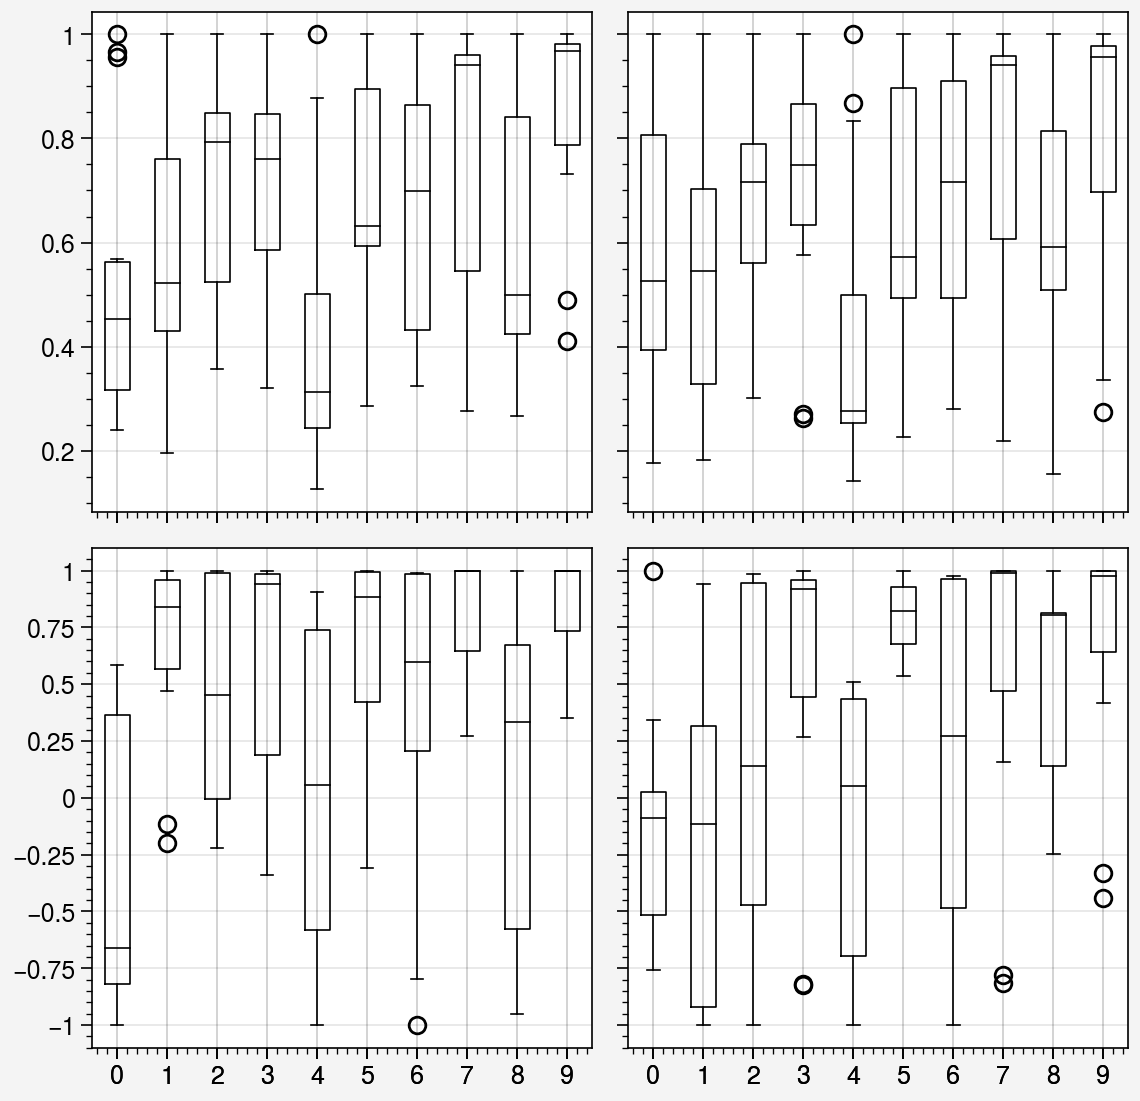

In [77]:
sim_collections = [sim_means, sim_means2, overall_sims, overall_sims2]
sim_labels = ['Individual Means (Cloned)', 'Individual Means (New Traj.)',
              'Aggregated Grad (Cloned)', 'Aggregated Grad (New Traj.)']

fig, ax = pplt.subplots(ncols=2, nrows=2, share=True)
for i, collection in enumerate(sim_collections):
    
    y = []
    for batch in batch_sizes:
        y.append(np.vstack(collection[batch]).reshape(1, -1))
    y = np.vstack(y)
    ax[i].boxplot(y.T)

### Now with more concurrent environments

Additionally, we're going to remove the new trajectory method. 

With num_processes = 8, we already see the average spread of gradient direction decreasing significantly. With num_processes = 96 as we do, it is likely that spread is very concentrated, which gives rise to consistent performance.

In [129]:

large_num_steps = 1024
num_processes = 8
# batch = 8
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
take_optimizer_step = False
seed=2
num_rollouts = 10

all_grad_cos_sims = defaultdict(list)
grad_sizes = defaultdict(list)
#Final object that collects cosine similarities from each set of parameters for the
#  given sub_rollout batch size
#sim_means clones trajectories from the larger batch (1024 steps) while sim_means2
#  collects new trajectories
sim_means = defaultdict(list)
sim_means2 = defaultdict(list)

overall_sims = defaultdict(list)
overall_sims2 = defaultdict(list)

batch_rewarded = defaultdict(list)
agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                num_steps=large_num_steps, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                take_optimizer_step=take_optimizer_step, normalize=False, seed=seed)
populate_rollouts(agent.actor_critic, envs, rollouts, large_num_steps, seed=0)
params = list(agent.actor_critic.base.parameters())
model = agent.actor_critic
copy = rollouts

# for _ in range(num_rollouts):
for batch in tqdm(batch_sizes):
# for batch in [64]:
    #Generate large storage object and sub storage

    sub_rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
    paste = sub_rollouts


    #Compute grad for full rollout set
    agent.optimizer.zero_grad()
    next_value = model.get_value(copy.obs[-1], copy.recurrent_hidden_states[-1],
                                 copy.masks[-1]).detach()
    copy.compute_returns(next_value, False, 0.99, 0.95)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(copy)
    large_grad = [param.grad.clone() for param in params]


    num_batches = copy.num_steps // paste.num_steps

    #Grads from copying the same trajectories as the large batch
    grad_collections = [torch.zeros(param.shape) for param in params]
    all_sub_grads = [[] for i in range(len(params))]
    grad_cos_sims = [[] for i in range(len(params))]

    #Test alternative meethod of not cloning and taking new steps each time
    #this should produce less good fits maybe?
    grad_collections2 = [torch.zeros(param.shape) for param in params]
    grad_cos_sims2 = [[] for i in range(len(params))]

    rewarded = []

    for n in range(num_batches):
        #Clone rollouts and test to ensure that they are conserved from large to small batch
        start = n * paste.num_steps
        clone_rollouts(rollouts, sub_rollouts, num_steps=batch, start=start)

        test_attrs1 = ['actions', 'action_log_probs', 'value_preds', 'rewards']
        test_attrs2 = ['obs', 'recurrent_hidden_states', 'masks', 'bad_masks'] #extra val
        num_steps = sub_rollouts.num_steps

        for attr in test_attrs1:
            val_copy = getattr(copy, attr)
            val_paste = getattr(paste, attr)
            if not ((val_copy[start:num_steps+start] - val_paste[:num_steps]) == 0).all():
                print(f'{attr} not properly copied')

        for attr in test_attrs2:
            val_copy = getattr(copy, attr)
            val_paste = getattr(paste, attr)
            if not ((val_copy[start:num_steps+1+start] - val_paste) == 0).all():
                print(f'{attr} not properly copied')


        #Perform update step to colect grads
        agent.optimizer.zero_grad()
        next_value = model.get_value(paste.obs[-1], paste.recurrent_hidden_states[-1],
                                     paste.masks[-1]).detach()
        paste.compute_returns(next_value, False, 0.99, 0.95)
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(paste)
        for i, param in enumerate(params):
            grad_collections[i] += param.grad
            all_sub_grads[i].append(param.grad.clone())
            grad_cos_sims[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
                                    large_grad[i].reshape(1, -1).numpy()))

        if (paste.rewards != 0).any():
            rewarded.append(True)
        else:
            rewarded.append(False)
    batch_rewarded[batch] += rewarded


    #Collect grads for non-cloned trajectories
#     _, envs, _ = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
#                                     num_steps=batch, num_processes=1, ppo_epoch=1, num_mini_batch=1,
#                                     take_optimizer_step=take_optimizer_step, normalize=False)

#     for n in range(num_batches):
#         populate_rollouts(agent.actor_critic, envs, sub_rollouts, batch, seed=i)
#         update_model(agent, sub_rollouts)

#         for i, param in enumerate(params):
#             grad_collections2[i] += param.grad
#             grad_cos_sims2[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
#                                     large_grad[i].reshape(1, -1).numpy()))
    #Compute grad sizes, indexes into [batch_size][batch_num]
    for j in range(num_batches):
        summed = 0
        for i in range(14):
            summed += torch.sum(all_sub_grads[i][j]**2).item()
        grad_size = summed ** (1/2)
        grad_sizes[batch].append(grad_size)



    #Collect all of these into summary stats indexed by [batch][layer]
    all_grad_cos_sims[batch] += grad_cos_sims
    for i in range(len(grad_cos_sims)):
        sim_means[batch].append(np.mean(np.abs(grad_cos_sims[i])))
        # sim_means[batch].append(np.mean(grad_cos_sims[i]))
        # sim_means2[batch].append(np.mean(np.abs(grad_cos_sims2[i])))

        gradlarge = large_grad[i].reshape(1, -1).numpy()
        grad1 = grad_collections[i].reshape(1, -1).numpy()
        # grad2 = grad_collections2[i].reshape(1, -1).numpy()

        overall_sims[batch].append(cosine_similarity(gradlarge, grad1))
        # overall_sims2[batch].append(cosine_similarity(gradlarge, grad2))



    

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.63s/it]


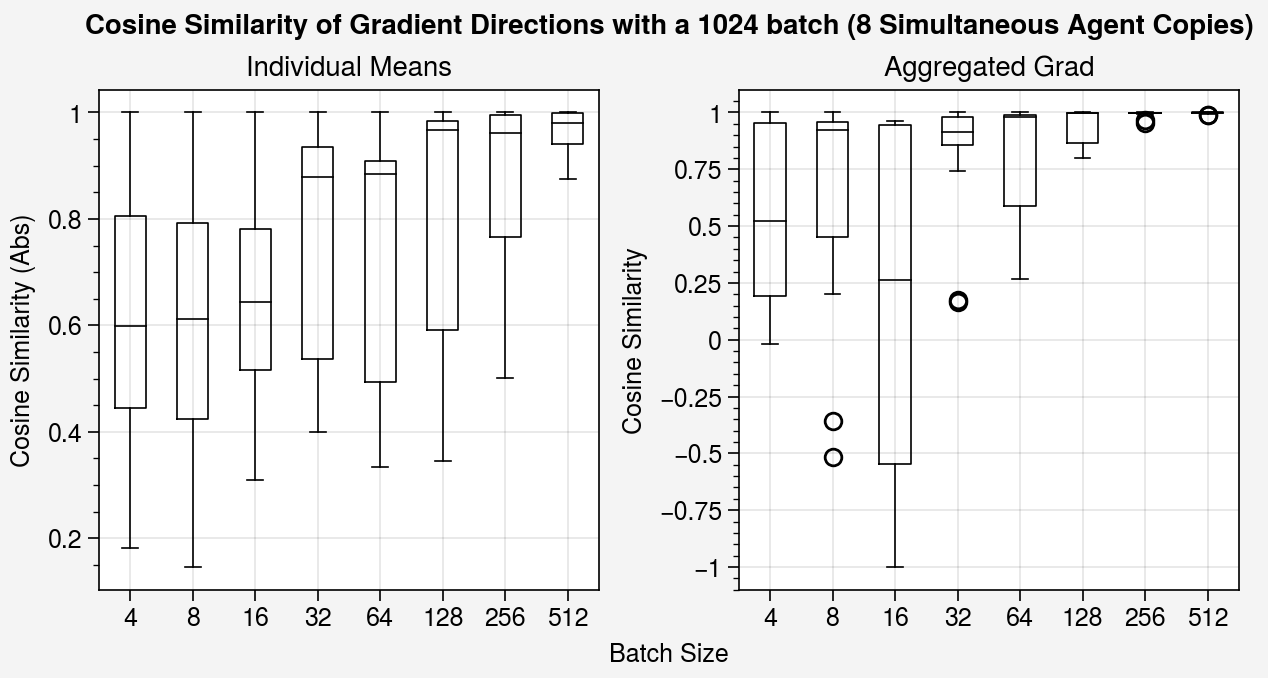

In [88]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)
for i, collection in enumerate(sim_collections):
    
    y = []
    for batch in batch_sizes:
        y.append(np.vstack(collection[batch]).reshape(1, -1))
    y = np.vstack(y)
    ax[i].boxplot(y.T)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (8 Simultaneous Agent Copies)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


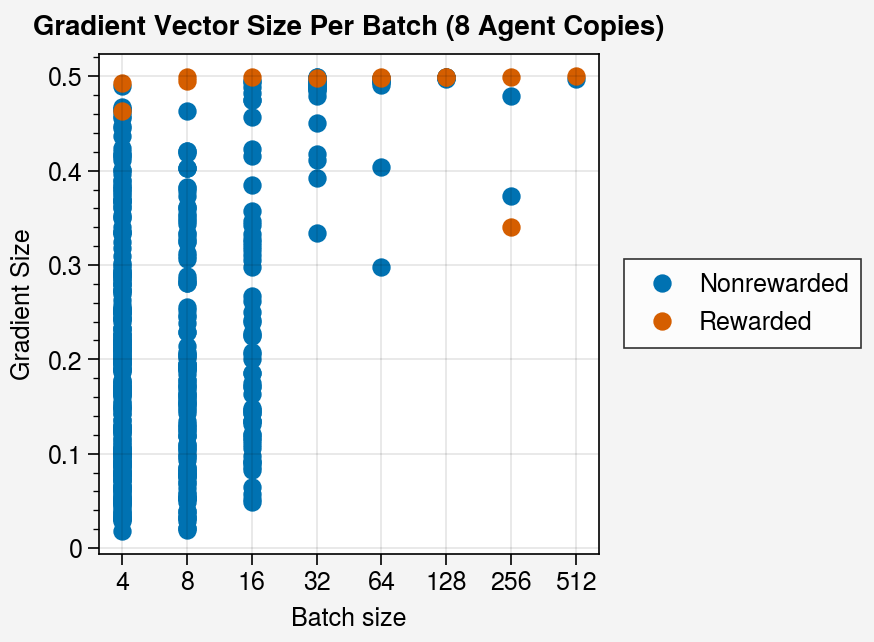

In [120]:
x1, y1, x2, y2 = [], [], [], []
for i, batch in enumerate(batch_sizes):
    grad_size = np.array(grad_sizes[batch])
    rewarded = np.array(batch_rewarded[batch])
    
    for size in grad_size[~rewarded]:
        x1.append(i)
        y1.append(size)
    for size in grad_size[rewarded]:
        x2.append(i)
        y2.append(size)
    
fig, ax = pplt.subplots()
ax.scatter(x1, y1, label='Nonrewarded')
ax.scatter(x2, y2, label='Rewarded')
fig.legend(ncols=1)
# ax.format(xlocator='log', xlim=(0, 600), xminorlocator='logminor')
ax.format(xlocator=np.arange(10), xticklabels=[str(w) for w in batch_sizes], xlabel='Batch size',
          ylabel='Gradient Size', suptitle='Gradient Vector Size Per Batch (8 Agent Copies)')

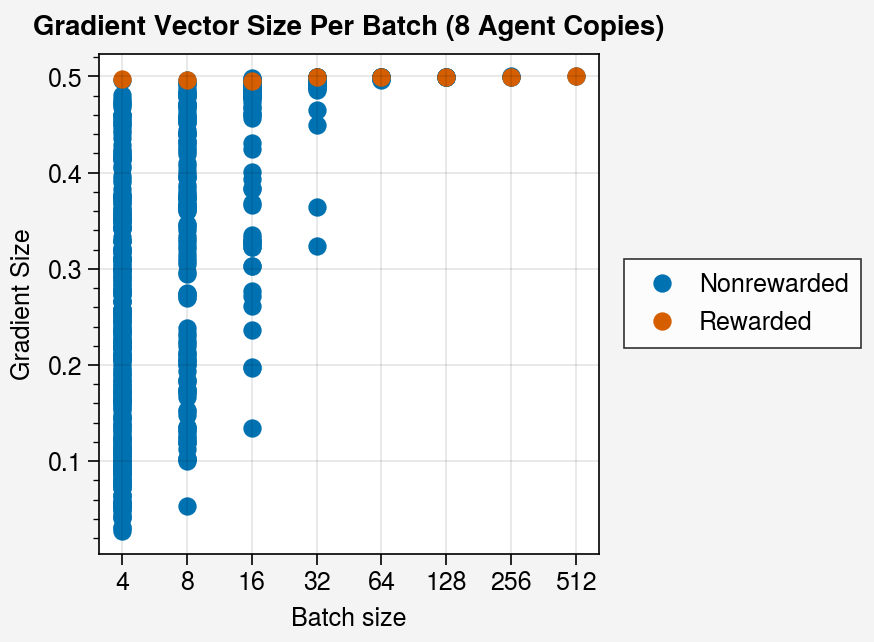

In [127]:
x1, y1, x2, y2 = [], [], [], []
for i, batch in enumerate(batch_sizes):
    grad_size = np.array(grad_sizes[batch])
    rewarded = np.array(batch_rewarded[batch])
    
    for size in grad_size[~rewarded]:
        x1.append(i)
        y1.append(size)
    for size in grad_size[rewarded]:
        x2.append(i)
        y2.append(size)
    
fig, ax = pplt.subplots()
ax.scatter(x1, y1, label='Nonrewarded')
ax.scatter(x2, y2, label='Rewarded')
fig.legend(ncols=1)
# ax.format(xlocator='log', xlim=(0, 600), xminorlocator='logminor')
ax.format(xlocator=np.arange(10), xticklabels=[str(w) for w in batch_sizes], xlabel='Batch size',
          ylabel='Gradient Size', suptitle='Gradient Vector Size Per Batch (8 Agent Copies)')

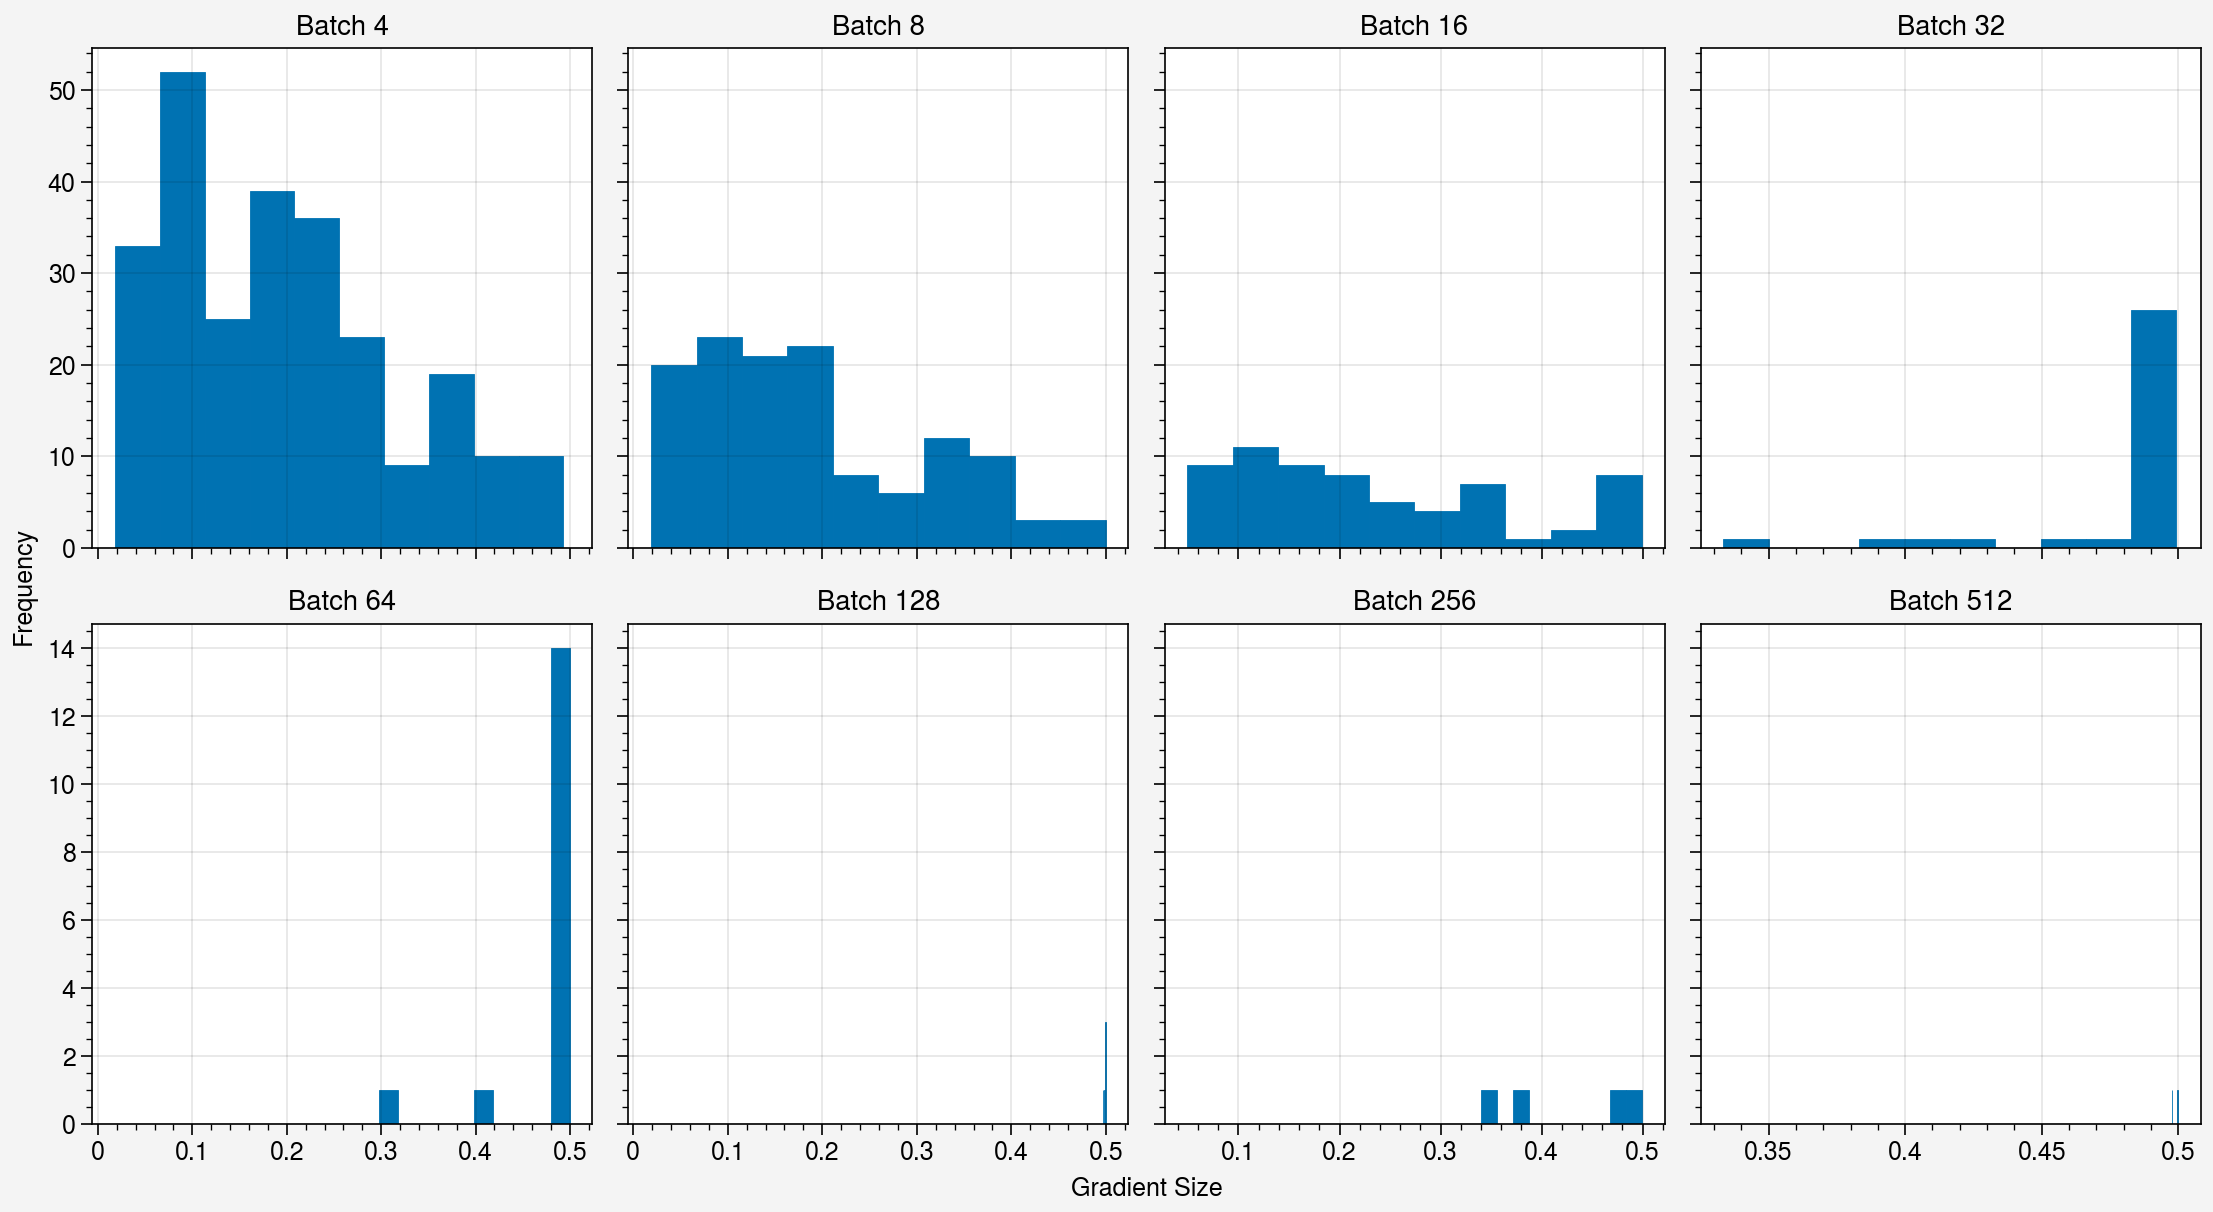

In [121]:
fig, ax = pplt.subplots(nrows=2, ncols=4)
for i, batch in enumerate(batch_sizes):
    ax[i].hist(grad_sizes[batch])
    
ax.format(title=[f'Batch {batch}' for batch in batch_sizes], xlabel='Gradient Size', ylabel='Frequency')

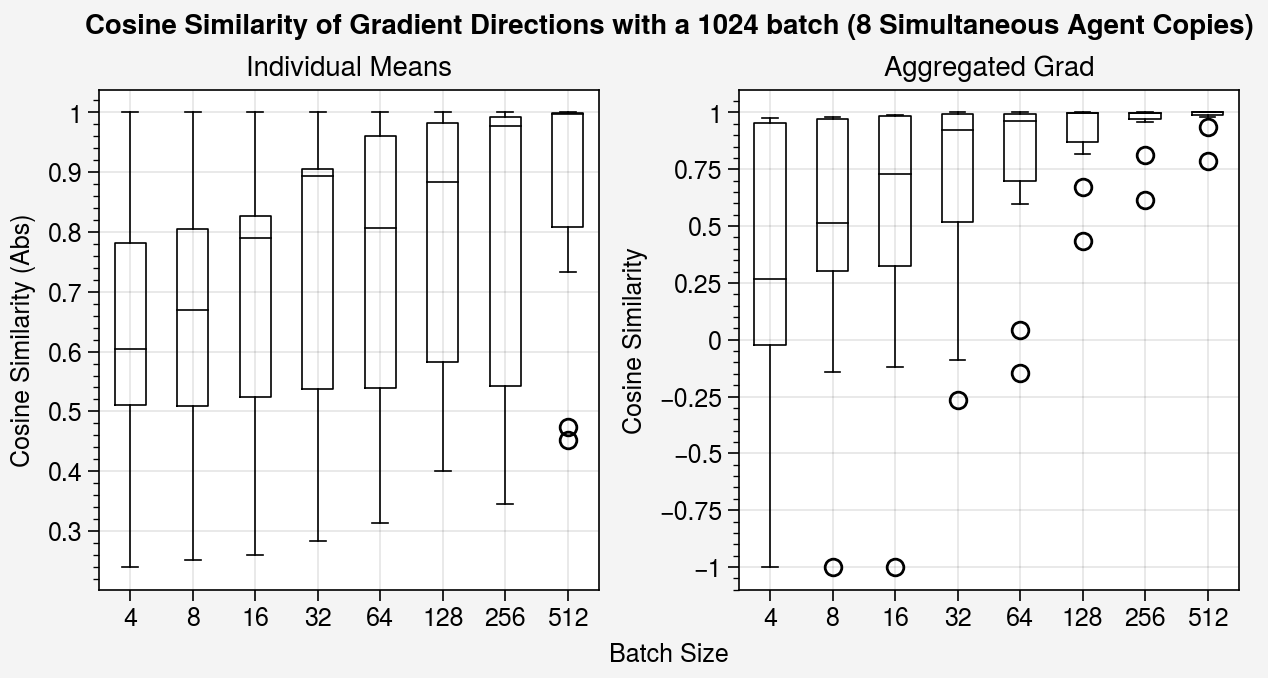

In [126]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)
for i, collection in enumerate(sim_collections):
    
    y = []
    for batch in batch_sizes:
        y.append(np.vstack(collection[batch]).reshape(1, -1))
    y = np.vstack(y)
    ax[i].boxplot(y.T)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (8 Simultaneous Agent Copies)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


### Adjusting batch code to collect multiple large batches

In [133]:

large_num_steps = 1024
num_processes = 8
# batch = 8
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
take_optimizer_step = False
seed=2
num_rollouts = 10

all_grad_cos_sims = defaultdict(list)
grad_sizes = defaultdict(list)
#Final object that collects cosine similarities from each set of parameters for the
#  given sub_rollout batch size
#sim_means clones trajectories from the larger batch (1024 steps) while sim_means2
#  collects new trajectories
sim_means = defaultdict(list)

overall_sims = defaultdict(list)

batch_rewarded = defaultdict(list)

for batch in batch_sizes:
    for i in range(14):
        sim_means[batch].append([])
        overall_sims[batch].append([])


agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                num_steps=large_num_steps, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                take_optimizer_step=take_optimizer_step, normalize=False, seed=seed)
params = list(agent.actor_critic.base.parameters())
model = agent.actor_critic
copy = rollouts

for _ in tqdm(range(num_rollouts)):
    populate_rollouts(agent.actor_critic, envs, rollouts, large_num_steps, seed=0)
    for batch in batch_sizes:
    # for batch in [64]:
        #Generate large storage object and sub storage

        sub_rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                      model.recurrent_hidden_state_size, model.auxiliary_output_size)
        paste = sub_rollouts


        #Compute grad for full rollout set
        agent.optimizer.zero_grad()
        next_value = model.get_value(copy.obs[-1], copy.recurrent_hidden_states[-1],
                                     copy.masks[-1]).detach()
        copy.compute_returns(next_value, False, 0.99, 0.95)
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(copy)
        large_grad = [param.grad.clone() for param in params]


        num_batches = copy.num_steps // paste.num_steps

        #Grads from copying the same trajectories as the large batch
        grad_collections = [torch.zeros(param.shape) for param in params]
        all_sub_grads = [[] for i in range(len(params))]
        grad_cos_sims = [[] for i in range(len(params))]

        #Test alternative meethod of not cloning and taking new steps each time
        #this should produce less good fits maybe?
        grad_collections2 = [torch.zeros(param.shape) for param in params]
        grad_cos_sims2 = [[] for i in range(len(params))]

        rewarded = []

        for n in range(num_batches):
            #Clone rollouts and test to ensure that they are conserved from large to small batch
            start = n * paste.num_steps
            clone_rollouts(rollouts, sub_rollouts, num_steps=batch, start=start)

            test_attrs1 = ['actions', 'action_log_probs', 'value_preds', 'rewards']
            test_attrs2 = ['obs', 'recurrent_hidden_states', 'masks', 'bad_masks'] #extra val
            num_steps = sub_rollouts.num_steps

            for attr in test_attrs1:
                val_copy = getattr(copy, attr)
                val_paste = getattr(paste, attr)
                if not ((val_copy[start:num_steps+start] - val_paste[:num_steps]) == 0).all():
                    print(f'{attr} not properly copied')

            for attr in test_attrs2:
                val_copy = getattr(copy, attr)
                val_paste = getattr(paste, attr)
                if not ((val_copy[start:num_steps+1+start] - val_paste) == 0).all():
                    print(f'{attr} not properly copied')


            #Perform update step to colect grads
            agent.optimizer.zero_grad()
            next_value = model.get_value(paste.obs[-1], paste.recurrent_hidden_states[-1],
                                         paste.masks[-1]).detach()
            paste.compute_returns(next_value, False, 0.99, 0.95)
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(paste)
            for i, param in enumerate(params):
                grad_collections[i] += param.grad
                all_sub_grads[i].append(param.grad.clone())
                grad_cos_sims[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
                                        large_grad[i].reshape(1, -1).numpy()))

            if (paste.rewards != 0).any():
                rewarded.append(True)
            else:
                rewarded.append(False)
        batch_rewarded[batch] += rewarded

        for j in range(num_batches):
            summed = 0
            for i in range(14):
                summed += torch.sum(all_sub_grads[i][j]**2).item()
            grad_size = summed ** (1/2)
            grad_sizes[batch].append(grad_size)



        #Collect all of these into summary stats indexed by [batch][layer]
        all_grad_cos_sims[batch] += grad_cos_sims
        for i in range(len(grad_cos_sims)):
            sim_means[batch][i].append(np.mean(np.abs(grad_cos_sims[i])))
            gradlarge = large_grad[i].reshape(1, -1).numpy()
            grad1 = grad_collections[i].reshape(1, -1).numpy()
            overall_sims[batch][i].append(cosine_similarity(gradlarge, grad1))



    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.23s/it]


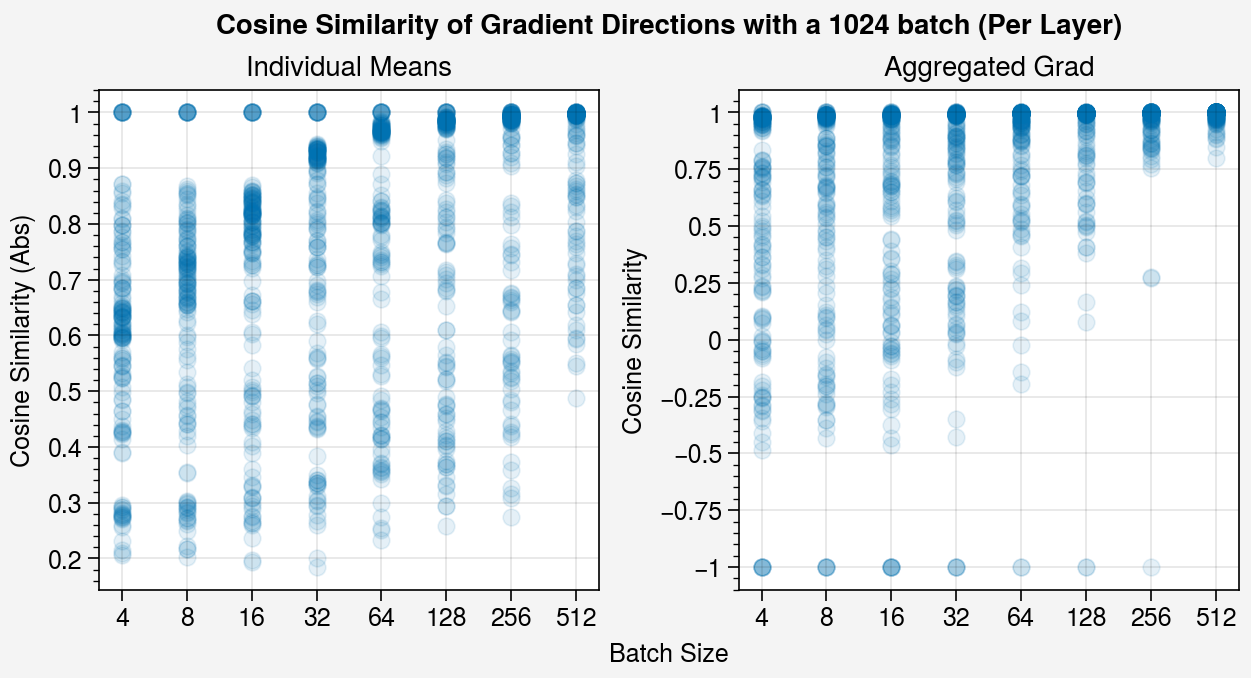

In [152]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)

for i, collection in enumerate(sim_collections):
    # x1, y1, x2, y2 = [], [], [], []
    x, y = [], []
    for j, batch in enumerate(batch_sizes):
        for layer in range(14):
            sim = np.array(collection[batch][layer]).squeeze()
            y += list(sim)
            x += [j]*len(sim)
        # y.append(np.vstack(collection[batch]).reshape(1, -1))
    # y = np.vstack(y)
    # ax[i].scatter(y)
    
    ax[i].scatter(x, y, alpha=0.1)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (Per Layer)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


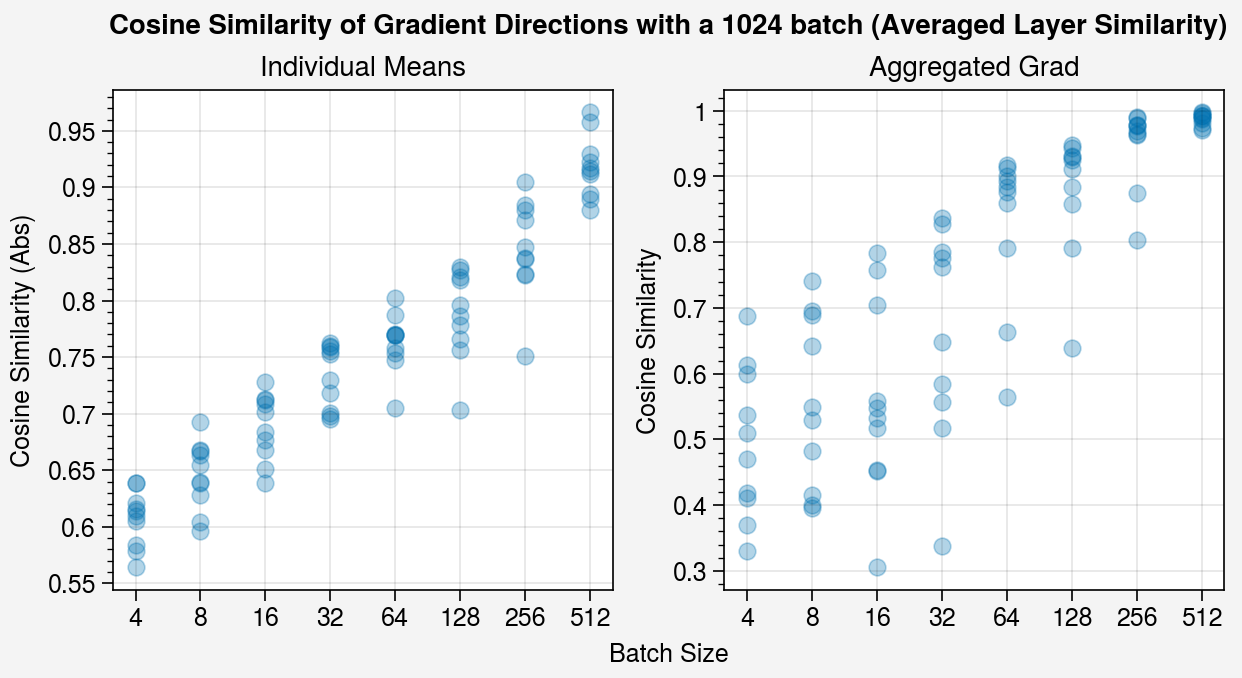

In [153]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)


for i, collection in enumerate(sim_collections):
    # x1, y1, x2, y2 = [], [], [], []
    x, y = [], []
    for j, batch in enumerate(batch_sizes):
        for rollout in range(num_rollouts):
            
            sim = np.mean([collection[batch][layer][rollout] for layer in range(14)])
            y.append(sim)
            x.append(j)
        # y.append(np.vstack(collection[batch]).reshape(1, -1))
    # y = np.vstack(y)
    # ax[i].scatter(y)
    
    ax[i].scatter(x, y, alpha=0.3)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (Averaged Layer Similarity)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


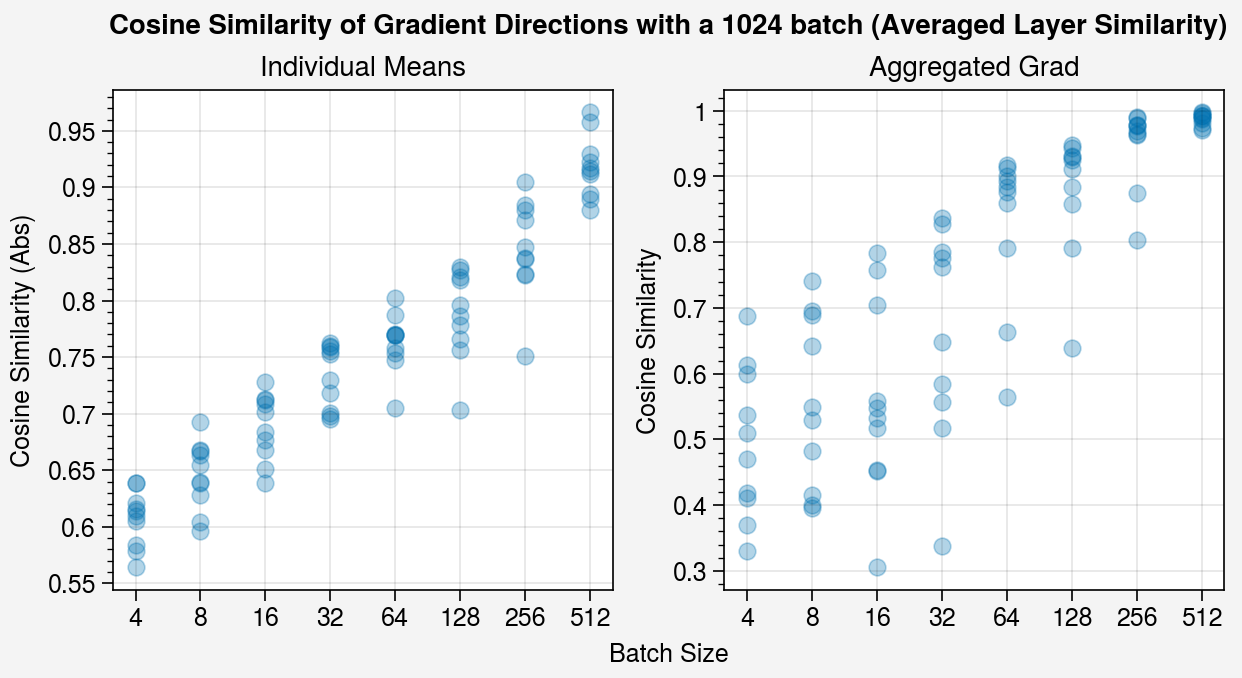

In [153]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)


for i, collection in enumerate(sim_collections):
    # x1, y1, x2, y2 = [], [], [], []
    x, y = [], []
    for j, batch in enumerate(batch_sizes):
        cur_batch = 0
        for rollout in range(num_rollouts):
            
            sim = np.mean([collection[batch][layer][rollout] for layer in range(14)])
            y.append(sim)
            x.append(j)
        # y.append(np.vstack(collection[batch]).reshape(1, -1))
    # y = np.vstack(y)
    # ax[i].scatter(y)
    
    ax[i].scatter(x, y, alpha=0.3)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (Averaged Layer Similarity)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


## Now test gradient similarities with different actions

Since it seems self evident that gradient updates will be the same if the steps are the same

In [191]:

large_num_steps = 1024
num_processes = 8
# batch = 8
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
take_optimizer_step = False
seed=2
num_rollouts = 10

all_grad_cos_sims = defaultdict(list)
grad_sizes = defaultdict(list)
#Final object that collects cosine similarities from each set of parameters for the
#  given sub_rollout batch size
#sim_means clones trajectories from the larger batch (1024 steps) while sim_means2
#  collects new trajectories
sim_means = defaultdict(list)

overall_sims = defaultdict(list)

batch_rewarded = defaultdict(list)

for batch in batch_sizes:
    for i in range(14):
        sim_means[batch].append([])
        overall_sims[batch].append([])



model = agent.actor_critic

for batch in tqdm(batch_sizes):
    agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=large_num_steps, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                    take_optimizer_step=take_optimizer_step, normalize=False, seed=seed)

    sub_agent, sub_envs, sub_rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=batch, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                    take_optimizer_step=take_optimizer_step, normalize=False, seed=seed)
    params = list(agent.actor_critic.base.parameters())
    sub_params = list(sub_agent.actor_critic.base.parameters())

    for _ in range(num_rollouts):
        populate_rollouts(agent.actor_critic, envs, rollouts, large_num_steps)

        #Compute grad for full rollout set
        agent.optimizer.zero_grad()
        next_value = model.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                     rollouts.masks[-1]).detach()
        rollouts.compute_returns(next_value, False, 0.99, 0.95)
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
        large_grad = [param.grad.clone() for param in params]


        num_batches = rollouts.num_steps // sub_rollouts.num_steps

        #Grads from copying the same trajectories as the large batch
        grad_collections = [torch.zeros(param.shape) for param in params]
        all_sub_grads = [[] for i in range(len(params))]
        grad_cos_sims = [[] for i in range(len(params))]

        #Test alternative meethod of not cloning and taking new steps each time
        #this should produce less good fits maybe?
        grad_collections2 = [torch.zeros(param.shape) for param in params]
        grad_cos_sims2 = [[] for i in range(len(params))]

        rewarded = []

        for n in range(num_batches):
            #Clone rollouts and test to ensure that they are conserved from large to small batch
            start = n * sub_rollouts.num_steps
            # clone_rollouts(rollouts, sub_rollouts, num_steps=batch, start=start)
            populate_rollouts(model, sub_envs, sub_rollouts, batch)


            #Perform update step to colect grads
            sub_agent.optimizer.zero_grad()
            next_value = model.get_value(sub_rollouts.obs[-1], sub_rollouts.recurrent_hidden_states[-1],
                                         sub_rollouts.masks[-1]).detach()
            sub_rollouts.compute_returns(next_value, False, 0.99, 0.95)
            value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = sub_agent.update(sub_rollouts)
            for i, param in enumerate(sub_params):
                grad_collections[i] += param.grad
                all_sub_grads[i].append(param.grad.clone())
                grad_cos_sims[i].append(cosine_similarity(param.grad.reshape(1, -1).numpy(), 
                                        large_grad[i].reshape(1, -1).numpy()))

            if (sub_rollouts.rewards != 0).any():
                rewarded.append(True)
            else:
                rewarded.append(False)
        batch_rewarded[batch] += rewarded

        for j in range(num_batches):
            summed = 0
            for i in range(14):
                summed += torch.sum(all_sub_grads[i][j]**2).item()
            grad_size = summed ** (1/2)
            grad_sizes[batch].append(grad_size)



        #Collect all of these into summary stats indexed by [batch][layer]
        all_grad_cos_sims[batch] += grad_cos_sims
        for i in range(len(grad_cos_sims)):
            sim_means[batch][i].append(np.mean(np.abs(grad_cos_sims[i])))
            gradlarge = large_grad[i].reshape(1, -1).numpy()
            grad1 = grad_collections[i].reshape(1, -1).numpy()
            overall_sims[batch][i].append(cosine_similarity(gradlarge, grad1))



    

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:23<00:00, 47.93s/it]


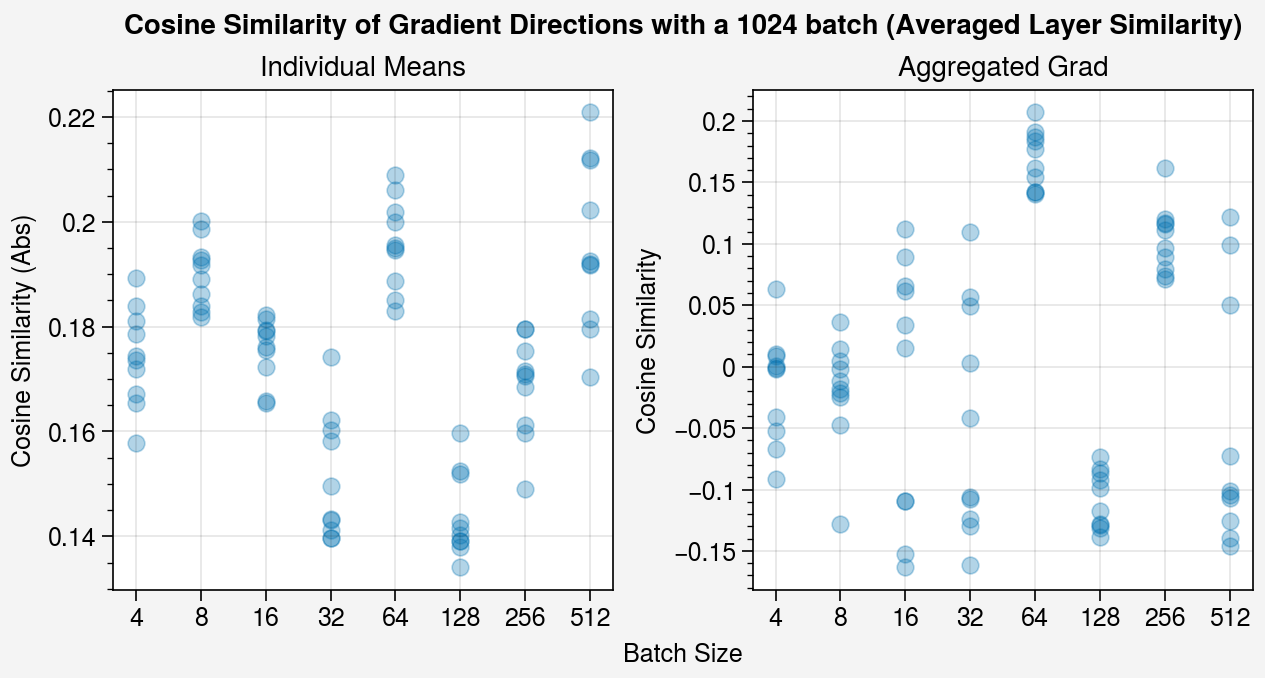

In [192]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)


for i, collection in enumerate(sim_collections):
    # x1, y1, x2, y2 = [], [], [], []
    x, y = [], []
    for j, batch in enumerate(batch_sizes):
        cur_batch = 0
        for rollout in range(num_rollouts):
            
            sim = np.mean([collection[batch][layer][rollout] for layer in range(14)])
            y.append(sim)
            x.append(j)
        # y.append(np.vstack(collection[batch]).reshape(1, -1))
    # y = np.vstack(y)
    # ax[i].scatter(y)
    
    ax[i].scatter(x, y, alpha=0.3)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (Averaged Layer Similarity)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


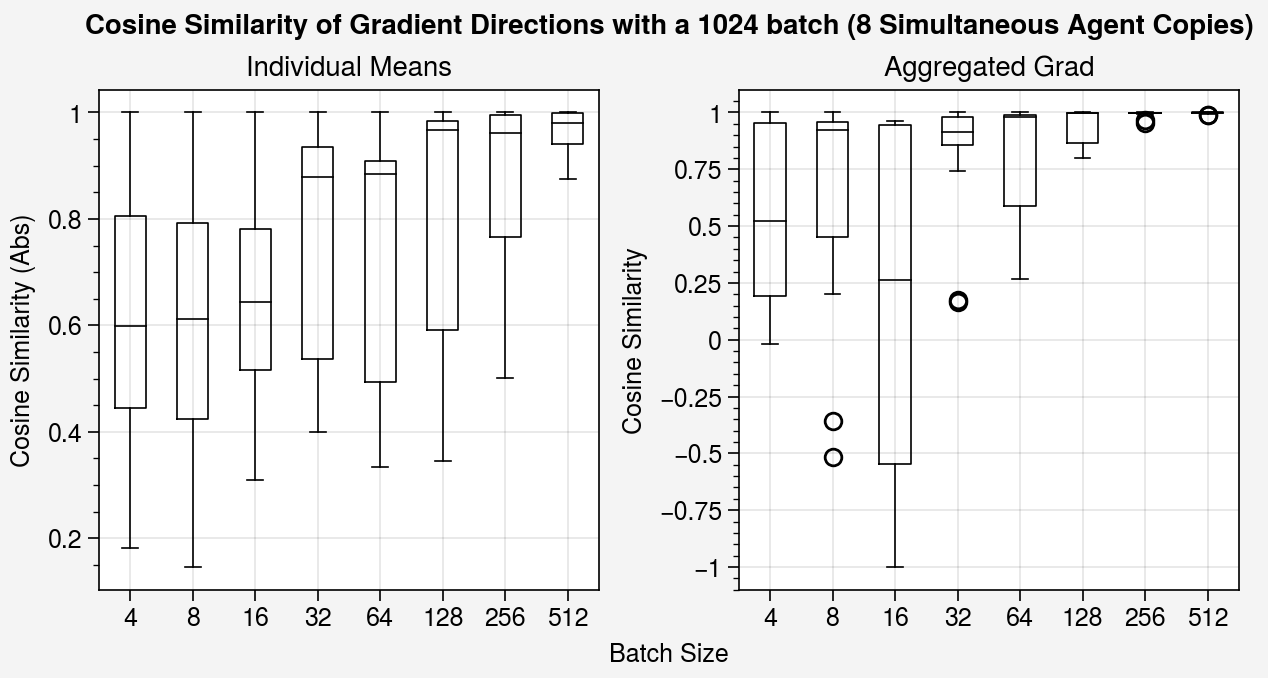

In [88]:
sim_collections = [sim_means, overall_sims]
sim_labels = ['Individual Means', 'Aggregated Grad']

fig, ax = pplt.subplots(ncols=2, sharey=False)
for i, collection in enumerate(sim_collections):
    
    y = []
    for batch in batch_sizes:
        y.append(np.vstack(collection[batch]).reshape(1, -1))
    y = np.vstack(y)
    ax[i].boxplot(y.T)
    
ax.format(title=sim_labels, xlocator=np.arange(10),
          xticklabels=[str(w) for w in batch_sizes],
          xlabel='Batch Size',
          suptitle='Cosine Similarity of Gradient Directions with a 1024 batch (8 Simultaneous Agent Copies)')
ax[0].format(ylabel='Cosine Similarity (Abs)')
ax[1].format(ylabel='Cosine Similarity')


# Reward Probability of Fresh Agent

Now it is somewhat tricky to exactly compare trajectories with reward and those without in gradient direction. But what we can do is see how batch size and agent copy numbers affect the probability of a reward being present in an update step. We would also like to confirm that steps with reward have disproportionate effects on gradient update.

In addition, later may want to test to see if the batch size effects hold as the agent becomes more trained?

**Not sure why but the environment seems to pass reward different than it is programmed to**

In [13]:

large_num_steps = 1024
num_processes = 8
# batch = 8
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
take_optimizer_step = False
seed = 1

reward_probabilities = defaultdict(list)
for seed in range(10):
    for batch in tqdm(batch_sizes):
    # for batch in [8]:
        #Generate large storage object and sub storage
        agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                        num_steps=large_num_steps, num_processes=num_processes, ppo_epoch=1, num_mini_batch=1,
                                        take_optimizer_step=take_optimizer_step, normalize=False, seed=seed)
        populate_rollouts(agent.actor_critic, envs, rollouts, large_num_steps, seed=0)

        model = agent.actor_critic
        sub_rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                      model.recurrent_hidden_state_size, model.auxiliary_output_size)

        num_batches = rollouts.num_steps // sub_rollouts.num_steps
        num_rewarded_batches = 0
        for n in range(num_batches):
            #Clone rollouts and test to ensure that they are conserved from large to small batch
            start = n * sub_rollouts.num_steps
            clone_rollouts(rollouts, sub_rollouts, num_steps=batch, start=start)
            rewarded = (sub_rollouts.rewards != 0).any()
            if rewarded:
                num_rewarded_batches += 1

        reward_probabilities[batch].append(num_rewarded_batches / num_batches)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:01<00:00,  7.70s/it]


# Next Attempt: Similarities on partially trained agent

* Take checkpoints of 16 width agent (0, 20, 40, 60, 80, 100, 200)
* Collect batches and gradients (1024 total steps, batch sizes 512, 128, 32, 8)
* Compute pairwise cosine similarities

In [14]:
'''
Load collected data for this section (width16 t0, chks [0, 20, 40, 60, 80, 100, 200])
'''
all_results = pickle.load(open('data/grads/width16t0_checkpoint_grads', 'rb'))
all_grads = all_results['all_grads']
all_rewards = all_results['all_rewards']
batch_sizes = [8, 32, 128, 512]
chks = [0, 20, 40, 60, 80, 100, 200]

ref_results = pickle.load(open('data/grads/width16t0_checkpoint_refgrads', 'rb'))
ref_grads = ref_results['ref_grads']

layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]


In [195]:
'''
OLD
Compute pairwise cosine similarities across batches of gradients'''
chk_cos_sims = {chk: {} for chk in chks}

layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        chk_cos_sims[chk][batch_size] = []
        for layer in range(14):
            cos_sims = []

            gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer])
            cs = np.triu(cosine_similarity(gr), k=1)
            cs = cs[cs != 0]
            
            chk_cos_sims[chk][batch_size].append(list(cs))


            
chk_ref_cos_sims = {chk: {} for chk in chks}
layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        chk_ref_cos_sims[chk][batch_size] = []
        for layer in range(14):            
            gr1 = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer])
            # gr2 = torch.vstack(all_grads[chk][ref_batch_size][layer]).reshape(-1, layer_sizes[layer])
            gr2 = torch.vstack(ref_grads[chk][layer]).reshape(-1, layer_sizes[layer])
            cos_sim = cosine_similarity(gr1, gr2)
            cos_sims = np.vstack(cos_sim).reshape(-1)
            chk_ref_cos_sims[chk][batch_size].append(list(cos_sims))




100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 45.51it/s]


In [ ]:
'''
NEW
Compute pairwise cosine similarities across batches of gradients
    *Corrected version for positive and negative value_diffs
'''
chk_cos_sims = {chk: {} for chk in chks}

layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        pos_idxs = np.array(all_results['all_value_diffs'][chk][batch_size]) > 0
        chk_cos_sims[chk][batch_size] = []
        for layer in range(14):
            cos_sims = []

            gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer]).numpy()    
            gr1 = gr[pos_idxs]
            gr2 = gr[~pos_idxs]
            if len(gr1) > 0:
                cs1 = np.triu(cosine_similarity(gr1), k=1)
                cs1 = cs1[cs1 != 0]
            else:
                cs1 = np.array([])
            
            if len(gr2) > 0:
                cs2 = np.triu(cosine_similarity(gr2), k=1)
                cs2 = cs2[cs2 != 0]
            else:
                cs2 = np.array([])
            cs_comb = np.concatenate([cs1, cs2])

            chk_cos_sims[chk][batch_size].append(list(cs_comb))


            
chk_ref_cos_sims = {chk: {} for chk in chks}
layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        chk_ref_cos_sims[chk][batch_size] = []
        pos_idxs = np.array(all_results['all_value_diffs'][chk][batch_size]) > 0
        pos_idxs_ref = np.array(ref_results['all_value_diffs'][chk]) > 0

        for layer in range(14):
            
            
            gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer]).numpy()    
            gr_ref = torch.vstack(ref_grads[chk][layer]).reshape(-1, layer_sizes[layer]).numpy()    

            gr1 = gr[pos_idxs]
            gr2 = gr[~pos_idxs]
            gr1_ref = gr_ref[pos_idxs_ref]
            gr2_ref = gr_ref[~pos_idxs_ref]
            
            if len(gr1) > 0 and len(gr1_ref) > 0:
                cs1 = cosine_similarity(gr1, gr1_ref)
                cs1 = np.vstack(cs1).reshape(-1)
            else:
                cs1 = np.array([])
            
            if len(gr2) > 0 and len(gr2_ref) > 0:
                cs2 = cosine_similarity(gr2, gr2_ref)
                cs2 = np.vstack(cs2).reshape(-1)
            else:
                cs2 = np.array([])
            
            cs_comb = np.concatenate([cs1, cs2])
            chk_ref_cos_sims[chk][batch_size].append(list(cs_comb))



## Data Collection

In [14]:
trial_name = 'nav_pdistal_width16batch200'
trial = 0
checkpoint_folder = '../trained_models/checkpoint/nav_poster_netstructure/'
model_folder ='nav_poster_netstructure/'


path = checkpoint_folder + f'{trial_name}_t{trial}'
# Get env_kwargs
model_name = f'{model_folder}{trial_name}'
print(model_name)
_, _, kwargs = load_model_and_env(model_name, trial)

checkpoints = list(Path(path).iterdir())



nav_poster_netstructure/nav_pdistal_width16batch200


In [19]:
trial_name = 'nav_pdistal_width16batch200'
trial = 0
checkpoint_folder = '../trained_models/checkpoint/nav_poster_netstructure/'
model_folder ='nav_poster_netstructure/'


path = checkpoint_folder + f'{trial_name}_t{trial}'
# Get env_kwargs
model_name = f'{model_folder}{trial_name}'
print(model_name)
_, _, kwargs = load_model_and_env(model_name, trial)

checkpoints = list(Path(path).iterdir())



'''Collect batch gradients for different checkpoints and batch sizes
    Fixed 50 batches regardless of batch size so we have potentially less noise
    in larger batches
'''

#reorder by number
chks = [int(checkpoint.name.split('.pt')[0]) for checkpoint in checkpoints]
chks = np.sort(np.array(chks))
parent = checkpoints[0].parent

#Override with just a few checkpoints
chks = [0, 20, 40, 60, 80, 100, 200]
# chks = [100]
ordered_checkpoints = [parent/f'{chk}.pt' for chk in chks]


batch_sizes = [8, 32, 128, 512]
num_processes = 16

all_grads = {}
all_rewarded = {}
all_rewards = {}
all_value_losses = {}
all_action_losses = {}
all_value_diffs = {}


env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

for chk in chks:
    all_grads[chk] = {batch: [] for batch in batch_sizes}
    all_rewarded[chk] = {batch: [] for batch in batch_sizes}
    all_rewards[chk] = {batch: [] for batch in batch_sizes}
    all_value_losses[chk] = {batch: [] for batch in batch_sizes}
    all_action_losses[chk] = {batch: [] for batch in batch_sizes}
    all_value_diffs[chk] = {batch: [] for batch in batch_sizes}
for i, checkpoint in enumerate(tqdm(ordered_checkpoints)):
    chk = chks[i]
    model, obs_rms = torch.load(checkpoint)
    agent = LoudPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)
    params = list(agent.actor_critic.base.parameters())

    for batch in batch_sizes:
        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)
        
        # num_batches = collect_steps // batch
        num_batches = 50
        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches)
        all_grads[chk][batch] = res['all_grads']
        all_rewarded[chk][batch] = res['rewarded']
        all_rewards[chk][batch] = res['rewards']
        all_value_losses[chk][batch] = res['value_losses']
        all_action_losses[chk][batch] = res['action_losses']
        all_value_diffs[chk][batch] = res['value_diff']
        
        obs = rollouts.obs[-1]
        
        
        
all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/width16t0_checkpoint_grads', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [23:18<00:00, 199.81s/it]


In [283]:
'''Collect ref batch gradients for different checkpoints and batch sizes'''

#reorder by number
chks = [int(checkpoint.name.split('.pt')[0]) for checkpoint in checkpoints]
chks = np.sort(np.array(chks))
parent = checkpoints[0].parent

#Override with just a few checkpoints
chks = [0, 20, 40, 60, 80, 100, 200]
ordered_checkpoints = [parent/f'{chk}.pt' for chk in chks]


collect_steps = 2048
num_processes = 16

ref_grads = {}
ref_rewarded = {}
ref_rewards = {}
ref_value_losses = {}
ref_action_losses = {}
ref_value_diffs = {}

batch = 2048

env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

for i, checkpoint in enumerate(tqdm(ordered_checkpoints)):
    chk = chks[i]
    model, obs_rms = torch.load(checkpoint)
    agent = LoudPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)
    params = list(agent.actor_critic.base.parameters())

    rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                model.recurrent_hidden_state_size, model.auxiliary_output_size)
    rollouts.obs[0].copy_(obs)
    
    num_batches = collect_steps // batch
    res = collect_batches_and_grads(agent, envs, rollouts, num_batches=20)
    ref_grads[chk] = res['all_grads']
    ref_rewarded[chk] = res['rewarded']
    ref_rewards[chk] = res['rewards']
    ref_value_losses[chk] = res['value_losses']
    ref_action_losses[chk] = res['action_losses']
    ref_value_diffs[chk] = res['value_diff']
    obs = rollouts.obs[-1]
    
ref_results = {
    'ref_grads': ref_grads,
    'ref_rewarded': ref_rewarded,
    'ref_rewards': ref_rewards,
    'ref_value_losses': ref_value_losses,
    'ref_action_losses': ref_action_losses,
    'ref_value_diffs': ref_value_diffs    
}
pickle.dump(ref_results, open('data/grads/width16t0_checkpoint_refgrads', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [17:58<00:00, 154.10s/it]


In [19]:
trial_name = 'nav_pdistal_width16batch200'
trial = 0
checkpoint_folder = '../trained_models/checkpoint/nav_poster_netstructure/'
model_folder ='nav_poster_netstructure/'


path = checkpoint_folder + f'{trial_name}_t{trial}'
# Get env_kwargs
model_name = f'{model_folder}{trial_name}'
print(model_name)
_, _, kwargs = load_model_and_env(model_name, trial)

checkpoints = list(Path(path).iterdir())



'''Collect batch gradients for different checkpoints and batch sizes
    Fixed 50 batches regardless of batch size so we have potentially less noise
    in larger batches
'''

#reorder by number
chks = [int(checkpoint.name.split('.pt')[0]) for checkpoint in checkpoints]
chks = np.sort(np.array(chks))
parent = checkpoints[0].parent

#Override with just a few checkpoints
chks = [0, 20, 40, 60, 80, 100, 200]
# chks = [100]
ordered_checkpoints = [parent/f'{chk}.pt' for chk in chks]


batch_sizes = [8, 32, 128, 512]
num_processes = 16

all_grads = {}
all_rewarded = {}
all_rewards = {}
all_value_losses = {}
all_action_losses = {}
all_value_diffs = {}


env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

for chk in chks:
    all_grads[chk] = {batch: [] for batch in batch_sizes}
    all_rewarded[chk] = {batch: [] for batch in batch_sizes}
    all_rewards[chk] = {batch: [] for batch in batch_sizes}
    all_value_losses[chk] = {batch: [] for batch in batch_sizes}
    all_action_losses[chk] = {batch: [] for batch in batch_sizes}
    all_value_diffs[chk] = {batch: [] for batch in batch_sizes}
for i, checkpoint in enumerate(tqdm(ordered_checkpoints)):
    chk = chks[i]
    model, obs_rms = torch.load(checkpoint)
    agent = LoudPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)
    params = list(agent.actor_critic.base.parameters())

    for batch in batch_sizes:
        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)
        
        # num_batches = collect_steps // batch
        num_batches = 50
        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches)
        all_grads[chk][batch] = res['all_grads']
        all_rewarded[chk][batch] = res['rewarded']
        all_rewards[chk][batch] = res['rewards']
        all_value_losses[chk][batch] = res['value_losses']
        all_action_losses[chk][batch] = res['action_losses']
        all_value_diffs[chk][batch] = res['value_diff']
        
        obs = rollouts.obs[-1]
        
        
        
all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/width16t0_checkpoint_grads', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [23:18<00:00, 199.81s/it]


## Histograms with 0 and 100 checkpoint

Noticably the spread decreases with both batch size and training time. Lets quantify it next

In [77]:


# Inter batch size similarities - layer 0
layer = 0
chk = 100
batch_size = 32

cos_sims = []
num_batches = len(all_grads[chk][batch_size][layer])
for i in range(num_batches):
    for j in range(i+1, num_batches):
        grad1 = all_grads[chk][batch_size][layer][i].reshape(1, -1).numpy()
        grad2 = all_grads[chk][batch_size][layer][j].reshape(1, -1).numpy()
        cos_sim = cosine_similarity(grad1, grad2)
        cos_sims.append(cos_sim)
cos_sims = np.vstack(cos_sims).reshape(-1)


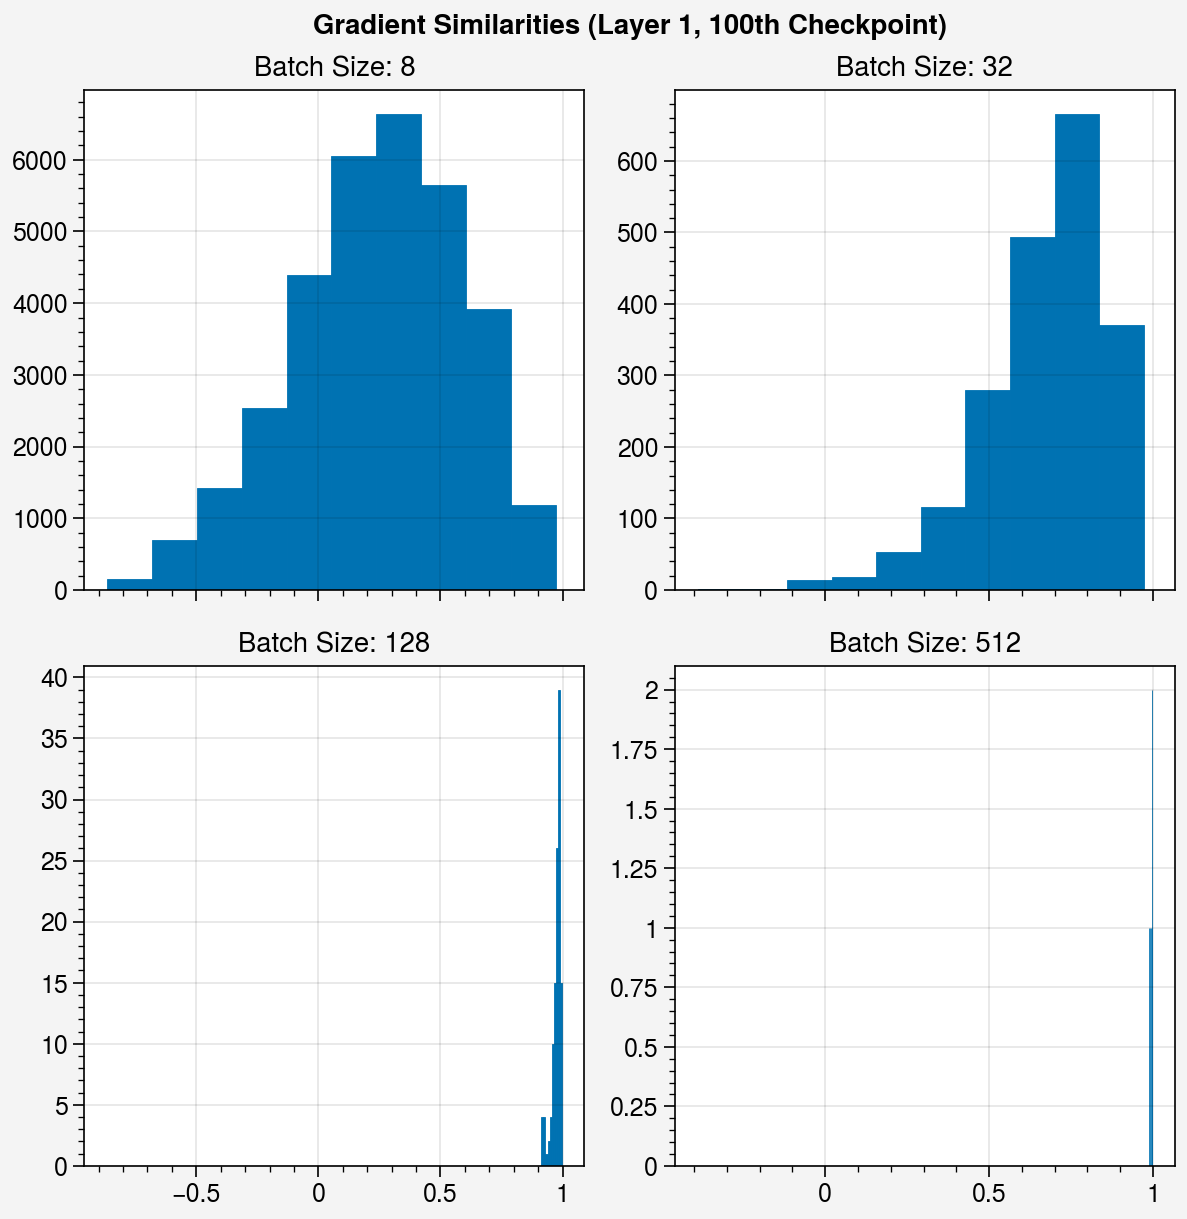

In [91]:
# Inter batch size similarities - layer 0, stratify across batch sizes
layer = 0
chk = 100

fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for n, batch_size in enumerate(batch_sizes):
    cos_sims = []
    num_batches = len(all_grads[chk][batch_size][layer])
    for i in range(num_batches):
        for j in range(i+1, num_batches):
            grad1 = all_grads[chk][batch_size][layer][i].reshape(1, -1).numpy()
            grad2 = all_grads[chk][batch_size][layer][j].reshape(1, -1).numpy()
            cos_sim = cosine_similarity(grad1, grad2)
            cos_sims.append(cos_sim)
    cos_sims = np.vstack(cos_sims).reshape(-1)
    
    ax[n].hist(cos_sims)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Gradient Similarities (Layer 1, 100th Checkpoint)')


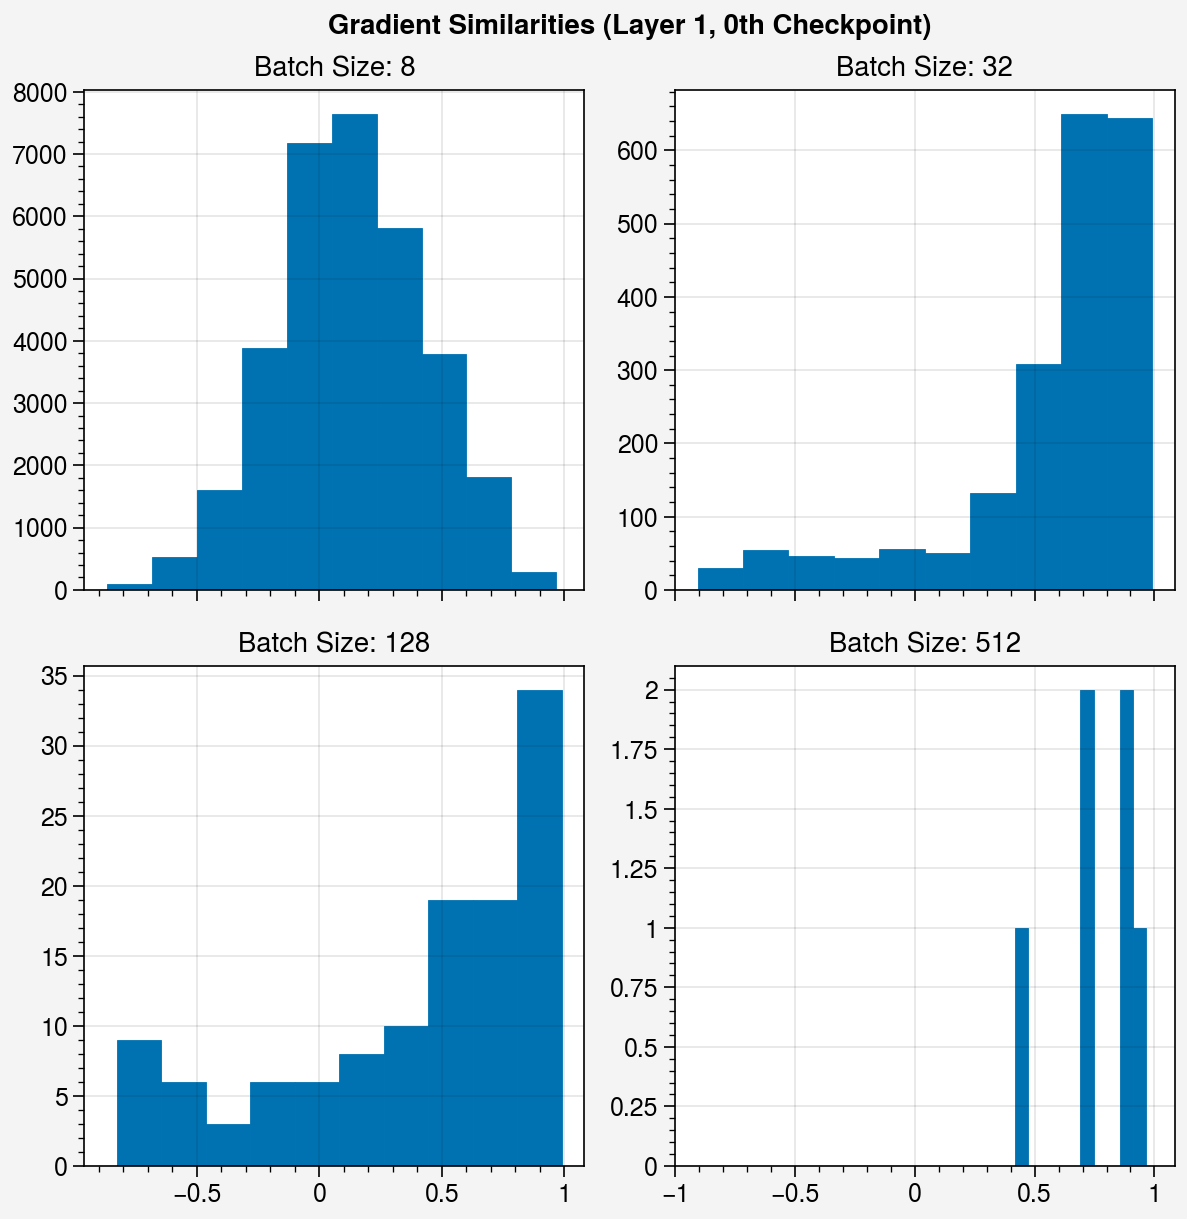

In [90]:
# Inter batch size similarities - layer 0, stratify across batch sizes
layer = 0
chk = 0

fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for n, batch_size in enumerate(batch_sizes):
    cos_sims = []
    num_batches = len(all_grads[chk][batch_size][layer])
    for i in range(num_batches):
        for j in range(i+1, num_batches):
            grad1 = all_grads[chk][batch_size][layer][i].reshape(1, -1).numpy()
            grad2 = all_grads[chk][batch_size][layer][j].reshape(1, -1).numpy()
            cos_sim = cosine_similarity(grad1, grad2)
            cos_sims.append(cos_sim)
    cos_sims = np.vstack(cos_sims).reshape(-1)
    
    ax[n].hist(cos_sims)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Gradient Similarities (Layer 1, 0th Checkpoint)')


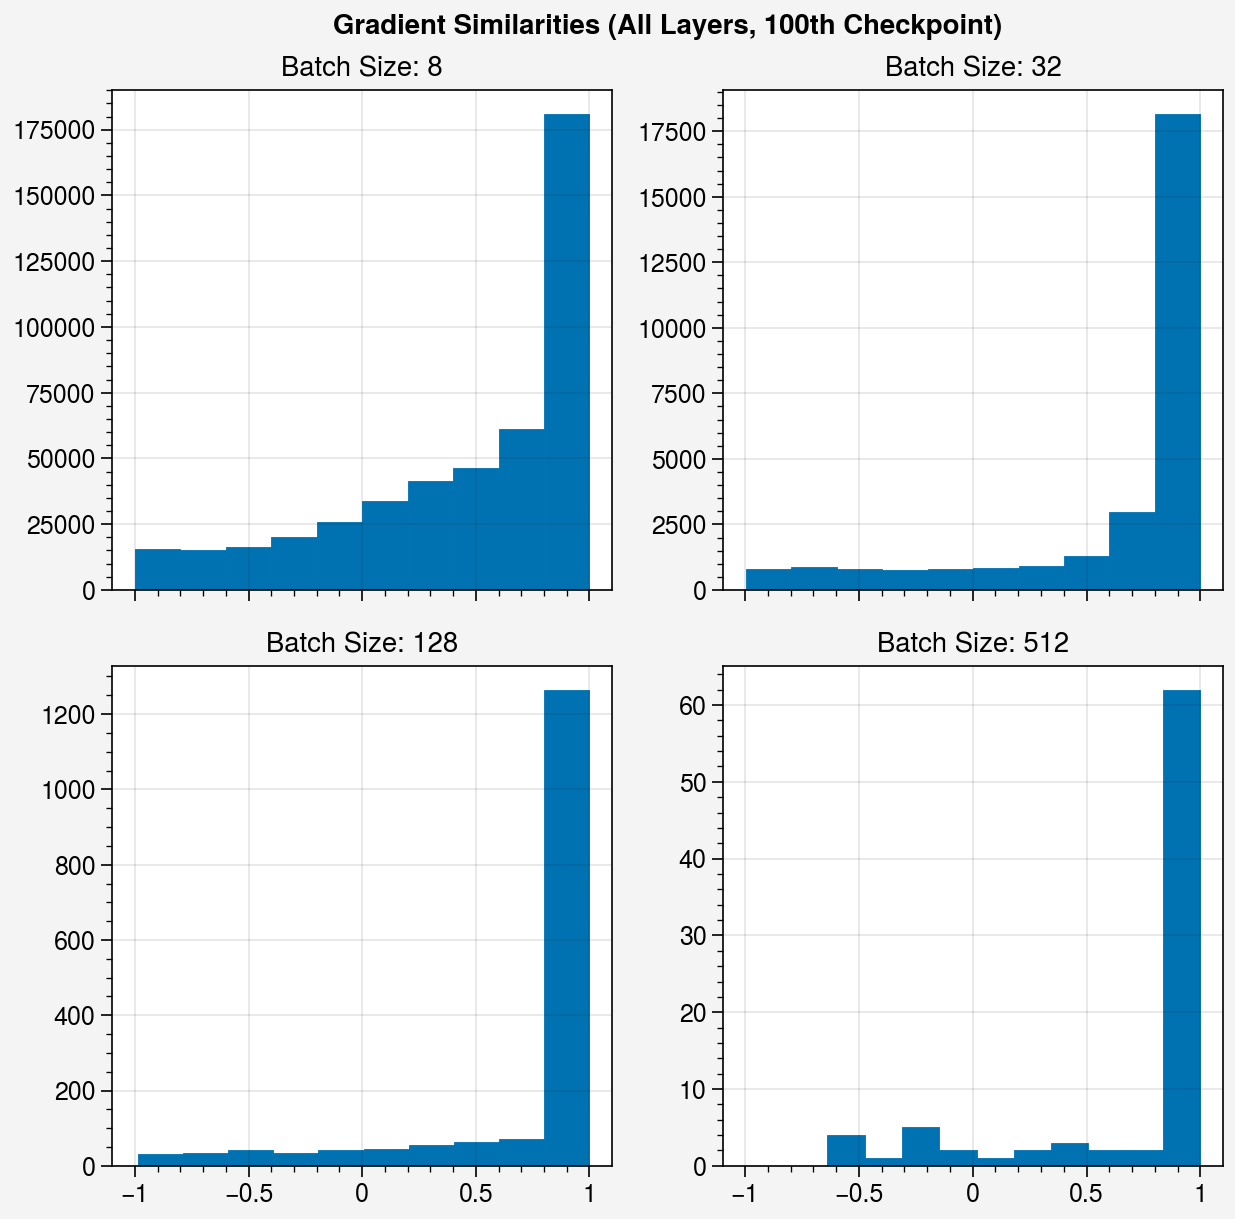

In [92]:
# Inter batch size similarities - layer 0, stratify across batch sizes, include all layers
chk = 100

fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for n, batch_size in enumerate(batch_sizes):
    cos_sims = []
    num_batches = len(all_grads[chk][batch_size][layer])
    for i in range(num_batches):
        for j in range(i+1, num_batches):
            for layer in range(14):
                grad1 = all_grads[chk][batch_size][layer][i].reshape(1, -1).numpy()
                grad2 = all_grads[chk][batch_size][layer][j].reshape(1, -1).numpy()
                cos_sim = cosine_similarity(grad1, grad2)
                cos_sims.append(cos_sim)
    cos_sims = np.vstack(cos_sims).reshape(-1)
    
    ax[n].hist(cos_sims)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Gradient Similarities (All Layers, 100th Checkpoint)')


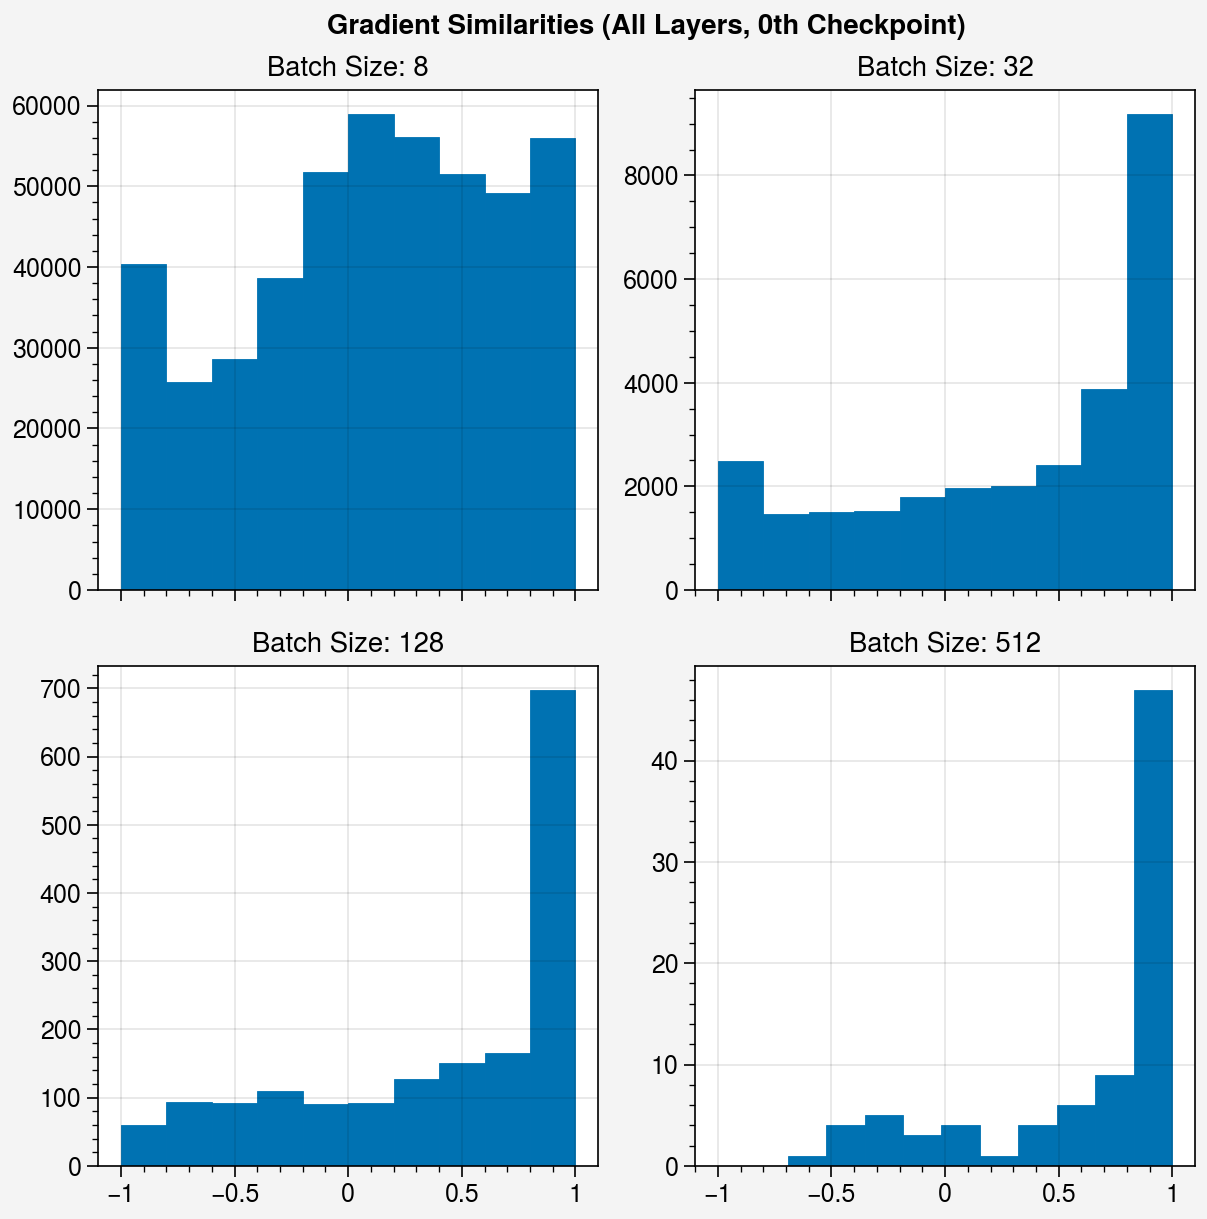

In [93]:
# Inter batch size similarities - layer 0, stratify across batch sizes, include all layers
chk = 0

fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

for n, batch_size in enumerate(batch_sizes):
    cos_sims = []
    num_batches = len(all_grads[chk][batch_size][layer])
    for i in range(num_batches):
        for j in range(i+1, num_batches):
            for layer in range(14):
                grad1 = all_grads[chk][batch_size][layer][i].reshape(1, -1).numpy()
                grad2 = all_grads[chk][batch_size][layer][j].reshape(1, -1).numpy()
                cos_sim = cosine_similarity(grad1, grad2)
                cos_sims.append(cos_sim)
    cos_sims = np.vstack(cos_sims).reshape(-1)
    
    ax[n].hist(cos_sims)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Gradient Similarities (All Layers, 0th Checkpoint)')


## Means of gradient similarities and number of rewards over checkpoints

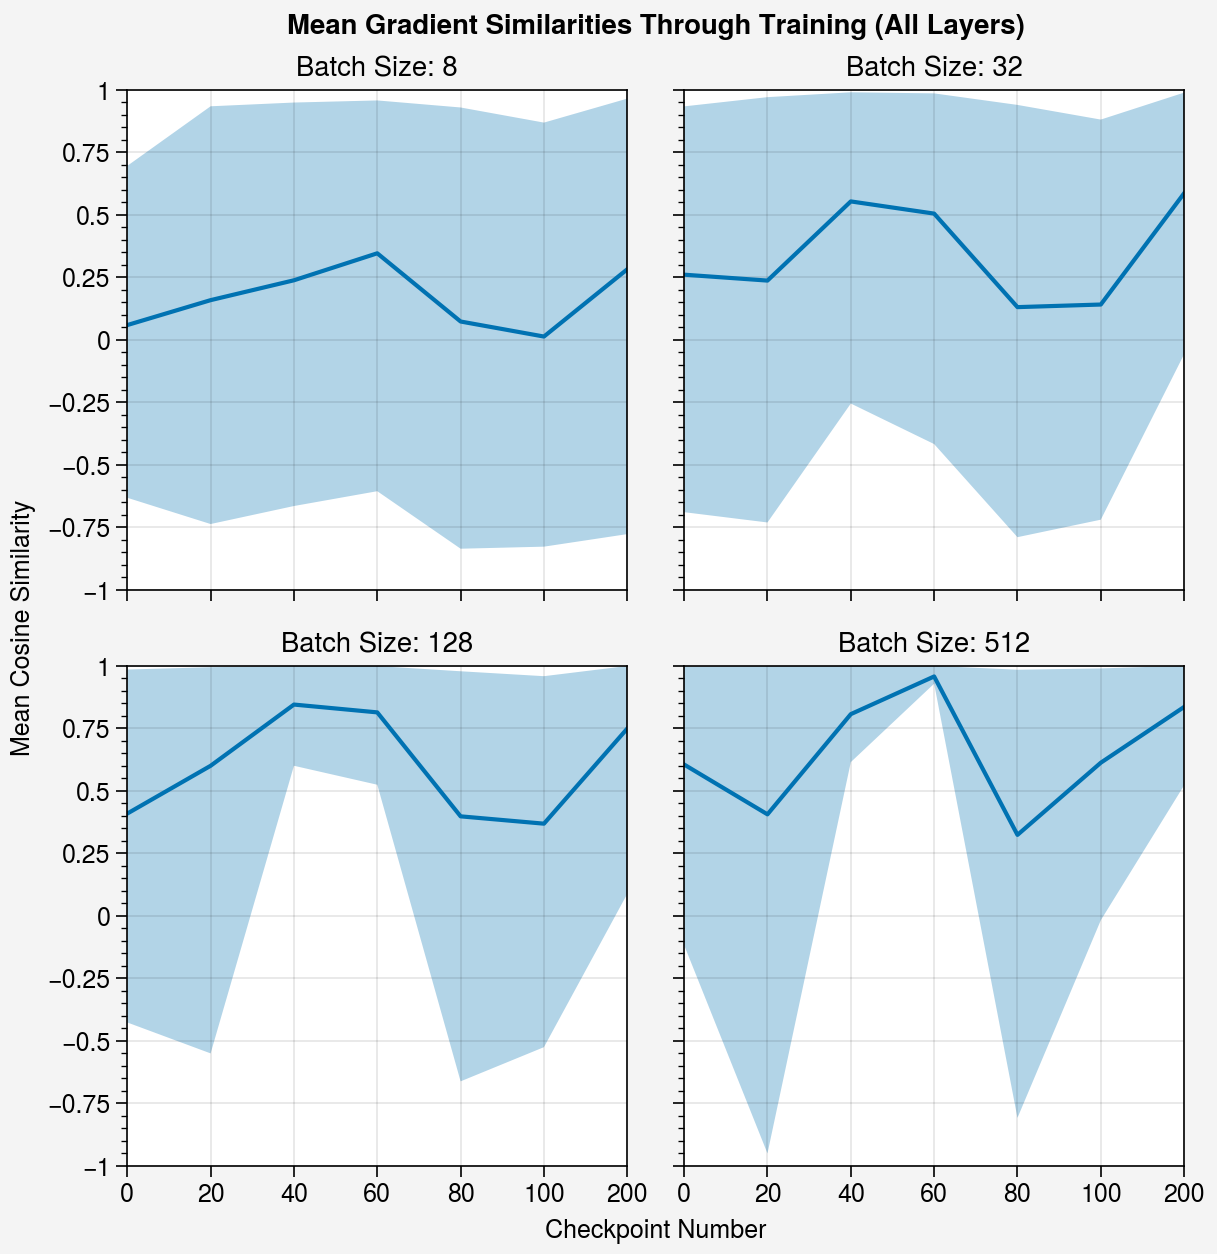

In [196]:

fig, ax = pplt.subplots(nrows=2, ncols=2, share=True)
for n, batch_size in enumerate(batch_sizes):
# for n, batch_size in enumerate([128]):
    xs = []
    ys = []
    stds = []
    lows = []
    highs = []
    
    num_batches = len(all_grads[chk][batch_size][layer])
    for x, chk in enumerate(chks):
        cos_sims = np.vstack(chk_cos_sims[chk][batch_size]).reshape(-1)
        
        xs.append(x)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
    # ax[n].hist(cos_sims)
    ax[n].plot(xs, ys)
    ax[n].fill_between(xs, lows, highs, alpha=0.3)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Mean Gradient Similarities Through Training (All Layers)',
          ylim=[-1., 1.],
          xlocator=range(7),
          xticklabels=[str(chk) for chk in chks],
          xlabel='Checkpoint Number',
          ylabel='Mean Cosine Similarity')


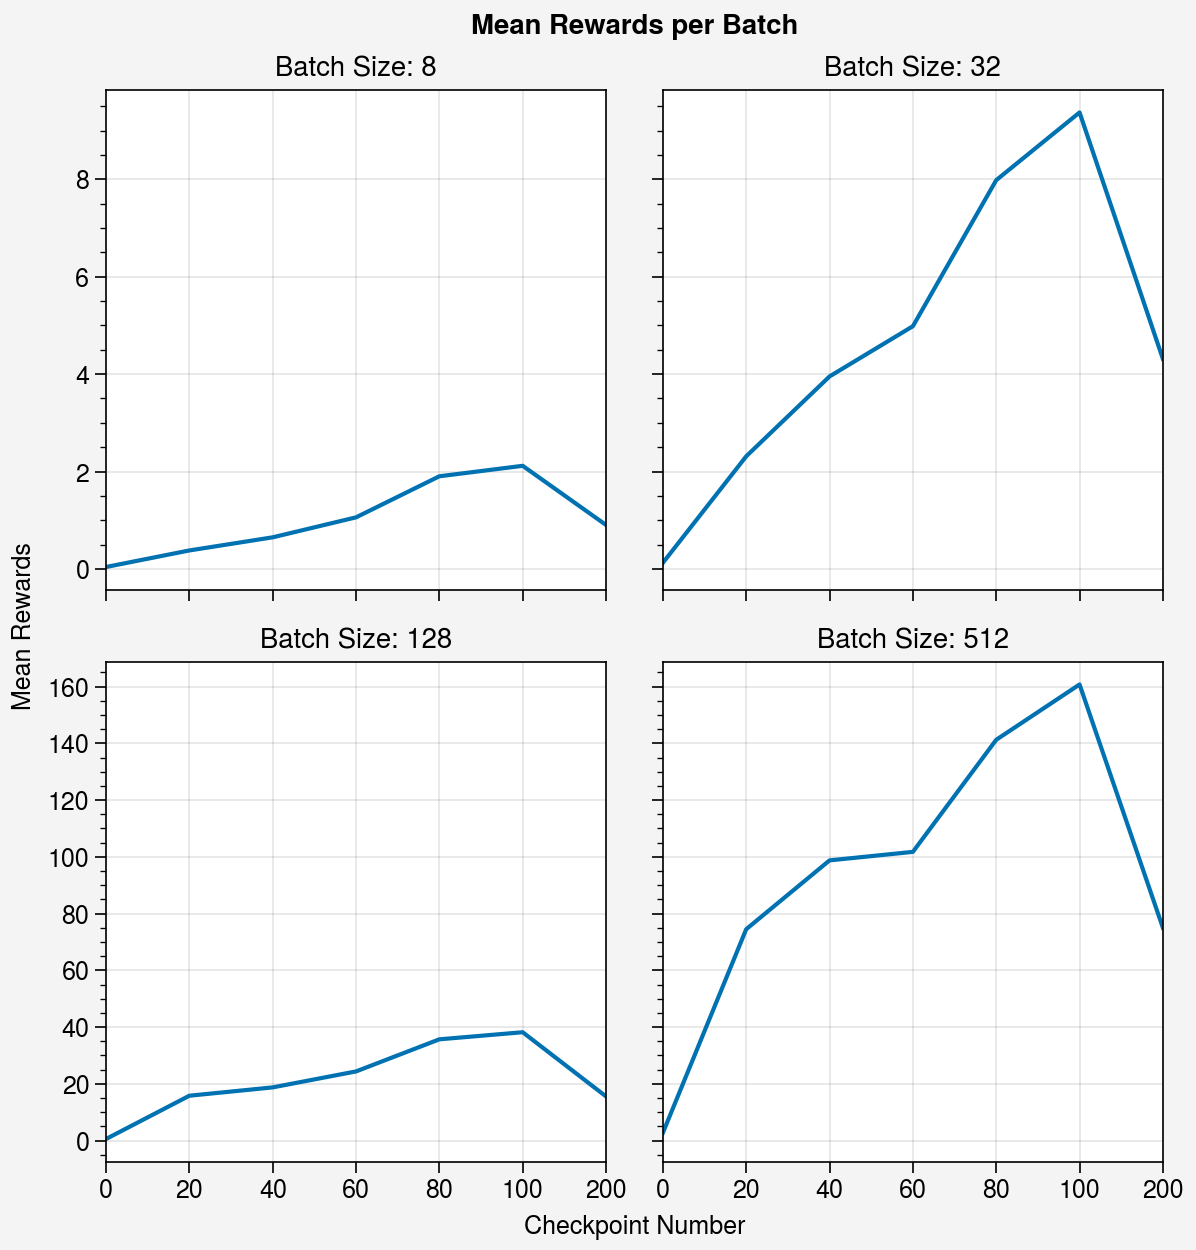

In [9]:
fig, ax = pplt.subplots(nrows=2, ncols=2)
for n, batch_size in enumerate(batch_sizes):
# for n, batch_size in enumerate([128]):
    xs = []
    ys = []
    
    for x, chk in enumerate(chks):
        xs.append(x)
        ys.append(np.mean(all_rewards[chk][batch_size]))
    ax[n].plot(xs, ys)

ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
      suptitle='Mean Rewards per Batch',
      # ylim=[0, 1.05],
      xlocator=range(7),
      xticklabels=[str(chk) for chk in chks],
      xlabel='Checkpoint Number',
      ylabel='Mean Rewards')


### Gradient similarity of batches dependent on number of rewards in batch

There seems to be no correlation between difference in number of rewards between batches and the cosine similarities of their gradients

In [138]:
reward_diffs = {chk: {} for chk in chks}
for chk in tqdm(chks):
    for batch_size in batch_sizes:
        num_batches = len(all_grads[chk][batch_size][0])
        # reward_diffs[chk][batch_size] = []
        rew_diffs = []

        for i in range(num_batches):
            for j in range(i+1, num_batches):
                rew1 = all_rewards[chk][batch_size][i]
                rew2 = all_rewards[chk][batch_size][j]
                rew_diff = np.abs(rew1-rew2)
                rew_diffs.append(rew_diff)
            reward_diffs[chk][batch_size] = np.array(rew_diffs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.32it/s]


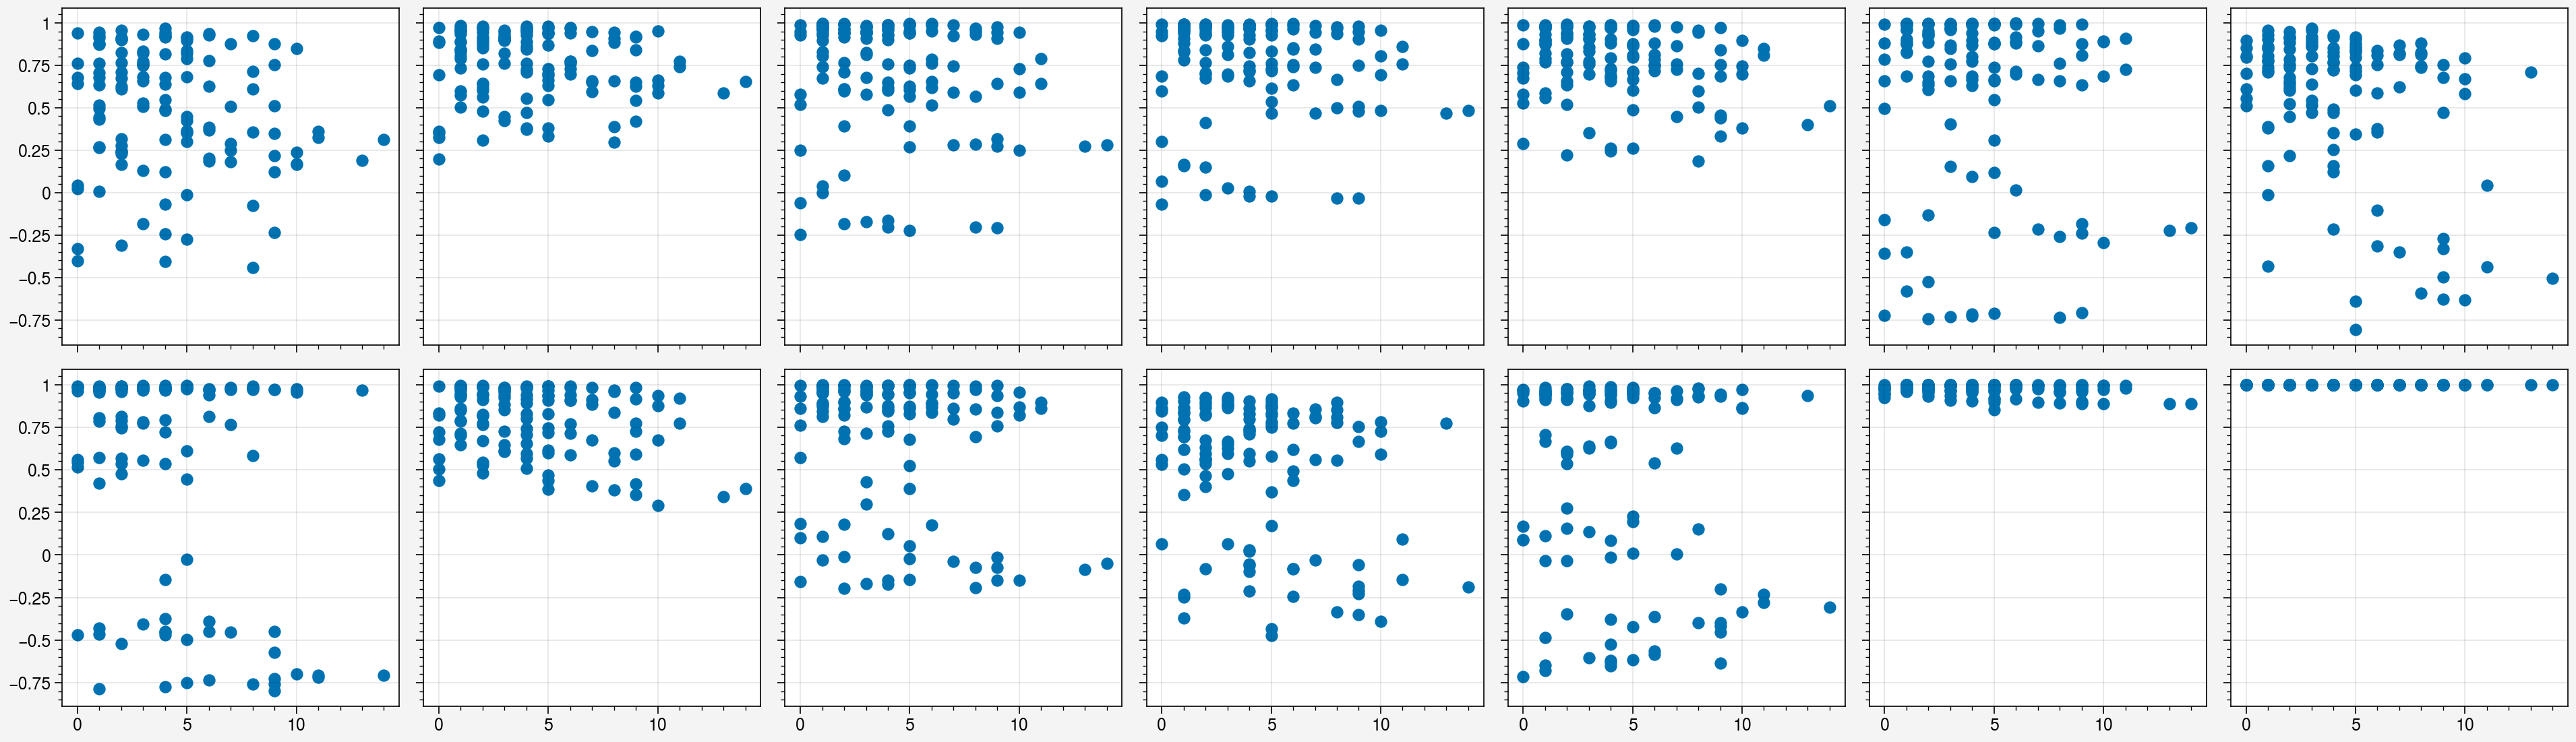

In [163]:
chk = 60
batch = 128
rew_diffs = reward_diffs[chk][batch]
cos_sims = chk_cos_sims[chk][batch]

fig, ax = pplt.subplots(nrows=2, ncols=7)
for i in range(14):
    ax[i].scatter(rew_diffs, cos_sims[i])

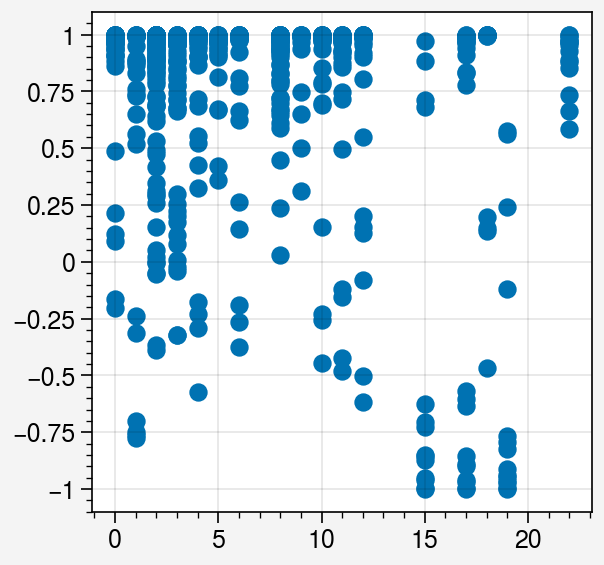

In [162]:
x = []
y = []

for chk in chks:
    batch = 512
    for i in range(14):
        x += reward_diffs[chk][batch].tolist()
        y += chk_cos_sims[chk][batch][i]

fig, ax = pplt.subplots()
ax.scatter(x, y)
# for i in range(14):
#     ax[i].scatter(rew_diffs, cos_sims[i])

## Cosine Similarity Hierarchical Clustering

We noticed that although some batches seemed to produce different gradient directions, there were actually clusters of directions that seemed to appear

In [125]:
import scipy.cluster.hierarchy as sch

def hierarchical_cluster(cs):
    pairwise_dists = sch.distance.pdist(cs)
    linkage = sch.linkage(pairwise_dists, method='complete')
    cluster_distance_threshold = pairwise_dists.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion='distance')
    idxs = np.argsort(idx_to_cluster_array)
    
    return idxs

Here we see that through different checkpoints, sometimes all batches appear to produce the same gradient direction (e.g. checkpoints 40, 60, 200), and some have distinct clusters of batches that produce similar gradients (0, 20, 80, 100).

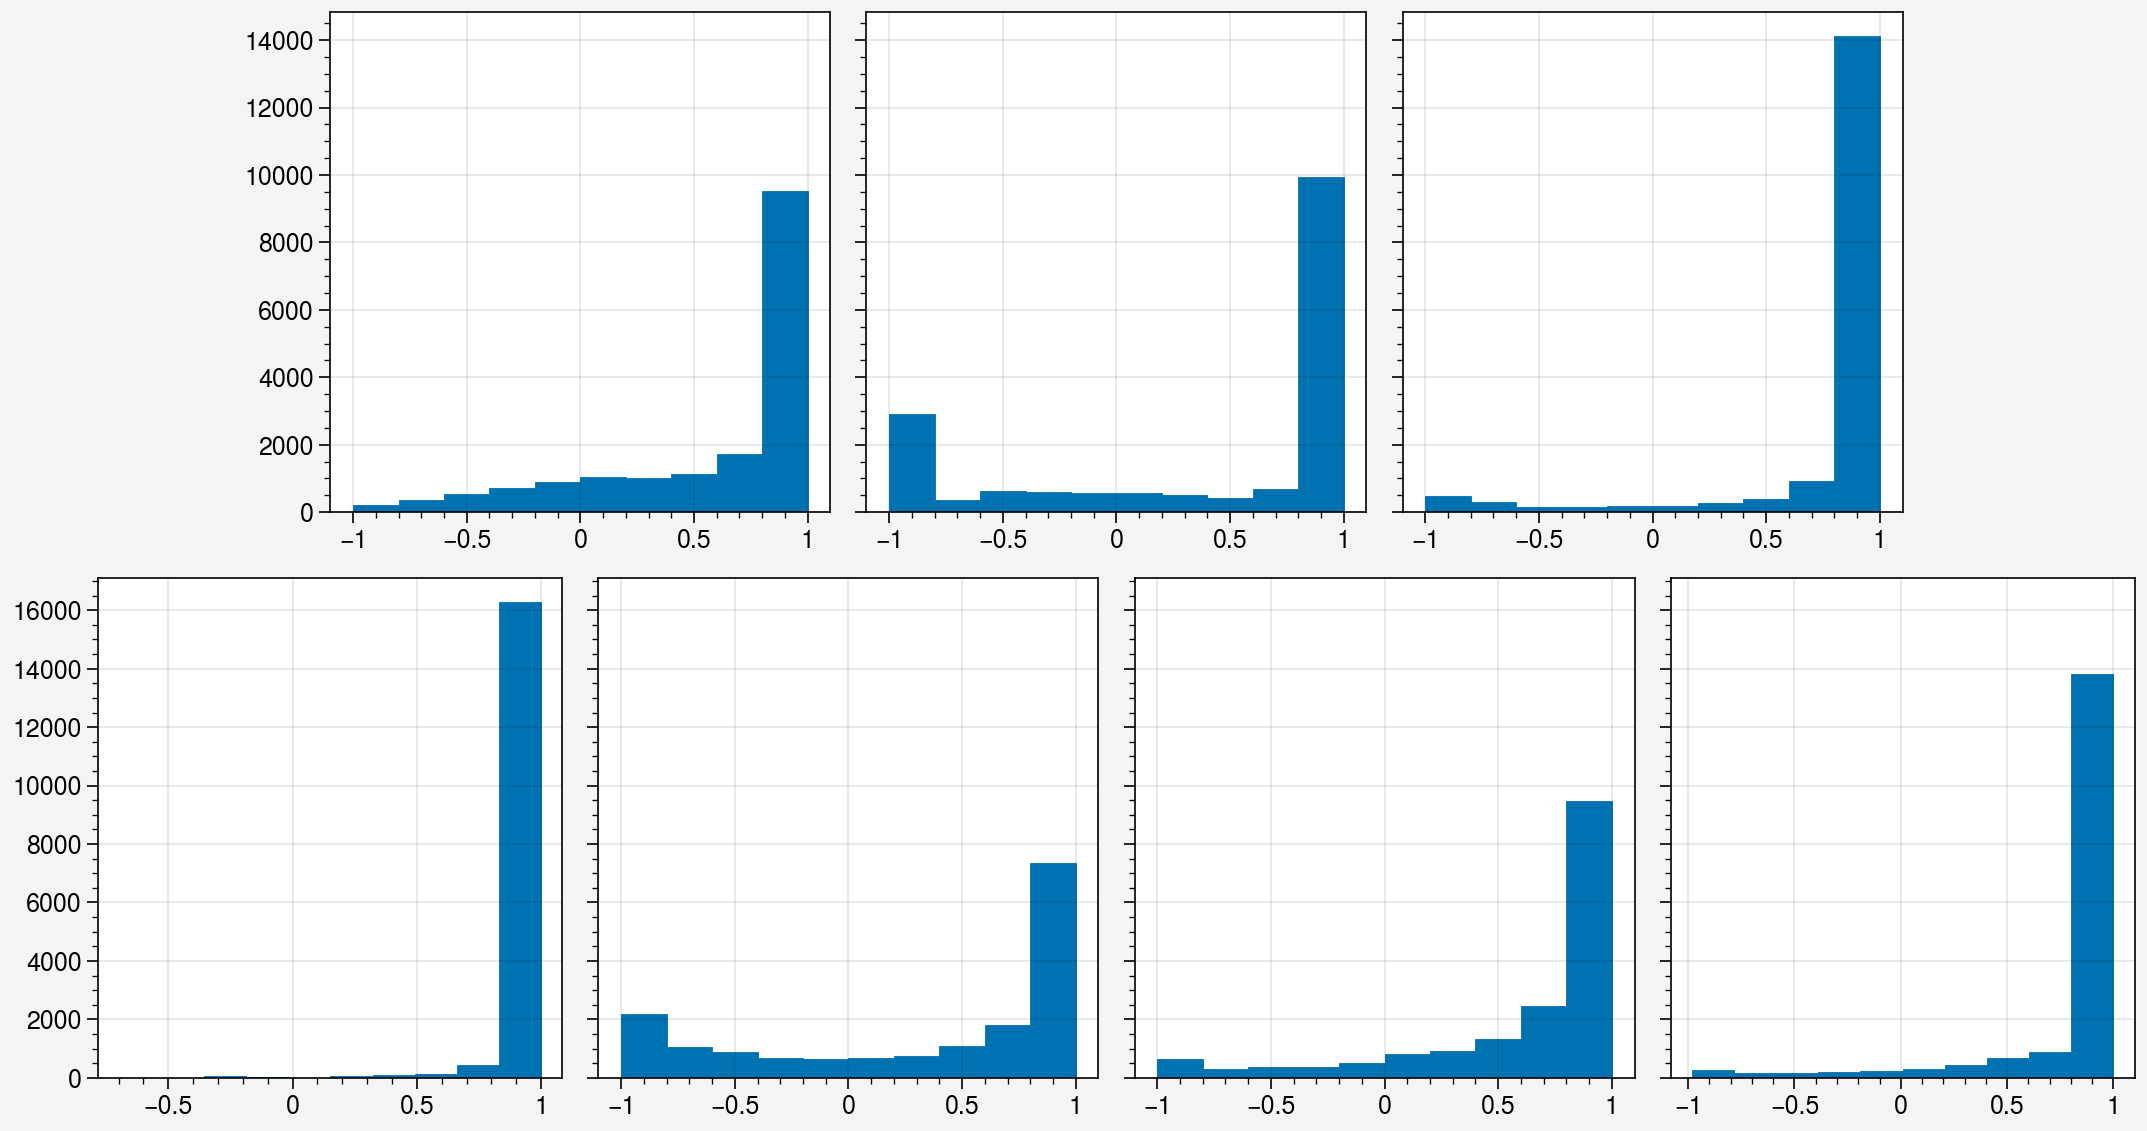

In [202]:
array = [[0, 1, 1, 2, 2, 3, 3, 0], [4, 4, 5, 5, 6, 6, 7, 7]]
fig, ax = pplt.subplots(array)

for i, chk in enumerate(chks):
    cs = np.vstack(chk_cos_sims[chk][512]).reshape(-1)
    ax[i].hist(cs)

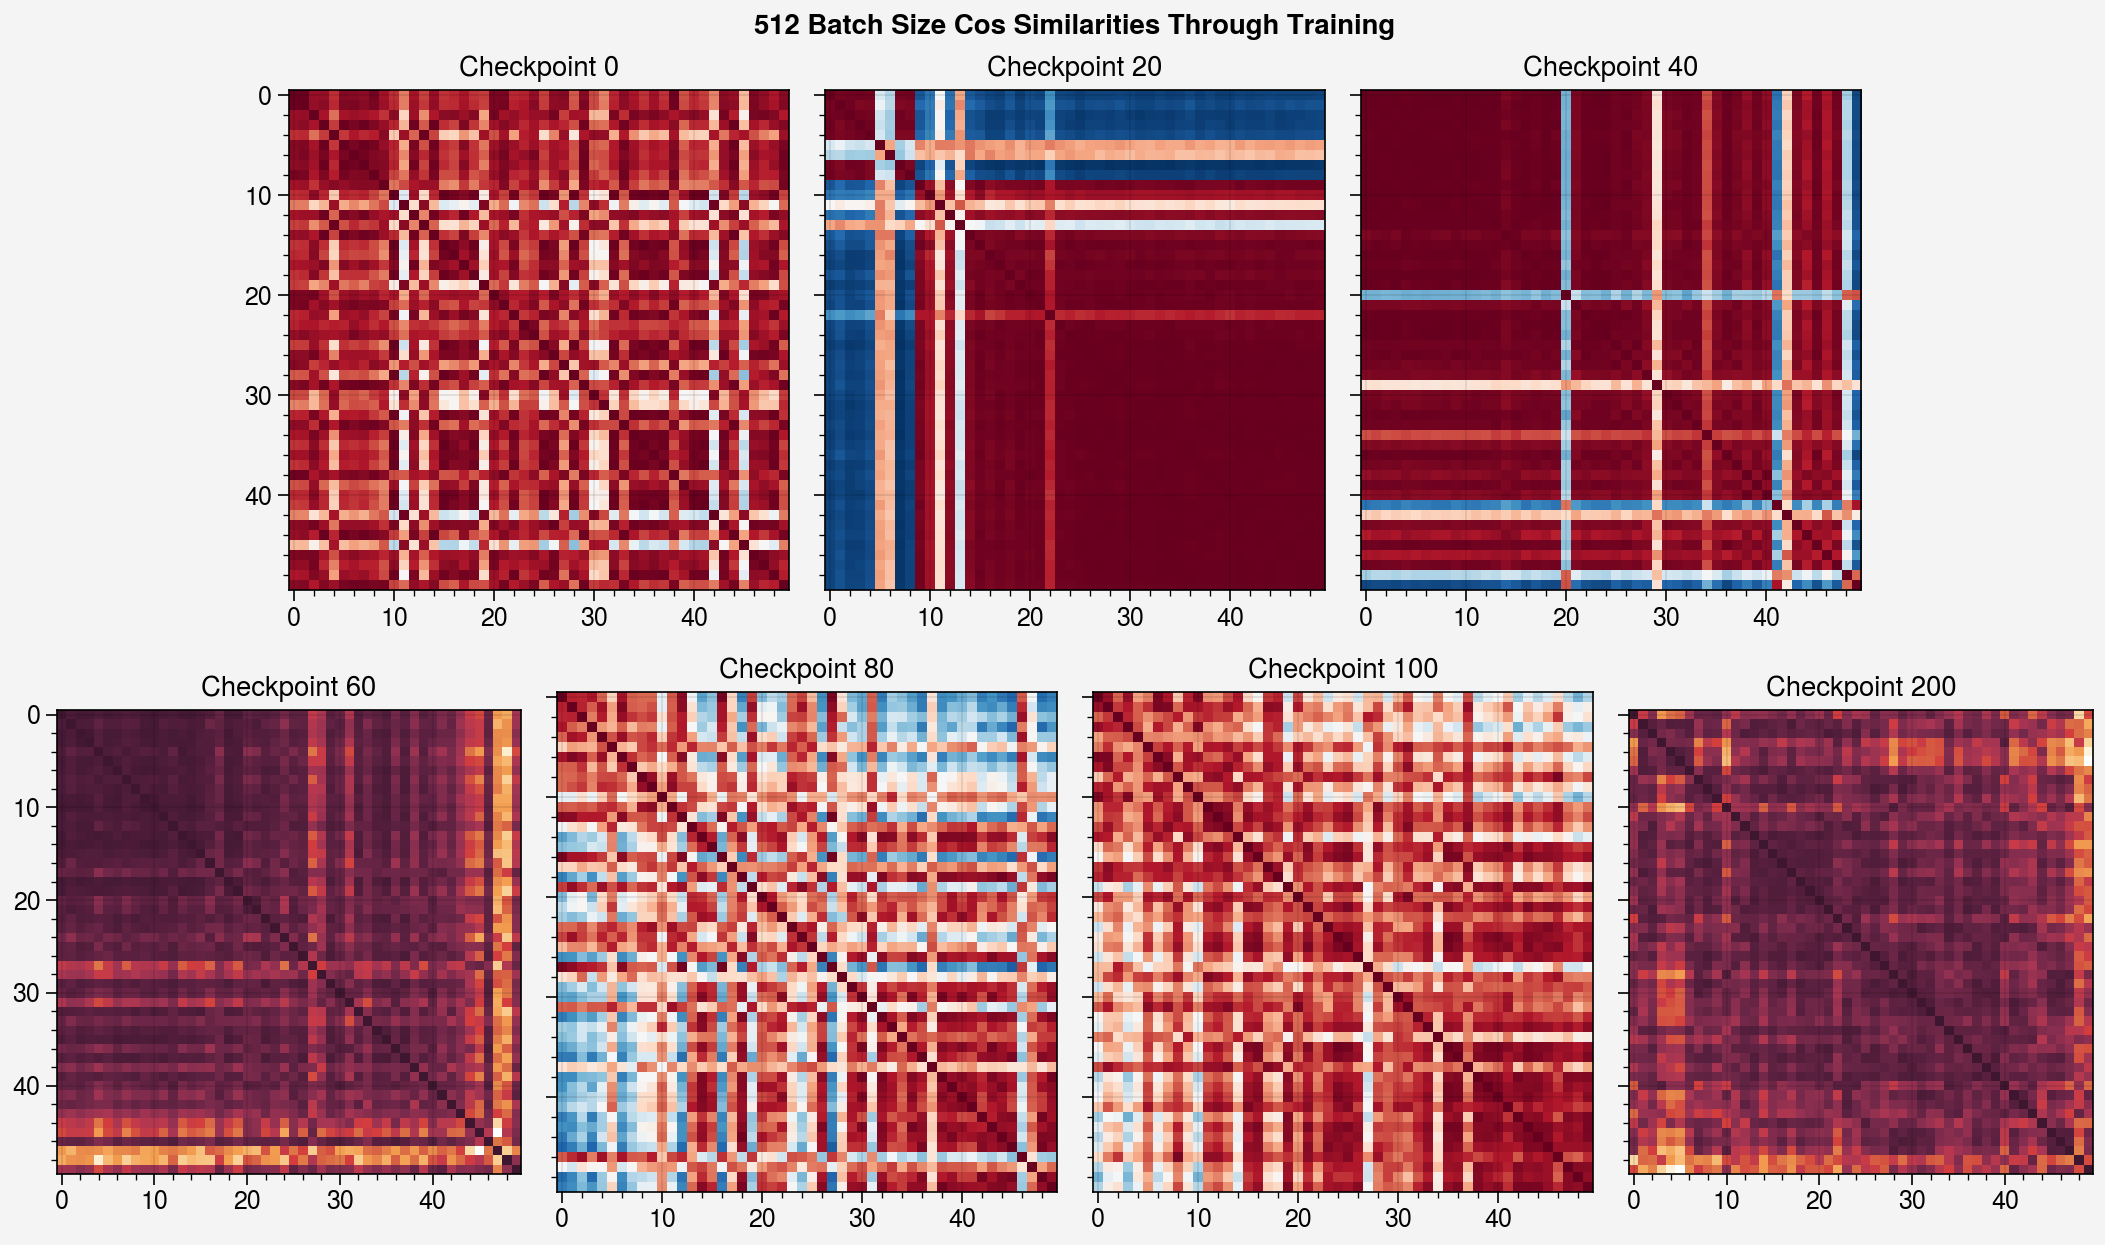

In [203]:
'''Example of batch cosine similarities for 512 through checkpoints'''
array = [[0, 1, 1, 2, 2, 3, 3, 0], [4, 4, 5, 5, 6, 6, 7, 7]]
fig, ax = pplt.subplots(array)
for i, chk in enumerate(chks):
    gr = torch.vstack(all_grads[chk][512][0]).reshape(-1, layer_sizes[0])
    ax[i].imshow(cosine_similarity(gr))
    # plt.colorbar()
ax.format(title=[f'Checkpoint {chk}' for chk in chks], suptitle='512 Batch Size Cos Similarities Through Training')

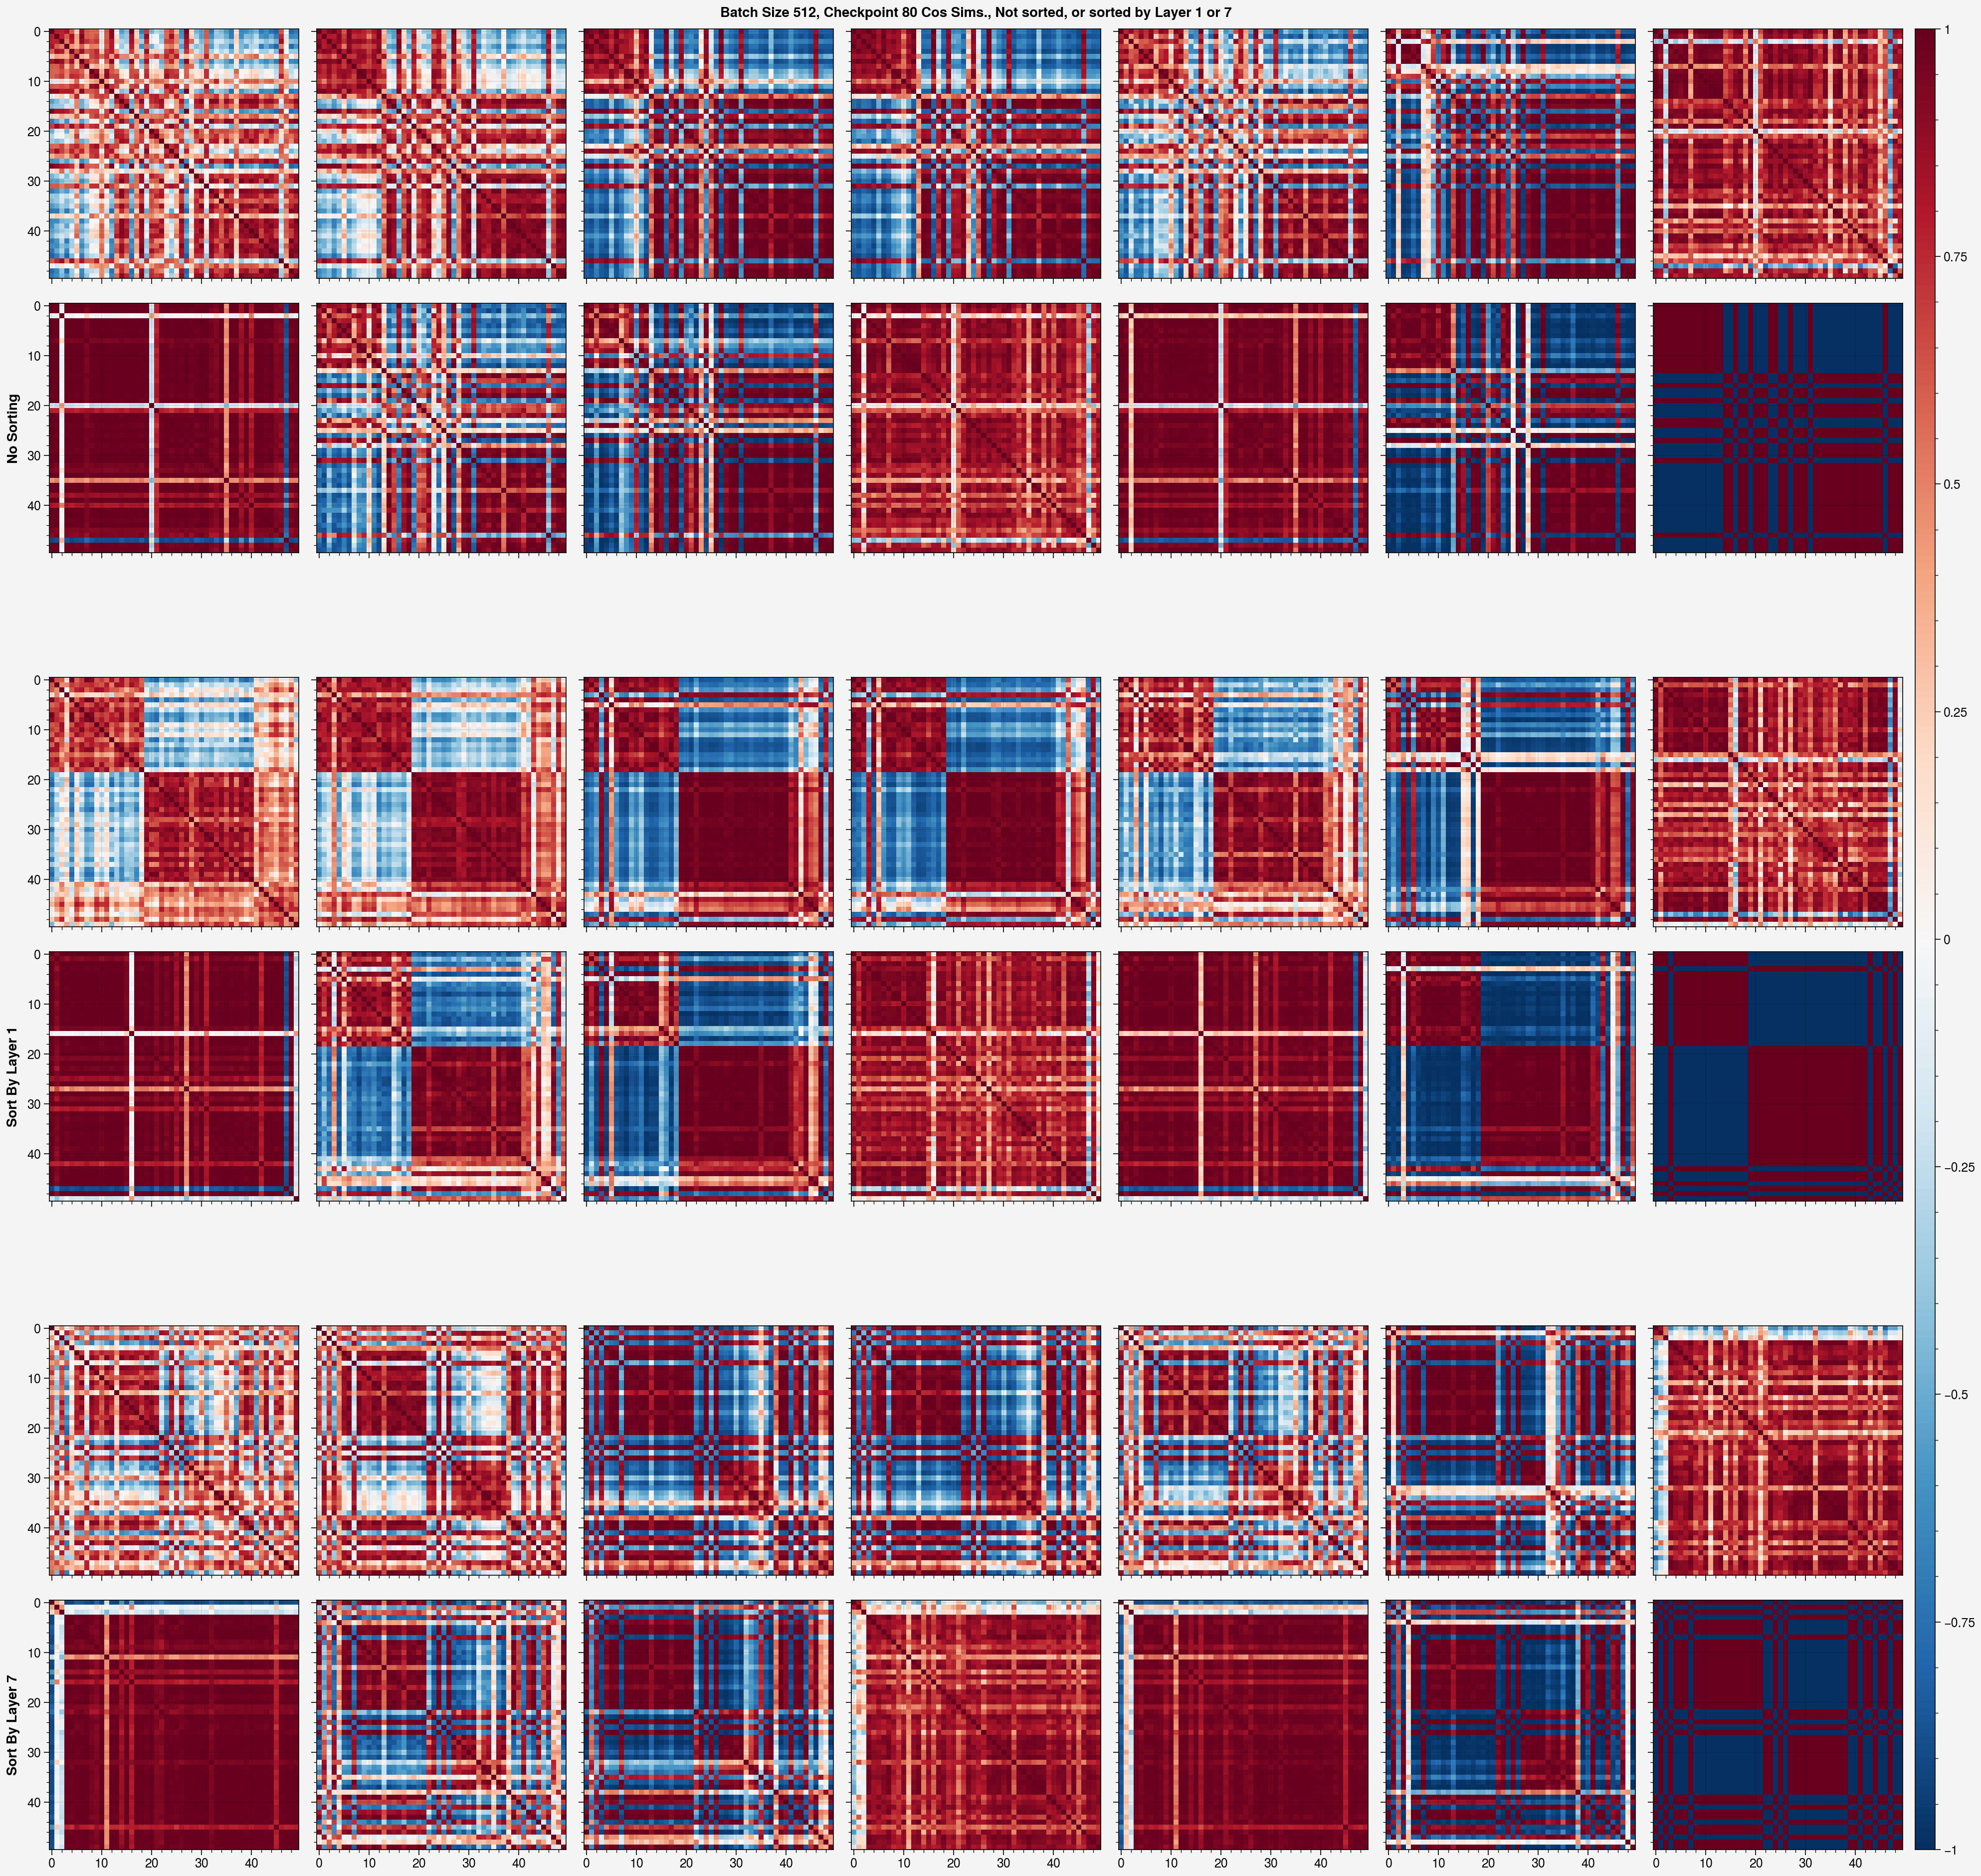

In [204]:
#sort by layer 0
chk = 80

gr = torch.vstack(all_grads[chk][512][0]).reshape(-1, layer_sizes[0])
cs = cosine_similarity(gr)
# idxs = np.argsort(np.sum(cs > 0, axis=0))
idxs = hierarchical_cluster(cs)

gr = torch.vstack(all_grads[chk][512][6]).reshape(-1, layer_sizes[6])
cs = cosine_similarity(gr)
idxs2 = hierarchical_cluster(cs)

fig, ax = pplt.subplots(nrows=6, ncols=7, hspace=(2, 10, 2, 10, 2))
for i in range(14):
    gr = torch.vstack(all_grads[chk][512][i]).reshape(-1, layer_sizes[i])
    bar = ax[i].imshow(cosine_similarity(gr))

for i in range(14):
    gr = torch.vstack(all_grads[chk][512][i]).reshape(-1, layer_sizes[i])[idxs]
    bar = ax[i+14].imshow(cosine_similarity(gr))

for i in range(14):
    gr = torch.vstack(all_grads[chk][512][i]).reshape(-1, layer_sizes[i])[idxs2]
    bar = ax[i+28].imshow(cosine_similarity(gr))
fig.colorbar(bar)
ax.format(suptitle='Batch Size 512, Checkpoint 80 Cos Sims., Not sorted, or sorted by Layer 1 or 7',
          leftlabels=['', 'No Sorting', '', 'Sort By Layer 1', '', 'Sort By Layer 7'])

### Success: Positive and negative value diff make a huge difference

Here, in the below layer we are sorting the gradients into those that were made with value_diff (predicted value - actual return) positive vs negative, and there is a clear separation of gradient. This indicates (and it makes sense) that when negative the gradient may in fact be mirrored, and so we see closer to a -1 cosine similarity. We should adjust for this by flipping the corresponding gradients (as the update step would also have the direction reversed in these cases)

Hopefully after correcting for this flipping, we still see improvement of cosine similarities for larger batch size

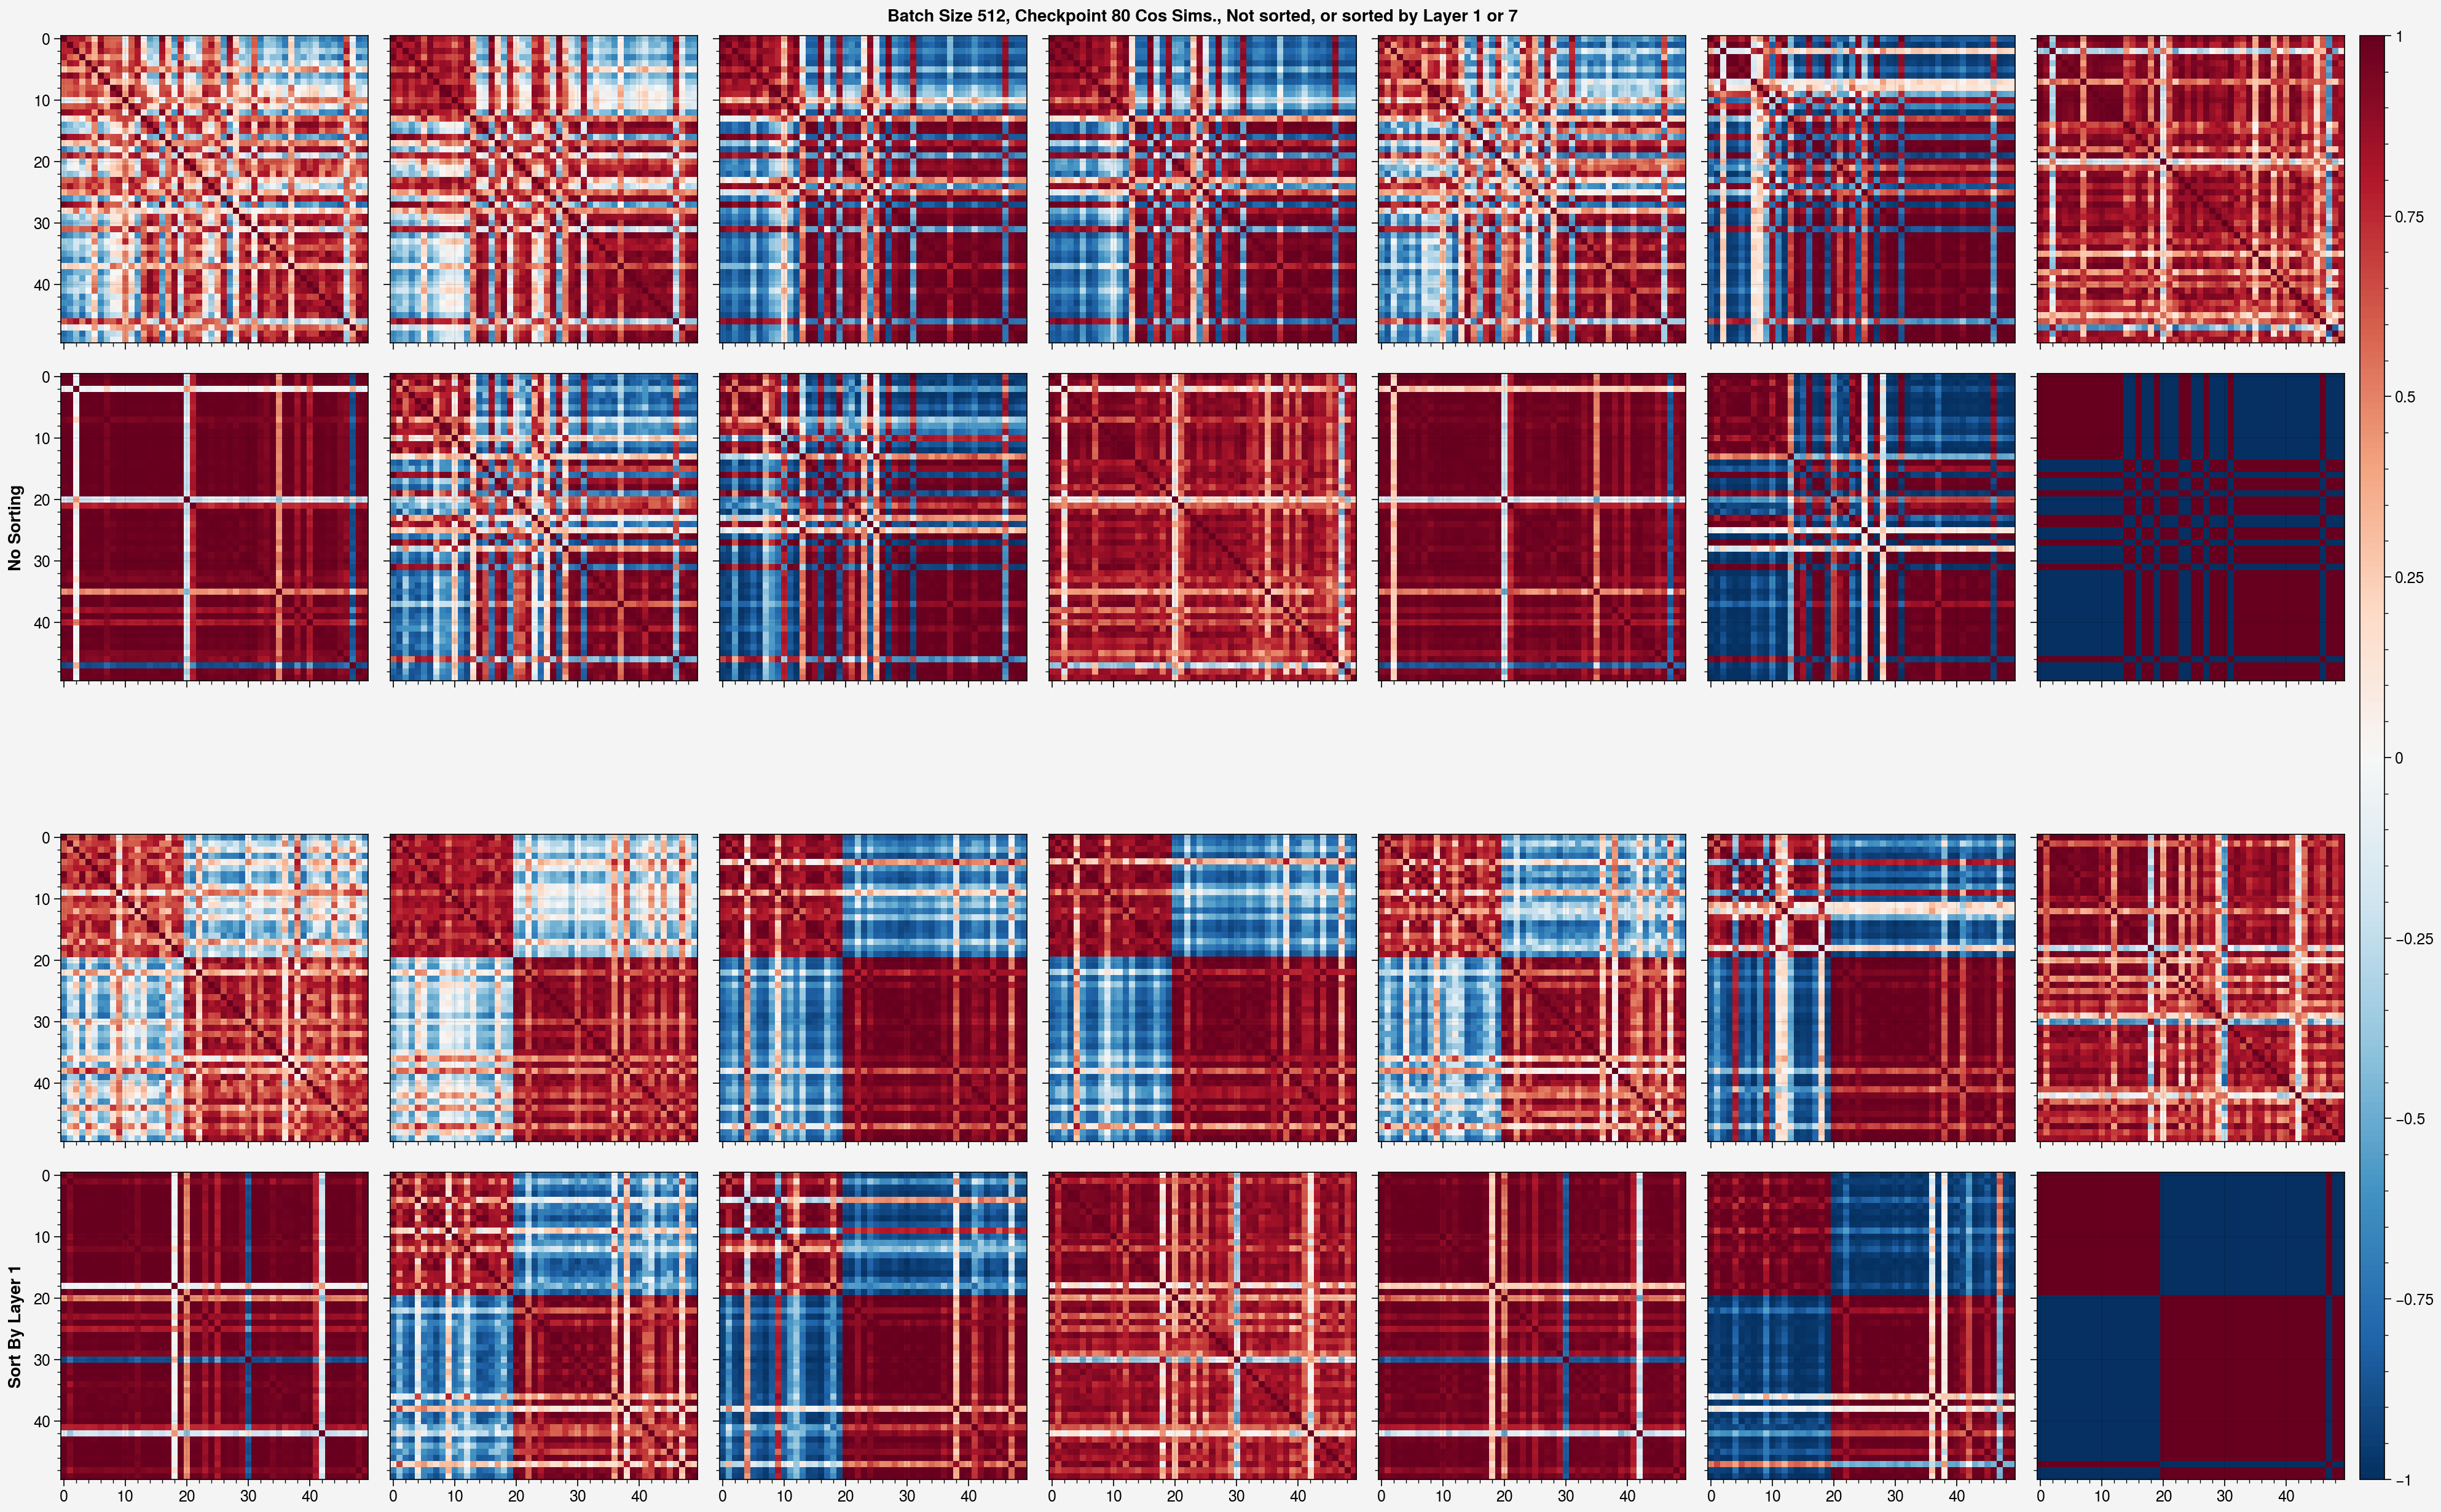

In [213]:
#sort by layer 0
chk = 80

gr = torch.vstack(all_grads[chk][512][0]).reshape(-1, layer_sizes[0])
cs = cosine_similarity(gr)
# idxs = np.argsort(np.sum(cs > 0, axis=0))
idxs = np.argsort(np.array(all_results['all_value_diffs'][80][512]) > 0)


fig, ax = pplt.subplots(nrows=4, ncols=7, hspace=(2, 10, 2))
for i in range(14):
    gr = torch.vstack(all_grads[chk][512][i]).reshape(-1, layer_sizes[i])
    bar = ax[i].imshow(cosine_similarity(gr))

for i in range(14):
    gr = torch.vstack(all_grads[chk][512][i]).reshape(-1, layer_sizes[i])[idxs]
    bar = ax[i+14].imshow(cosine_similarity(gr))

fig.colorbar(bar)
ax.format(suptitle='Batch Size 512, Checkpoint 80 Cos Sims., Not sorted, or sorted by Layer 1 or 7',
          leftlabels=['', 'No Sorting', '', 'Sort By Layer 1',])

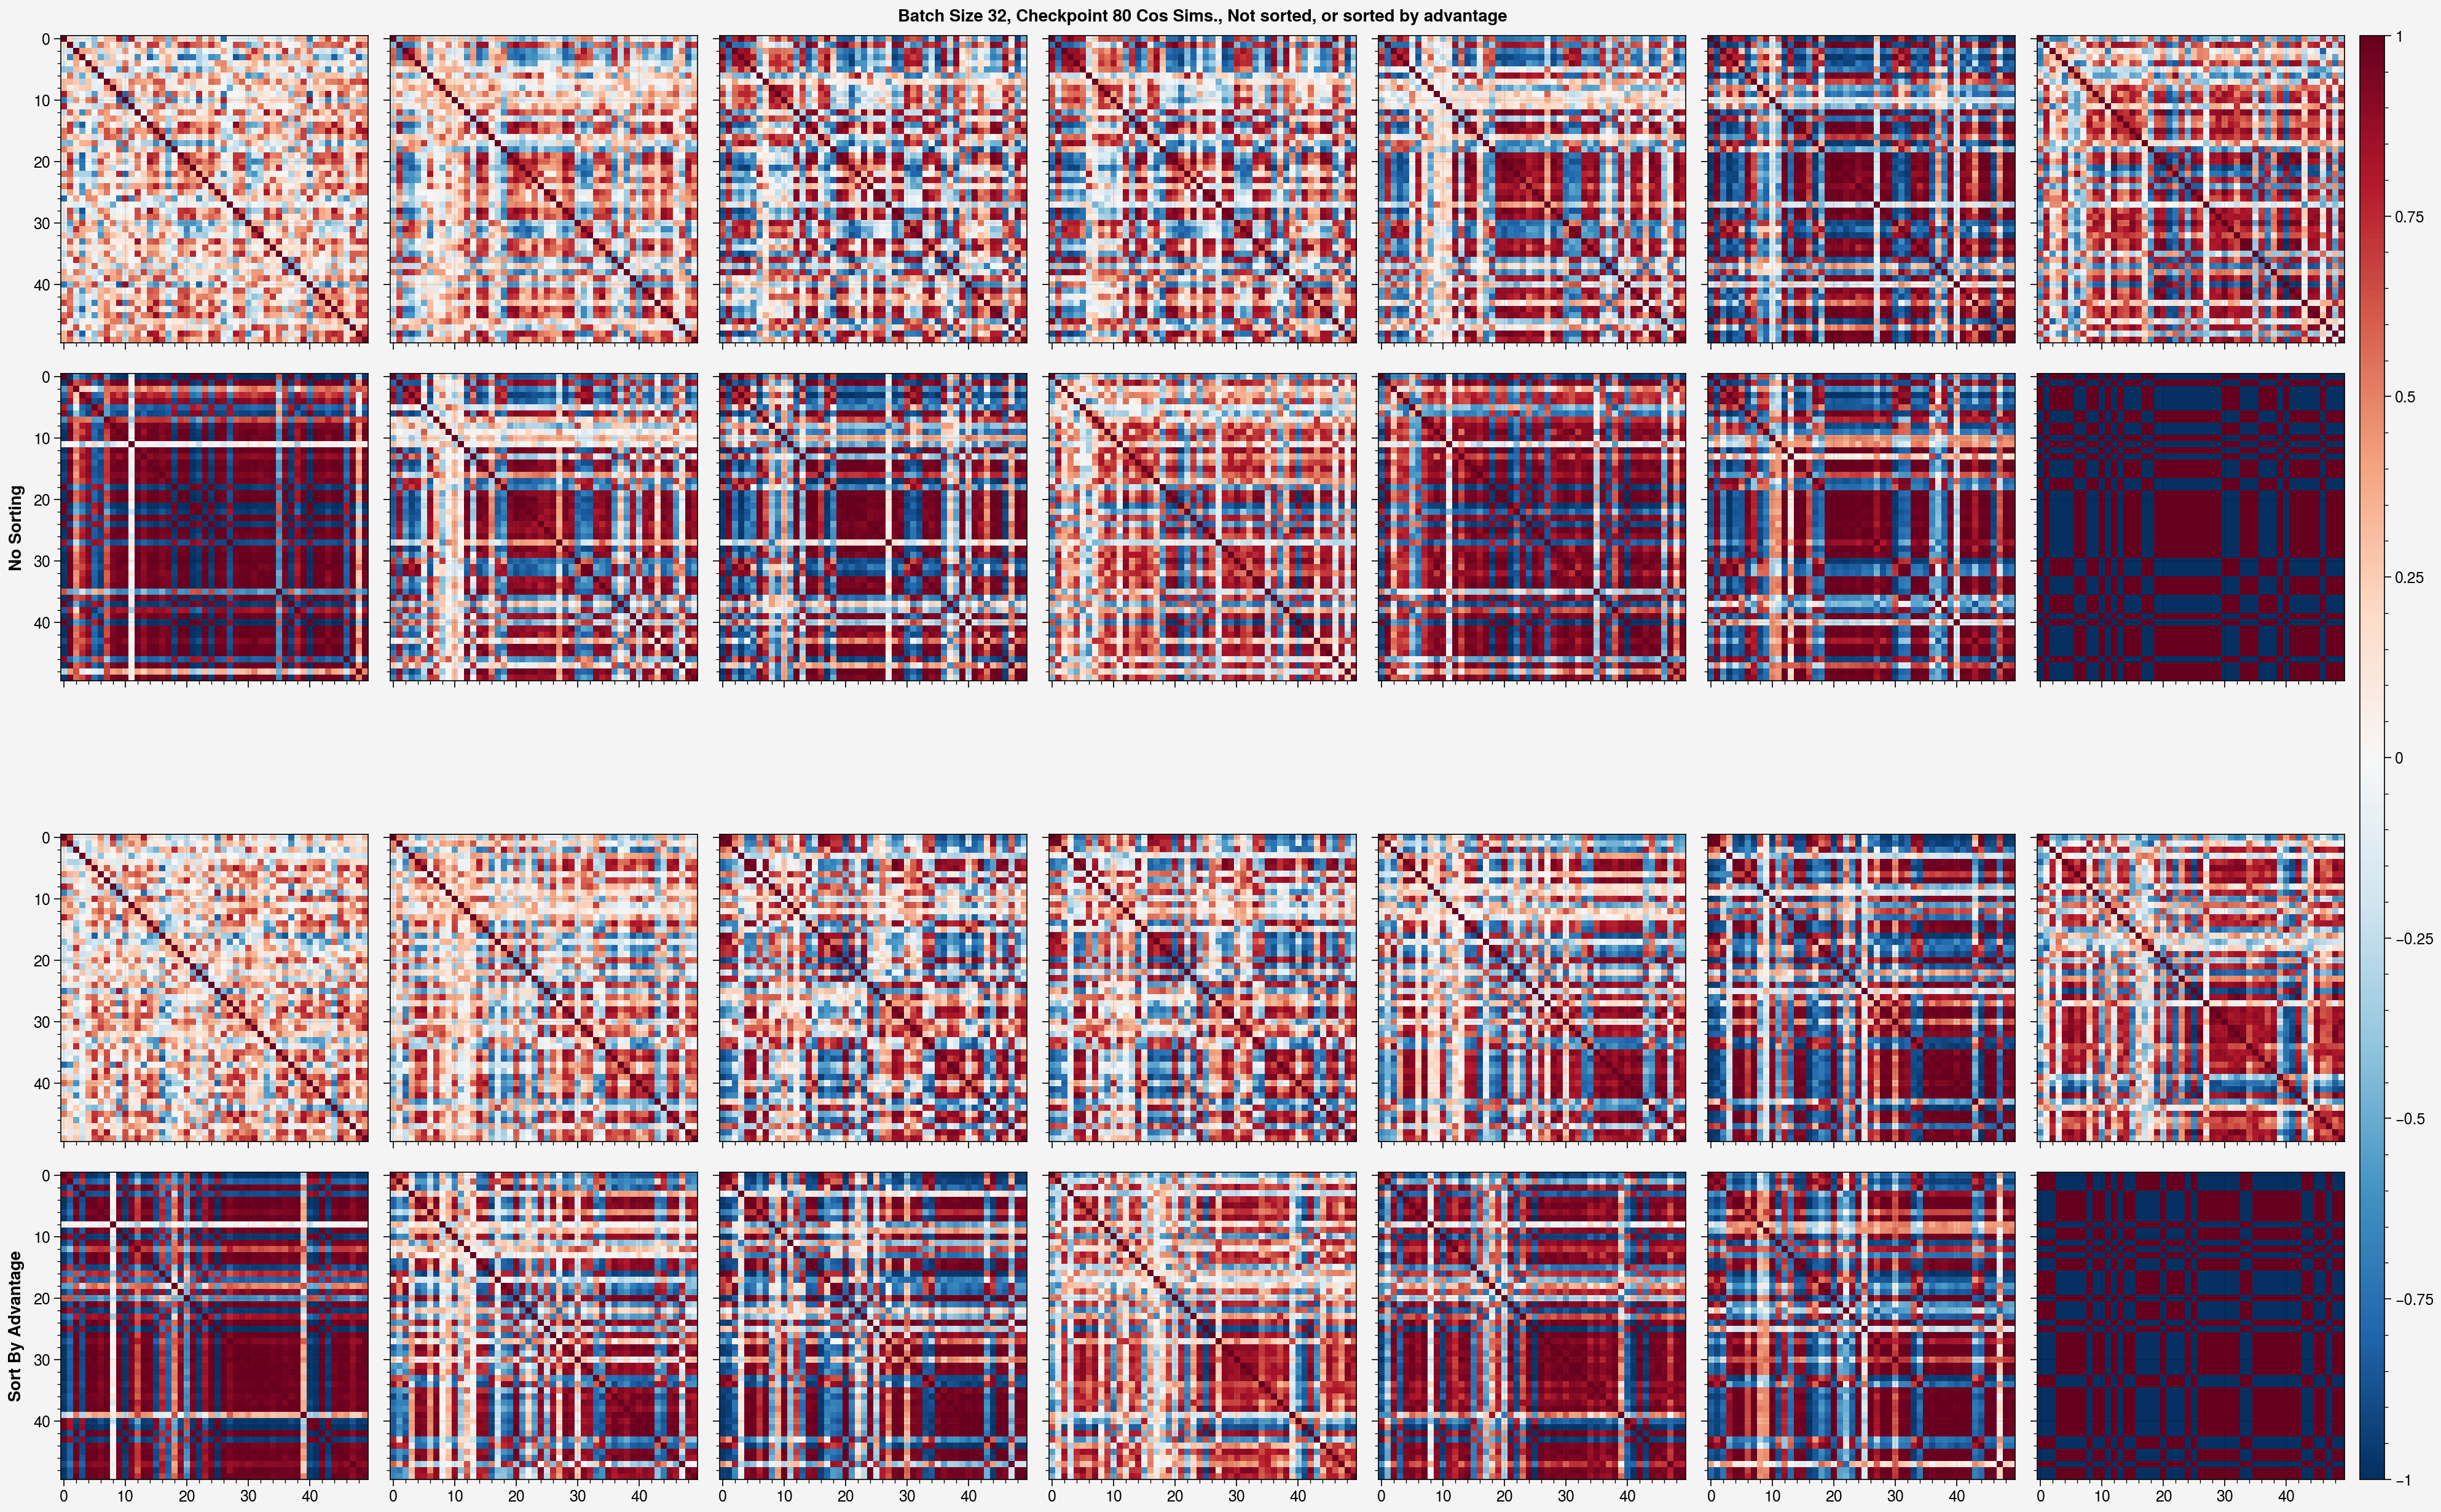

In [15]:
#sort by layer 0
chk = 80
batch_size = 32

gr = torch.vstack(all_grads[chk][batch_size][0]).reshape(-1, layer_sizes[0])
cs = cosine_similarity(gr)
# idxs = np.argsort(np.sum(cs > 0, axis=0))
idxs = np.argsort(np.array(all_results['all_value_diffs'][80][512]) > 0)


fig, ax = pplt.subplots(nrows=4, ncols=7, hspace=(2, 10, 2))
for i in range(14):
    gr = torch.vstack(all_grads[chk][batch_size][i]).reshape(-1, layer_sizes[i])
    bar = ax[i].imshow(cosine_similarity(gr))

for i in range(14):
    gr = torch.vstack(all_grads[chk][batch_size][i]).reshape(-1, layer_sizes[i])[idxs]
    bar = ax[i+14].imshow(cosine_similarity(gr))

fig.colorbar(bar)
ax.format(suptitle=f'Batch Size {batch_size}, Checkpoint 80 Cos Sims., Not sorted, or sorted by advantage',
          leftlabels=['', 'No Sorting', '', 'Sort By Advantage',])

Here we are simply plotting out the value differences. I could not figure out why there should be any nonrandom correlation between batch order and the value differences. This was also seen in the number of rewards in each batch.

One might notice that for checkpoints where value diff varies about the 0 value most, we see the largest sudden increases in differences between gradients

This then indicates why the same checkpoints would have sudden increases in cosine difference between batches, as it was a phenomenon of the checkpointed model itself having a more accurate value prediction for the policy that it had at the time

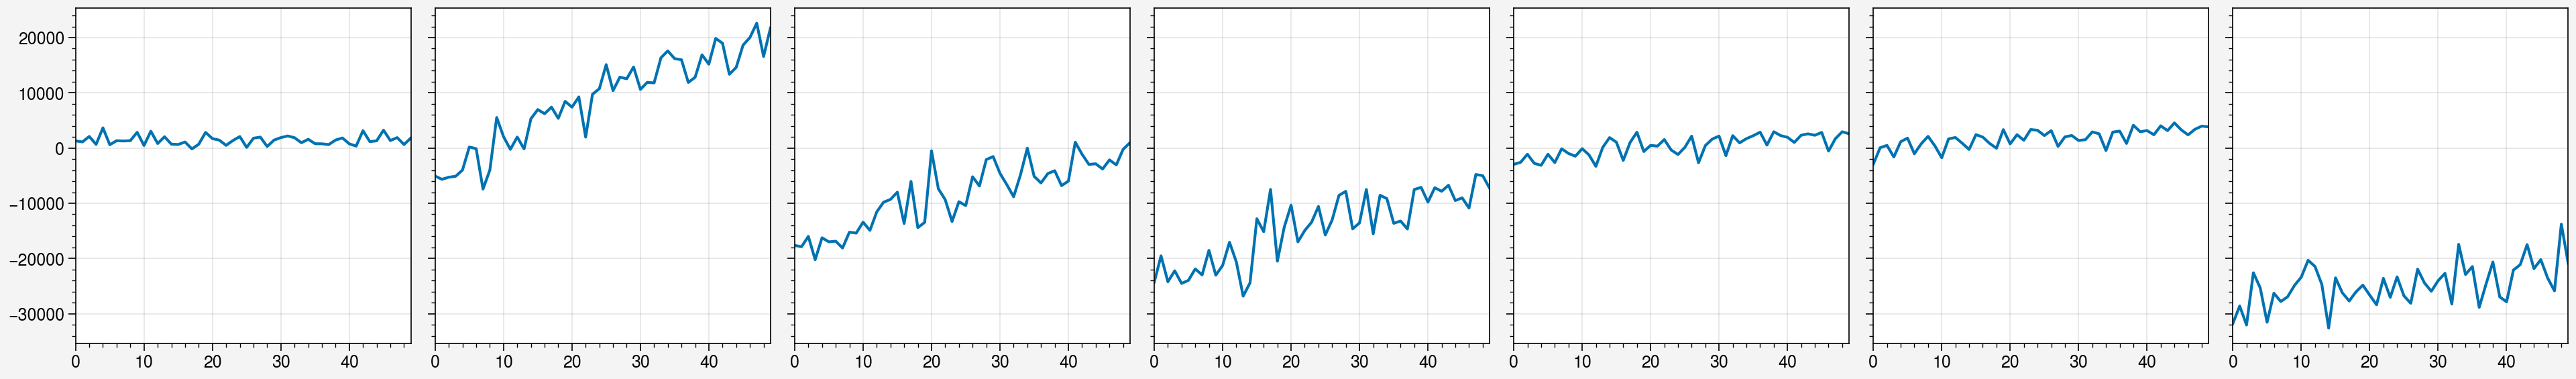

In [206]:
all_results['all_value_diffs'][80][512]
fig, ax = pplt.subplots(ncols=7)

for i, chk in enumerate(chks):
    ax[i].plot(all_results['all_value_diffs'][chk][512])

### Correcting cosine similarities for negative and positive gradients

After comparing cosine similarities with positive value_diffs to each other and negative to each other, we get a less varied spread of cosine similarities which make the picture nicer

In [273]:
css = []
css2 = []
for layer in range(14):
    pos_idxs = np.array(all_results['all_value_diffs'][80][512]) > 0
    
    gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer]).numpy()
    
    cs = cosine_similarity(gr)
    triu_idxs = np.triu(np.ones(cs.shape), k=1)
    
    gr1 = gr[pos_idxs]
    gr2 = gr[~pos_idxs]
    cs1 = np.triu(cosine_similarity(gr1), k=1)
    cs2 = np.triu(cosine_similarity(gr2), k=1)
    cs1 = cs1[cs1 != 0]
    cs2 = cs2[cs2 != 0]
    
    cs_comb = np.concatenate([cs1, cs2])
    
    print(np.mean(cs[triu_idxs != 0]), np.mean(cs_comb))
    css.append(np.mean(cs[triu_idxs != 0]))
    # css2.append(np.mean(cs2[triu_idxs != 0]))


0.27783617 0.6338543
0.35059002 0.7867052
0.1937783 0.85592717
0.17963865 0.85071874
0.18422091 0.67741174
0.15931295 0.77000886
0.63898283 0.6245546
0.78665495 0.77058613
0.1329068 0.72806036
0.10717873 0.79239905
0.7040719 0.6889489
0.7916424 0.77393454
0.014274989 0.80474836
0.0057142857 0.9072


In [ ]:
'''
NEW
Compute pairwise cosine similarities across batches of gradients
    *Corrected version for positive and negative value_diffs
'''
chk_cos_sims = {chk: {} for chk in chks}

layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        pos_idxs = np.array(all_results['all_value_diffs'][chk][batch_size]) > 0
        chk_cos_sims[chk][batch_size] = []
        for layer in range(14):
            cos_sims = []

            gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer]).numpy()    
            gr1 = gr[pos_idxs]
            gr2 = gr[~pos_idxs]
            if len(gr1) > 0:
                cs1 = np.triu(cosine_similarity(gr1), k=1)
                cs1 = cs1[cs1 != 0]
            else:
                cs1 = np.array([])
            
            if len(gr2) > 0:
                cs2 = np.triu(cosine_similarity(gr2), k=1)
                cs2 = cs2[cs2 != 0]
            else:
                cs2 = np.array([])
            cs_comb = np.concatenate([cs1, cs2])

            chk_cos_sims[chk][batch_size].append(list(cs_comb))

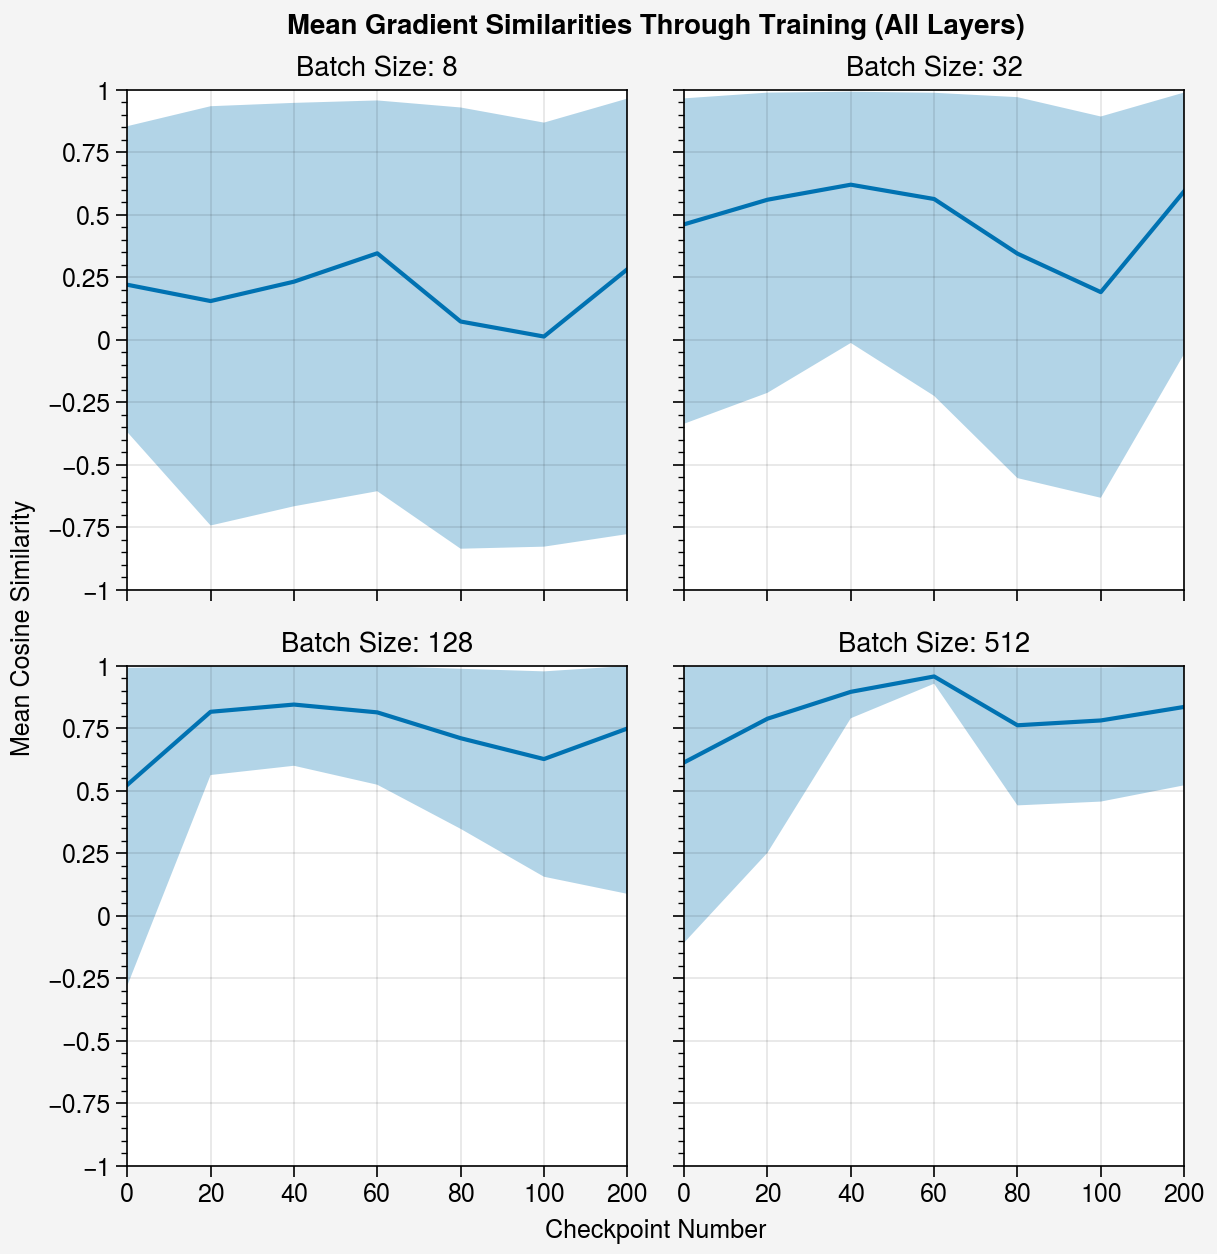

In [281]:

fig, ax = pplt.subplots(nrows=2, ncols=2, share=True)
for n, batch_size in enumerate(batch_sizes):
# for n, batch_size in enumerate([128]):
    xs = []
    ys = []
    stds = []
    lows = []
    highs = []
    
    num_batches = len(all_grads[chk][batch_size][layer])
    for x, chk in enumerate(chks):
        cos_sims = np.vstack(chk_cos_sims[chk][batch_size]).reshape(-1)
        
        xs.append(x)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
    # ax[n].hist(cos_sims)
    ax[n].plot(xs, ys)
    ax[n].fill_between(xs, lows, highs, alpha=0.3)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Mean Gradient Similarities Through Training (All Layers, Pos/Neg Value Diff Corrected)',
          ylim=[-1., 1.],
          xlocator=range(7),
          xticklabels=[str(chk) for chk in chks],
          xlabel='Checkpoint Number',
          ylabel='Mean Cosine Similarity')


## Similarity between small batches and larger ones

Here we see again as hoped that even with randomly taken 2048 batches, larger batches 8 > 32 > 128 > 512 will generally have more gradient similarities to those 2048 batches

In [286]:
chk_ref_cos_sims = {chk: {} for chk in chks}
layer_sizes = [len(all_grads[0][8][layer][0].reshape(-1)) for layer in range(14)]

for chk in tqdm(chks):
    for batch_size in batch_sizes:
        chk_ref_cos_sims[chk][batch_size] = []
        pos_idxs = np.array(all_results['all_value_diffs'][chk][batch_size]) > 0
        pos_idxs_ref = np.array(ref_results['ref_value_diffs'][chk]) > 0

        for layer in range(14):
            gr = torch.vstack(all_grads[chk][batch_size][layer]).reshape(-1, layer_sizes[layer]).numpy()    
            gr_ref = torch.vstack(ref_grads[chk][layer]).reshape(-1, layer_sizes[layer]).numpy()    

            gr1 = gr[pos_idxs]
            gr2 = gr[~pos_idxs]
            gr1_ref = gr_ref[pos_idxs_ref]
            gr2_ref = gr_ref[~pos_idxs_ref]
            
            if len(gr1) > 0 and len(gr1_ref) > 0:
                cs1 = cosine_similarity(gr1, gr1_ref)
                cs1 = np.vstack(cs1).reshape(-1)
            else:
                cs1 = np.array([])
            
            if len(gr2) > 0 and len(gr2_ref) > 0:
                cs2 = cosine_similarity(gr2, gr2_ref)
                cs2 = np.vstack(cs2).reshape(-1)
            else:
                cs2 = np.array([])
            
            cs_comb = np.concatenate([cs1, cs2])
            chk_ref_cos_sims[chk][batch_size].append(list(cs_comb))



100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.66it/s]


Checkpoint 60 batch_size 8 had no matches with ref
Checkpoint 200 batch_size 8 had no matches with ref


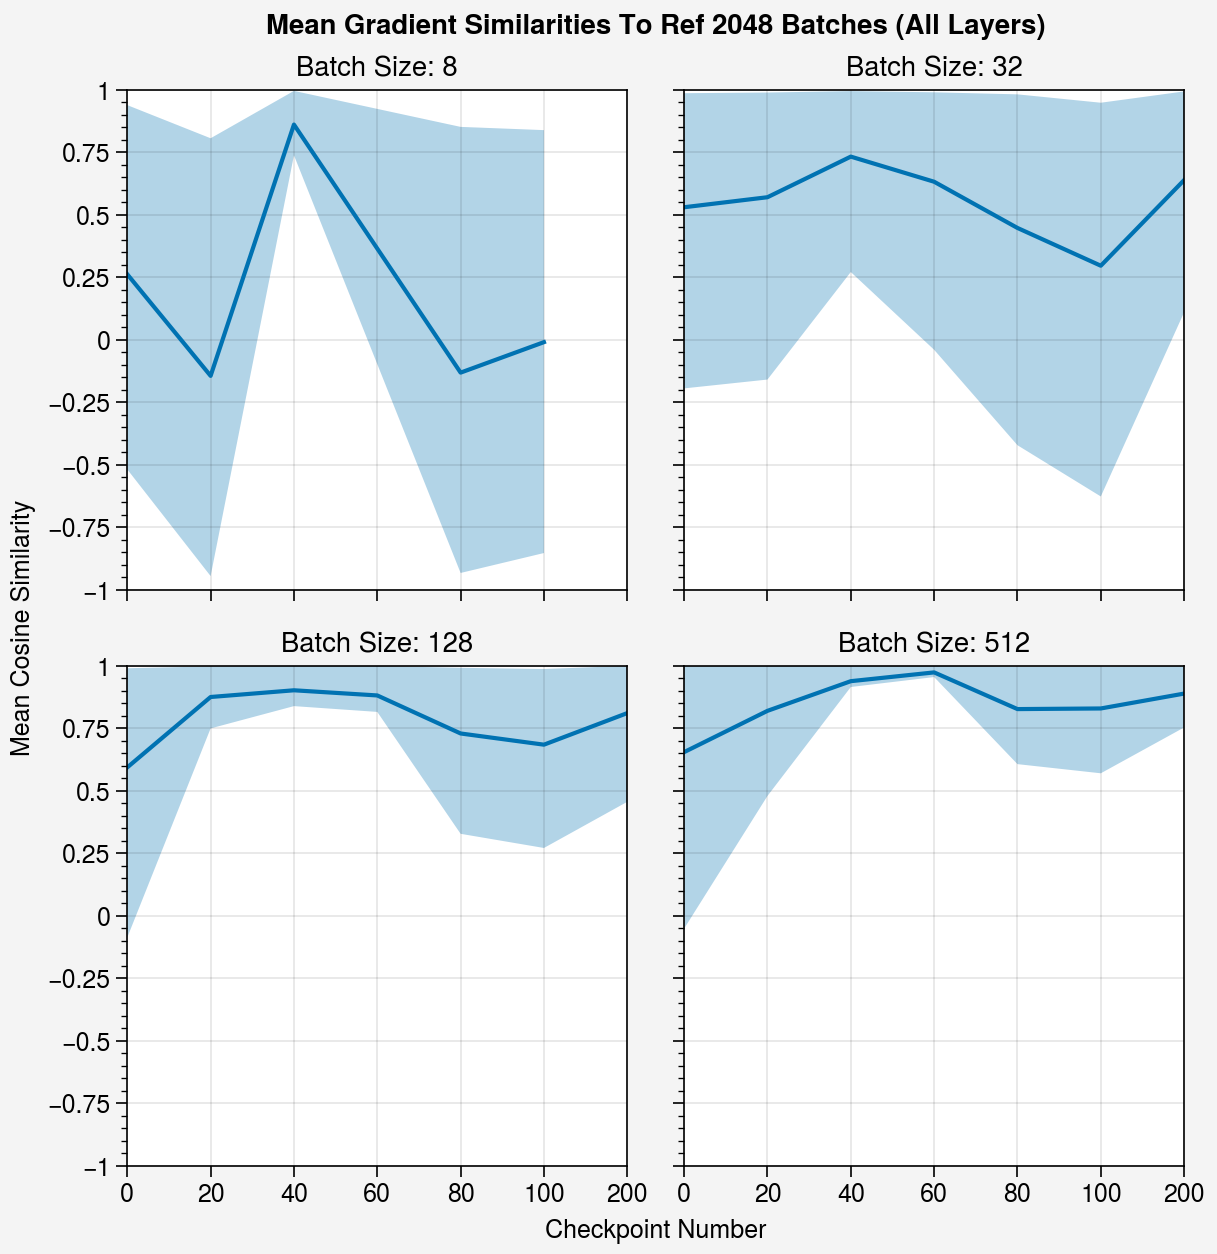

In [307]:

fig, ax = pplt.subplots(nrows=2, ncols=2, share=True)
for n, batch_size in enumerate(batch_sizes):
# for n, batch_size in enumerate([128]):
    xs = []
    ys = []
    stds = []
    lows = []
    highs = []
    
    for x, chk in enumerate(chks):
        cos_sims = np.vstack(chk_ref_cos_sims[chk][batch_size]).reshape(-1)
        
        if len(cos_sims) < 1:
            print(f'Checkpoint {chk} batch_size {batch_size} had no matches with ref')
        else:
            xs.append(x)
            ys.append(np.mean(cos_sims))
            lows.append(np.percentile(cos_sims, 12.5))
            highs.append(np.percentile(cos_sims, 87.5))
            stds.append(np.std(cos_sims))
    # ax[n].hist(cos_sims)
    ax[n].plot(xs, ys)
    ax[n].fill_between(xs, lows, highs, alpha=0.3)
    
ax.format(title=[f'Batch Size: {batch_size}' for batch_size in batch_sizes],
          suptitle='Mean Gradient Similarities To Ref 2048 Batches (All Layers)',
          ylim=[-1., 1.],
          xlocator=range(7),
          xticklabels=[str(chk) for chk in chks],
          xlabel='Checkpoint Number',
          ylabel='Mean Cosine Similarity')


# Checking how the gradients of auxiliary tasks compares to that of large batch size reward gradient updates

Now we want to see whether auxiliary tasks help in low batch size scenarios. We want the auxiliary tasks then to show a higher cosine similarity to large batch gradient updates as compared with the original small batch gradient update

## Data Collection

### Original data collection for 4.2.1 showing trained model grad sim across batch sizes

In [29]:
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']
batch_sizes = [8, 32, 128, 512]
# batch_sizes = [128]

num_processes = 16
num_batches = 20
trial = 2

all_grads = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}
all_rewarded = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}
all_rewards = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}
all_value_losses = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}
all_action_losses = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}
all_value_diffs = {aux: {batch: [] for batch in batch_sizes} for aux in aux_tasks}


for aux in tqdm(aux_tasks):
    model_name = f'nav_pdistal_widthaux/nav_pdistal_width16aux{aux}'
    model, obs_rms, env_kwargs = load_model_and_env(model_name, trial)
    agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                        take_optimizer_step=False)

    #Need to generate a new set of environments for each set of auxiliary tasks since they
    #environments output different auxiliary_truth values
    envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                        False, env_kwargs=env_kwargs)
    obs = envs.reset()
    
    for batch in batch_sizes:
        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)

        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches, 
                                        decompose_grads=True)
        
        all_grads[aux][batch] = res['all_grads']
        all_rewarded[aux][batch] = res['rewarded']
        all_rewards[aux][batch] = res['rewards']
        all_value_losses[aux][batch] = res['value_losses']
        all_action_losses[aux][batch] = res['action_losses']
        all_value_diffs[aux][batch] = res['value_diff']

        obs = rollouts.obs[-1]
        
all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open(f'data/grads/width16auxt{trial}_grads', 'wb'))

  0%|                                                                                            | 0/4 [00:48<?, ?it/s]

KeyboardInterrupt



### Data collection for fresh agents
No prior training, 20 batches each of 128 batch size (16 num_processes), including goaldist_c (goal distance task but on critic side instead of actor side).

In [44]:
'''
Same data collection but for new untrained agents rather than trained ones
'''

aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']
auxiliary_tasks = [[3], [3], [2], [2], [2, 2]]
auxiliary_task_args = [[None], [None], [0], [1], [0, 1]]
auxiliary_heads = [
    [[-1, 0, 1]],
    [[-1, 1, 1]], # auxiliary output pinned to critic side
    [[-1, 0, 1]],
    [[-1, 0, 1]],
    [[-1, 0, 1], [-1, 0, 1]],
]
trials = 20
batch = 128

num_processes = 16
num_batches = 20

all_grads = {aux: [[] for _ in range(trials)] for aux in aux_tasks}
all_rewarded = {aux: [[] for _ in range(trials)] for aux in aux_tasks}
all_rewards = {aux: [[] for _ in range(trials)] for aux in aux_tasks}
all_value_losses = {aux: [[] for _ in range(trials)] for aux in aux_tasks}
all_action_losses = {aux: [[] for _ in range(trials)] for aux in aux_tasks}
all_value_diffs = {aux: [[] for _ in range(trials)] for aux in aux_tasks}

for i, aux in enumerate(aux_tasks):
    aux_task = auxiliary_tasks[i]
    aux_args = auxiliary_task_args[i]
    aux_heads = auxiliary_heads[i]

    env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, 'character_reset_pos': 1,
              'auxiliary_tasks': aux_task, 'auxiliary_task_args': aux_args}
    env = gym.make('NavEnv-v0', **env_kwargs)
    nn_base_kwargs = {'hidden_size': 16, 'auxiliary_heads': aux_heads}
    envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                        False, env_kwargs=env_kwargs)
    obs = envs.reset()
    
    for t in tqdm(range(trials)):

        torch.manual_seed(t)
        model = Policy(env.observation_space.shape,
                       env.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': True, **nn_base_kwargs})
        model.to(device)
        agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            take_optimizer_step=False)

        #Need to generate a new set of environments for each set of auxiliary tasks since they
        #environments output different auxiliary_truth values


        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)

        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches, 
                                        decompose_grads=True)

        all_grads[aux][t] = res['all_grads']
        all_rewarded[aux][t] = res['rewarded']
        all_rewards[aux][t] = res['rewards']
        all_value_losses[aux][t] = res['value_losses']
        all_action_losses[aux][t] = res['action_losses']
        all_value_diffs[aux][t] = res['value_diff']

        obs = rollouts.obs[-1]

all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/width16fresh_aux_grads', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:14<00:00, 15.75s/it]


### 128 batch mass collection for trained

Sicne we found that we only really need to test 20 batches of 128, here we are testing trained agents of each auxiliary task type. Uses trained agents from nav_pdistal_batchaux, where we have agents trained on different batch sizes so that we have different agents

In [295]:
batch = 32
model_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}auxwall0'
model, _, _ = load_model_and_env(model_name, 1)
a = list(model.parameters())[0]

In [296]:
batch = 128
model_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}auxwall0'
model, _, _ = load_model_and_env(model_name, 1)
b = list(model.parameters())[0]

In [297]:
a = a.detach().numpy().reshape(1, -1)
b = b.detach().numpy().reshape(1, -1)

In [298]:
cosine_similarity(a, b)

array([[0.4860564]], dtype=float32)

In [311]:
'''
Data collection for multiple different trained agents
'''

aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']
# aux_tasks = ['wall0']
num_trials = 5
batch_sizes = [32, 128]
# num_trials = 1
# batch_sizes = [32]
num_processes = 16

all_grads = {aux: [] for aux in aux_tasks}
all_rewarded = {aux: [] for aux in aux_tasks}
all_rewards = {aux: [] for aux in aux_tasks}
all_value_losses = {aux: [] for aux in aux_tasks}
all_action_losses = {aux: [] for aux in aux_tasks}
all_value_diffs = {aux: [] for aux in aux_tasks}

for i, aux in enumerate(tqdm(aux_tasks)):
    kwarg_file_name = f'../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}_env'
    env_kwargs = pickle.load(open(kwarg_file_name, 'rb'))
    env = gym.make('NavEnv-v0', **env_kwargs)
    envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                        False, env_kwargs=env_kwargs)
    obs = envs.reset()
    
    for batch in batch_sizes:
        for t in range(num_trials):
            model_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
            model, _, _ = load_model_and_env(model_name, t)
            agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                                take_optimizer_step=False)

            #Need to generate a new set of environments for each set of auxiliary tasks since they
            #environments output different auxiliary_truth values


            rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                      model.recurrent_hidden_state_size, model.auxiliary_output_size)
            rollouts.obs[0].copy_(obs)

            res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches, 
                                            decompose_grads=True)

            all_grads[aux].append(res['all_grads'])
            all_rewarded[aux].append(res['rewarded'])
            all_rewards[aux].append(res['rewards'])
            all_value_losses[aux].append(res['value_losses'])
            all_action_losses[aux].append(res['action_losses'])
            all_value_diffs[aux].append(res['value_diff'])

            obs = rollouts.obs[-1]

all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/width16trained_aux_grads', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:17<00:00, 109.45s/it]


## Plotting Auxiliary vs RL Gradient Similarities

### Similarity of Aux Grad to Remaining Grad of Same Batch

**Results**
* There does seem to be discrepancy between auxiliary gradient cosine similarity with RL gradient between tasks BUT
* **This difference is not completely consistent from agent to agent**
* Luckily there is a consistent trend of the cosine similarities for larger effect and more consistency as we increase batch size, so we don't need to worry too much about testing all the batch sizes
* Additionally, just taking 20 batches seems to give similar results to 50, so we'll just take 20


In [364]:
all_results = pickle.load(open('data/grads/width16auxt0_grads', 'rb'))
all_grads = all_results['all_grads']
batch_sizes = [8, 32, 128, 512]
aux_tasks = all_grads.keys()

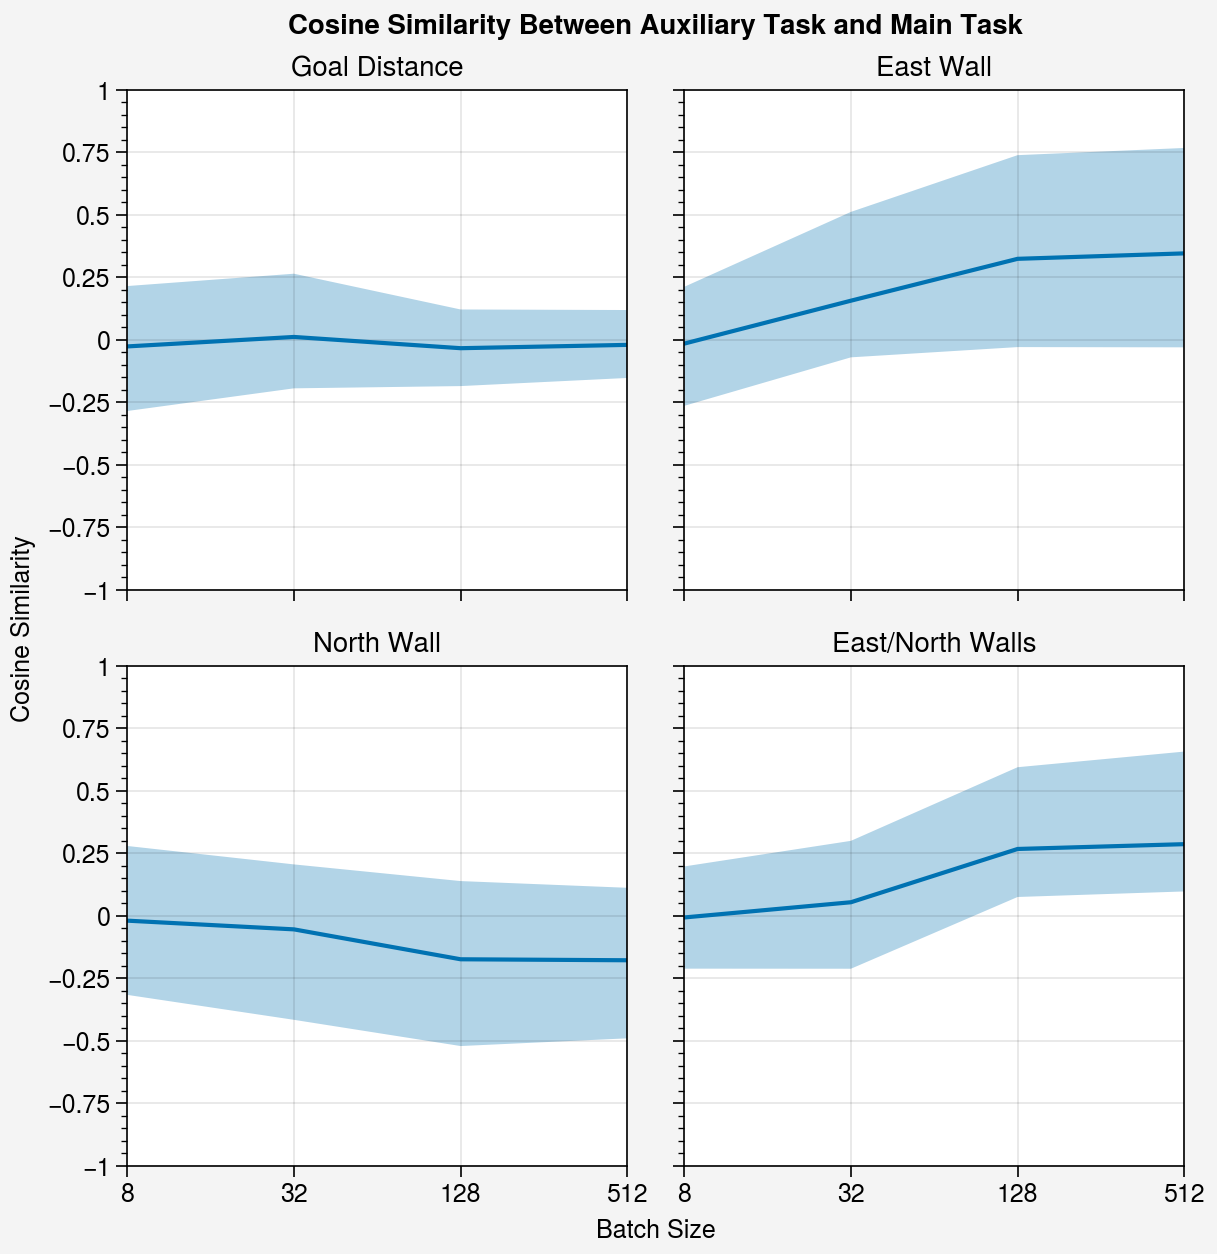

In [17]:
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']
fig, ax = pplt.subplots(nrows=2, ncols=2)

# num_layers = len(all_grads[aux][batch]['value'])
num_layers = 16

for n, aux in enumerate(aux_tasks):
    xs = []
    ys = []
    lows = []
    stds = []
    highs = []
    
    for x, batch in enumerate(batch_sizes):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))

    ax[n].plot(xs, ys)
    ax[n].fill_between(xs, lows, highs, alpha=0.3)

ax.format(ylim=[-1, 1], title=aux_labels,
         xlabel='Batch Size',
         xlocator=range(len(batch_sizes)), xticklabels=[str(batch) for batch in batch_sizes],
         ylabel='Cosine Similarity',
         suptitle='Cosine Similarity Between Auxiliary Task and Main Task')


    
    

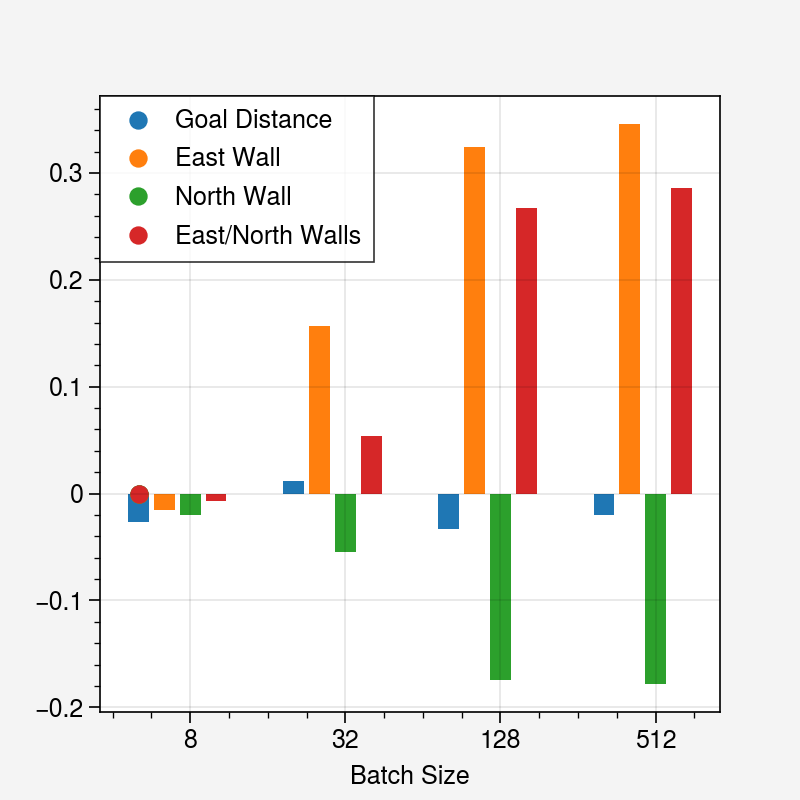

In [49]:
# fig, ax = pplt.subplots()
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']

num_layers = 16

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255
actor_test_layers = [0, 1, 6, 10]

for n, aux in enumerate(aux_tasks):
    
    for x, batch in enumerate(batch_sizes):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xlabel('Batch Size')

for n, label in enumerate(aux_labels):
    plt.scatter([0],[0],c=[rgb_colors[n]], label=label)

plt.legend()

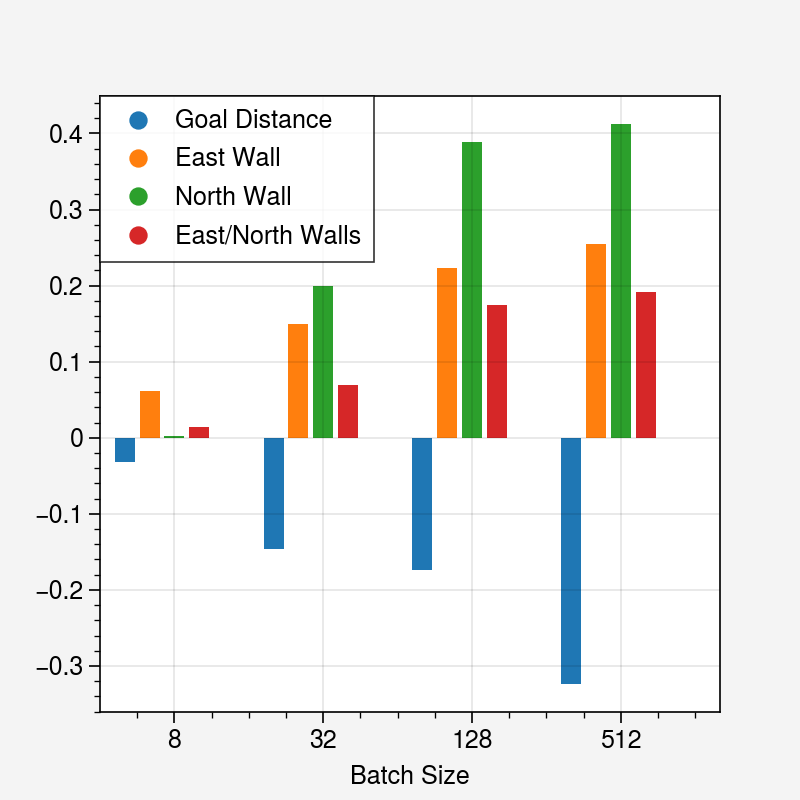

In [26]:
# fig, ax = pplt.subplots()
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']

num_layers = 16

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for x, batch in enumerate(batch_sizes):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xlabel('Batch Size')
plt.xlim([-1, 24])
for n, label in enumerate(aux_labels):
    plt.scatter([-20],[0],c=[rgb_colors[n]], label=label)

plt.legend()

#### Multiple agents

In [8]:
all_results = pickle.load(open('data/grads/width16trained_aux_grads', 'rb'))
all_grads = all_results['all_grads']
batch_sizes = [8, 32, 128, 512]
aux_tasks = all_grads.keys()

Text(0.5, 1.0, 'Pairwise Cosine Sims for Multiple Trained Agents')

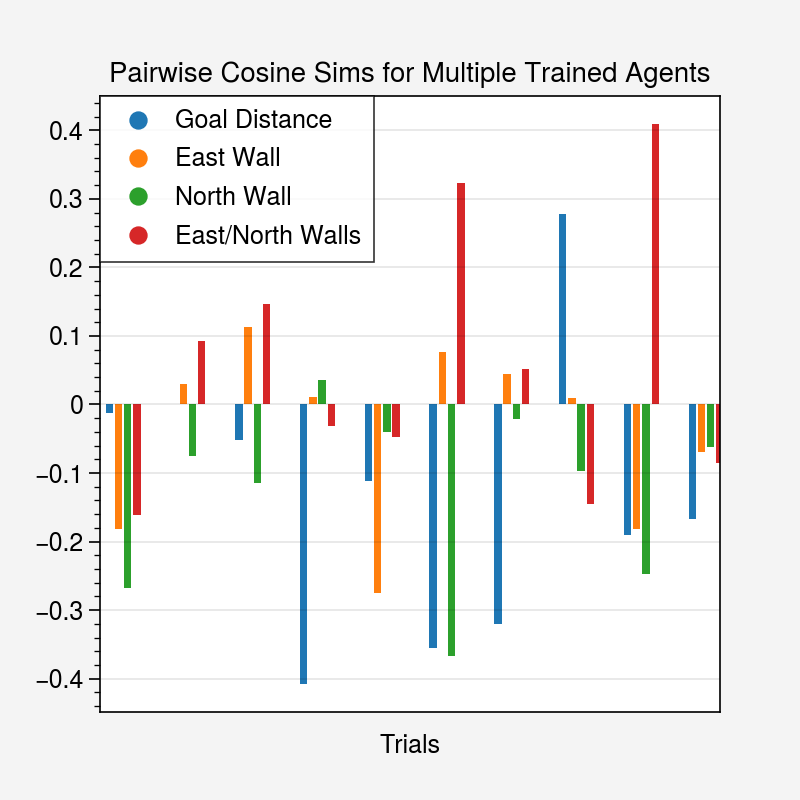

In [369]:
##### aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 10

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(t*7+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
# plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xticks([])
plt.xlabel('Trials')
plt.xlim([-1, 6*(num_trials+1)])

for n, label in enumerate(aux_labels):
    plt.scatter([-20],[0],c=[rgb_colors[n]], label=label)

plt.legend()
plt.title('Pairwise Cosine Sims for Multiple Trained Agents')

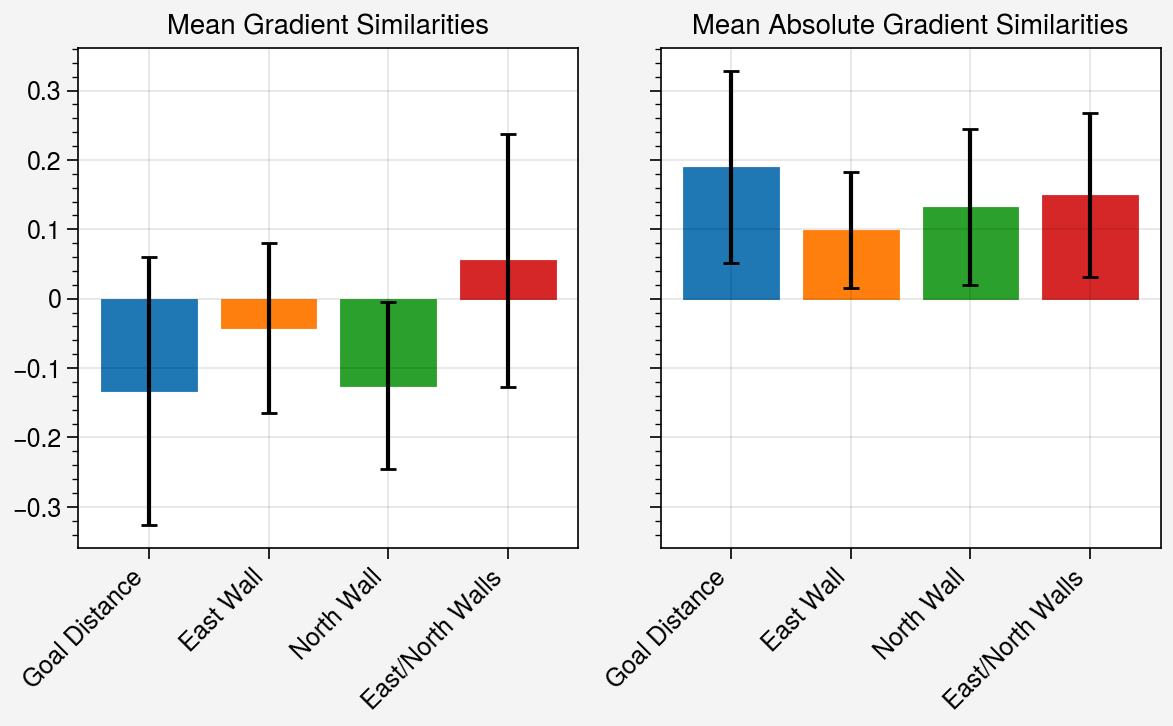

In [315]:
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 10

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        

x2 = []
y2 = []
std2 = []
y3 = []
std3 = []
c = []
for n, aux in enumerate(aux_tasks):
    y = ys[n*num_trials:(n+1)*num_trials]
    y2.append(np.mean(y))
    y3.append(np.mean(np.abs(y)))
    
    std2.append(np.std(y))
    std3.append(np.std(np.abs(y)))
    x2.append(n)
    c.append(rgb_colors[n])
    
    
# fig, ax = plt.subplots(1, 2)
fig, ax = pplt.subplots(ncols=2)
ax[0].bar(x2, y2, color=c, yerr=std2)
ax[1].bar(x2, y3, color=c, yerr=std3)

ax.format(xlocator=range(len(aux_tasks)), xticklabels=aux_labels,
          xrotation=45, 
          title=['Mean Gradient Similarities', 'Mean Absolute Gradient Similarities'])

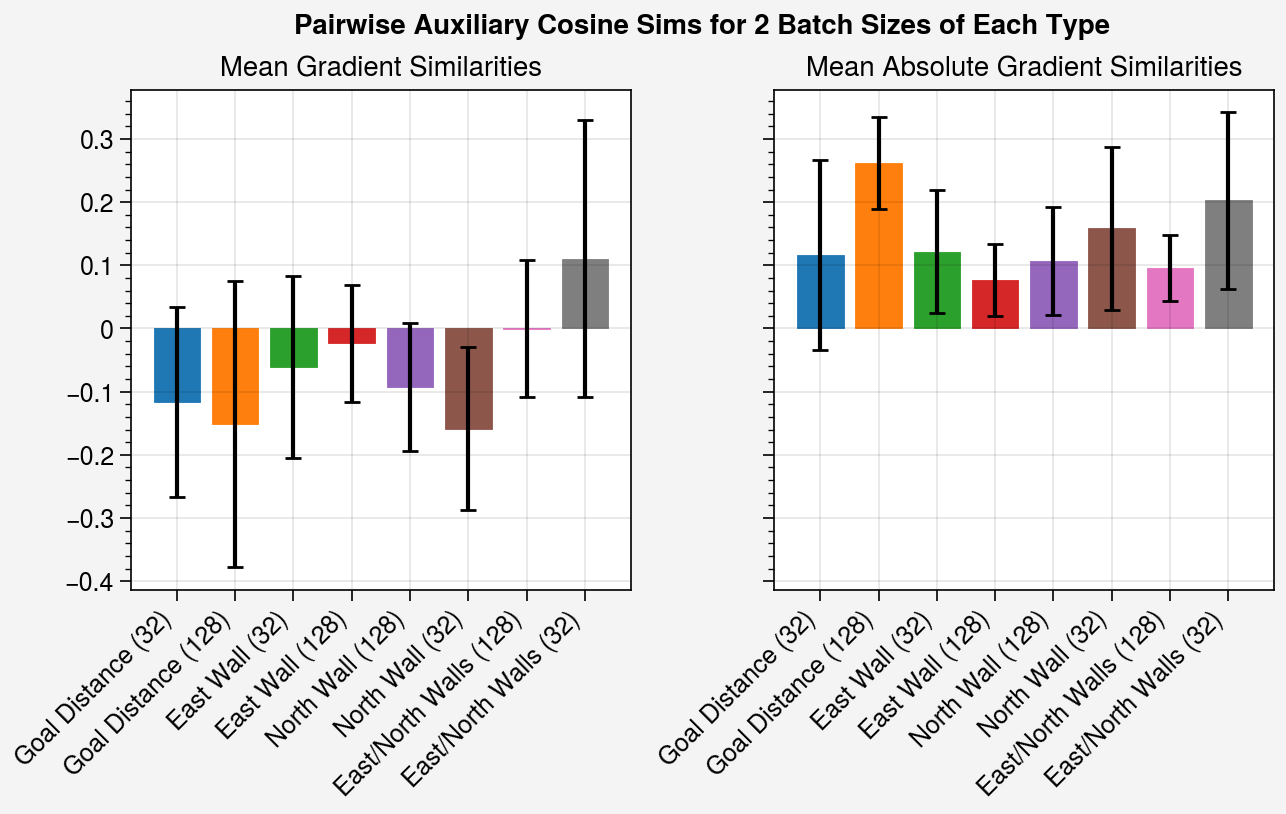

In [371]:
aux_labels = ['Goal Distance (32)', 'Goal Distance (128)', 'East Wall (32)', 'East Wall (128)',
              'North Wall (128)', 'North Wall (32)', 'East/North Walls (128)', 'East/North Walls (32)']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 10

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        

x2 = []
y2 = []
std2 = []
y3 = []
std3 = []
c = []
for n, aux in enumerate(aux_labels):
    y = ys[n*5:(n+1)*5]
    y2.append(np.mean(y))
    y3.append(np.mean(np.abs(y)))
    
    std2.append(np.std(y))
    std3.append(np.std(np.abs(y)))
    x2.append(n)
    c.append(rgb_colors[n])
    
    
# fig, ax = plt.subplots(1, 2)
fig, ax = pplt.subplots(ncols=2)
ax[0].bar(x2, y2, color=c, yerr=std2)
ax[1].bar(x2, y3, color=c, yerr=std3)

ax.format(suptitle='Pairwise Auxiliary Cosine Sims for 2 Batch Sizes of Each Type',
          xlocator=range(len(aux_labels)), xticklabels=aux_labels,
          xrotation=45, 
          title=['Mean Gradient Similarities', 'Mean Absolute Gradient Similarities'])

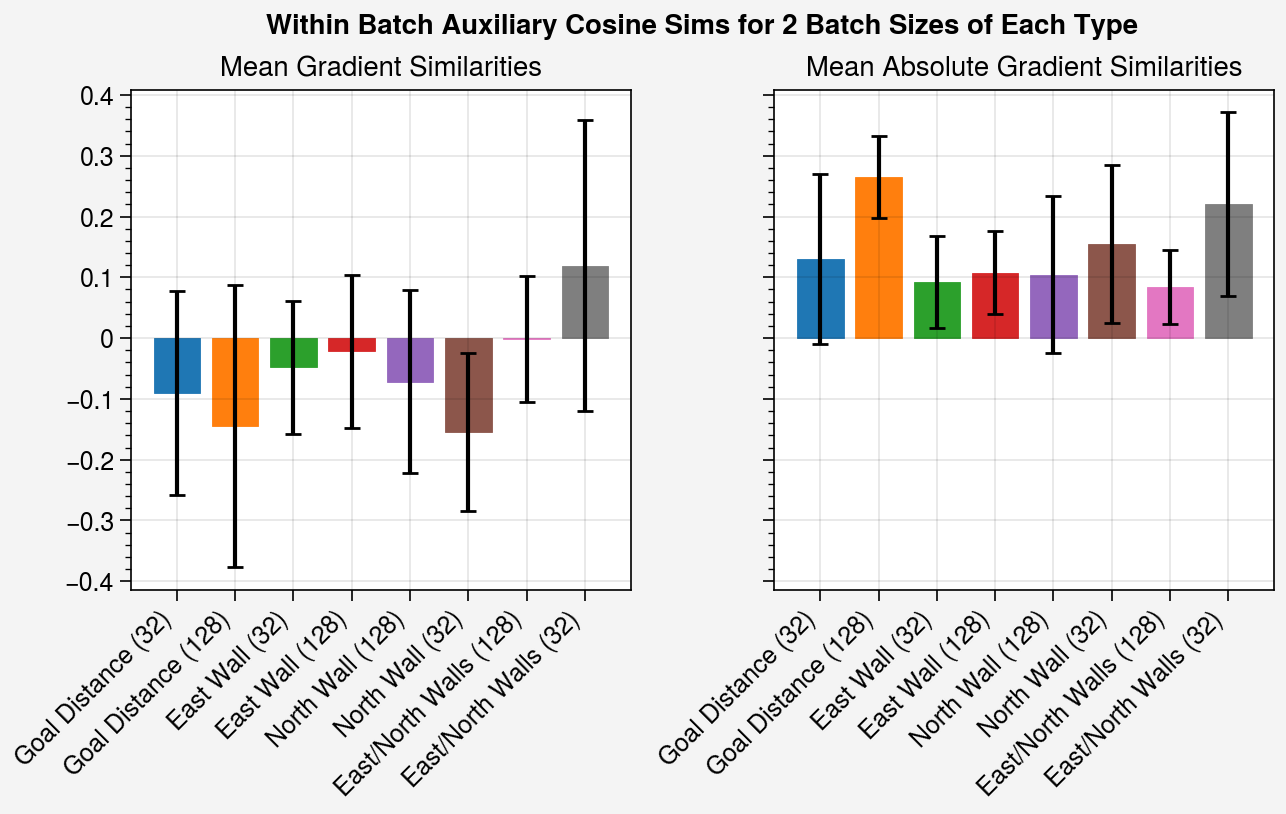

In [372]:
aux_labels = ['Goal Distance (32)', 'Goal Distance (128)', 'East Wall (32)', 'East Wall (128)',
              'North Wall (128)', 'North Wall (32)', 'East/North Walls (128)', 'East/North Walls (32)']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 10
test_layers = [0, 1, 6, 10]


xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in test_layers:
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            # cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            # cs = cs[cs != 0]
            # cos_sims += list(cs)
            for j in range(num_batches):
                cs = cosine_similarity(cumu_grad[j].reshape(1, -1),
                                       aux_grad[j].reshape(1, -1))
                cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        

x2 = []
y2 = []
std2 = []
y3 = []
std3 = []
c = []
for n, aux in enumerate(aux_labels):
    y = ys[n*5:(n+1)*5]
    y2.append(np.mean(y))
    y3.append(np.mean(np.abs(y)))
    
    std2.append(np.std(y))
    std3.append(np.std(np.abs(y)))
    x2.append(n)
    c.append(rgb_colors[n])
    
    
# fig, ax = plt.subplots(1, 2)
fig, ax = pplt.subplots(ncols=2)
ax[0].bar(x2, y2, color=c, yerr=std2)
ax[1].bar(x2, y3, color=c, yerr=std3)

ax.format(suptitle='Within Batch Auxiliary Cosine Sims for 2 Batch Sizes of Each Type',
          xlocator=range(len(aux_labels)), xticklabels=aux_labels,
          xrotation=45, 
          title=['Mean Gradient Similarities', 'Mean Absolute Gradient Similarities'])

In [22]:
np.array(cos_sims['y']).shape

(4, 10)

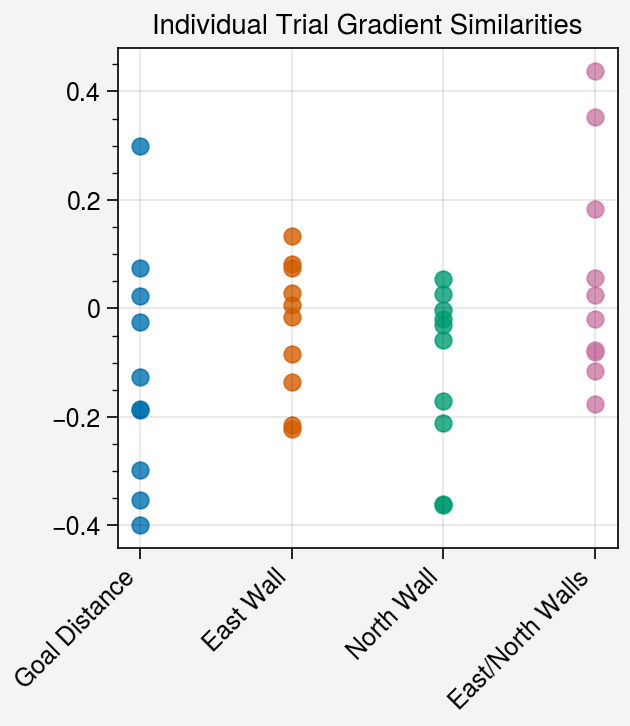

In [26]:
cos_sims = aux_cos_sims_from_all_grads(all_grads)
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

fig, ax = pplt.subplots()
for i in range(len(aux_tasks)):
    ax.scatter([i]*len(cos_sims['y'][i]), cos_sims['y'][i], alpha=0.8)
ax.format(title='Individual Trial Gradient Similarities', 
          xlocator=range(5), xticklabels=aux_labels, xrotation=45)

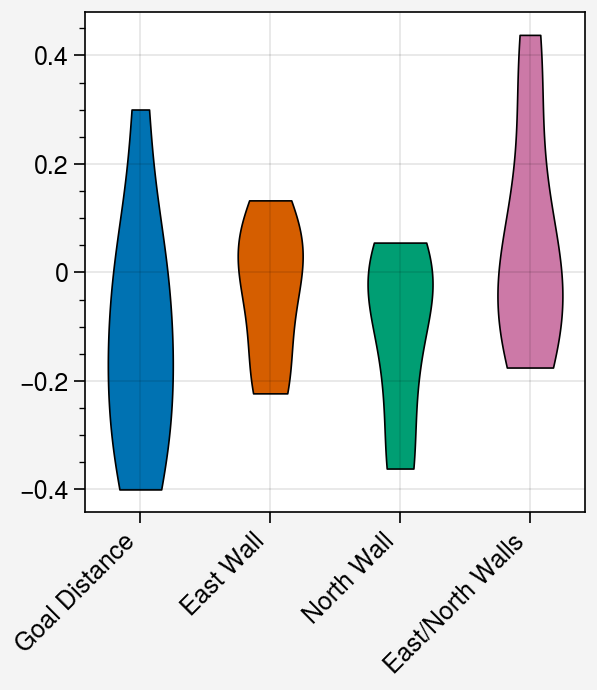

In [426]:
cos_sims = aux_cos_sims_from_all_grads(all_grads)
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']

fig, ax = pplt.subplots()
for aux in aux_tasks:
    
ax.scatter()
ax.format(xlocator=range(5), xticklabels=aux_labels, xrotation=45)

### Aux Grad cos sim RL Grad for fresh agent 

Doing the same analysis on cosine similarity of auxiliary task to RL task gradients but this time for fresh agents

In [27]:
all_results = pickle.load(open('data/grads/width16fresh_aux_grads', 'rb'))
all_grads = all_results['all_grads']
# batch_sizes = [8, 32, 128, 512]
batch = 128
num_trials = 20
aux_tasks = all_grads.keys()

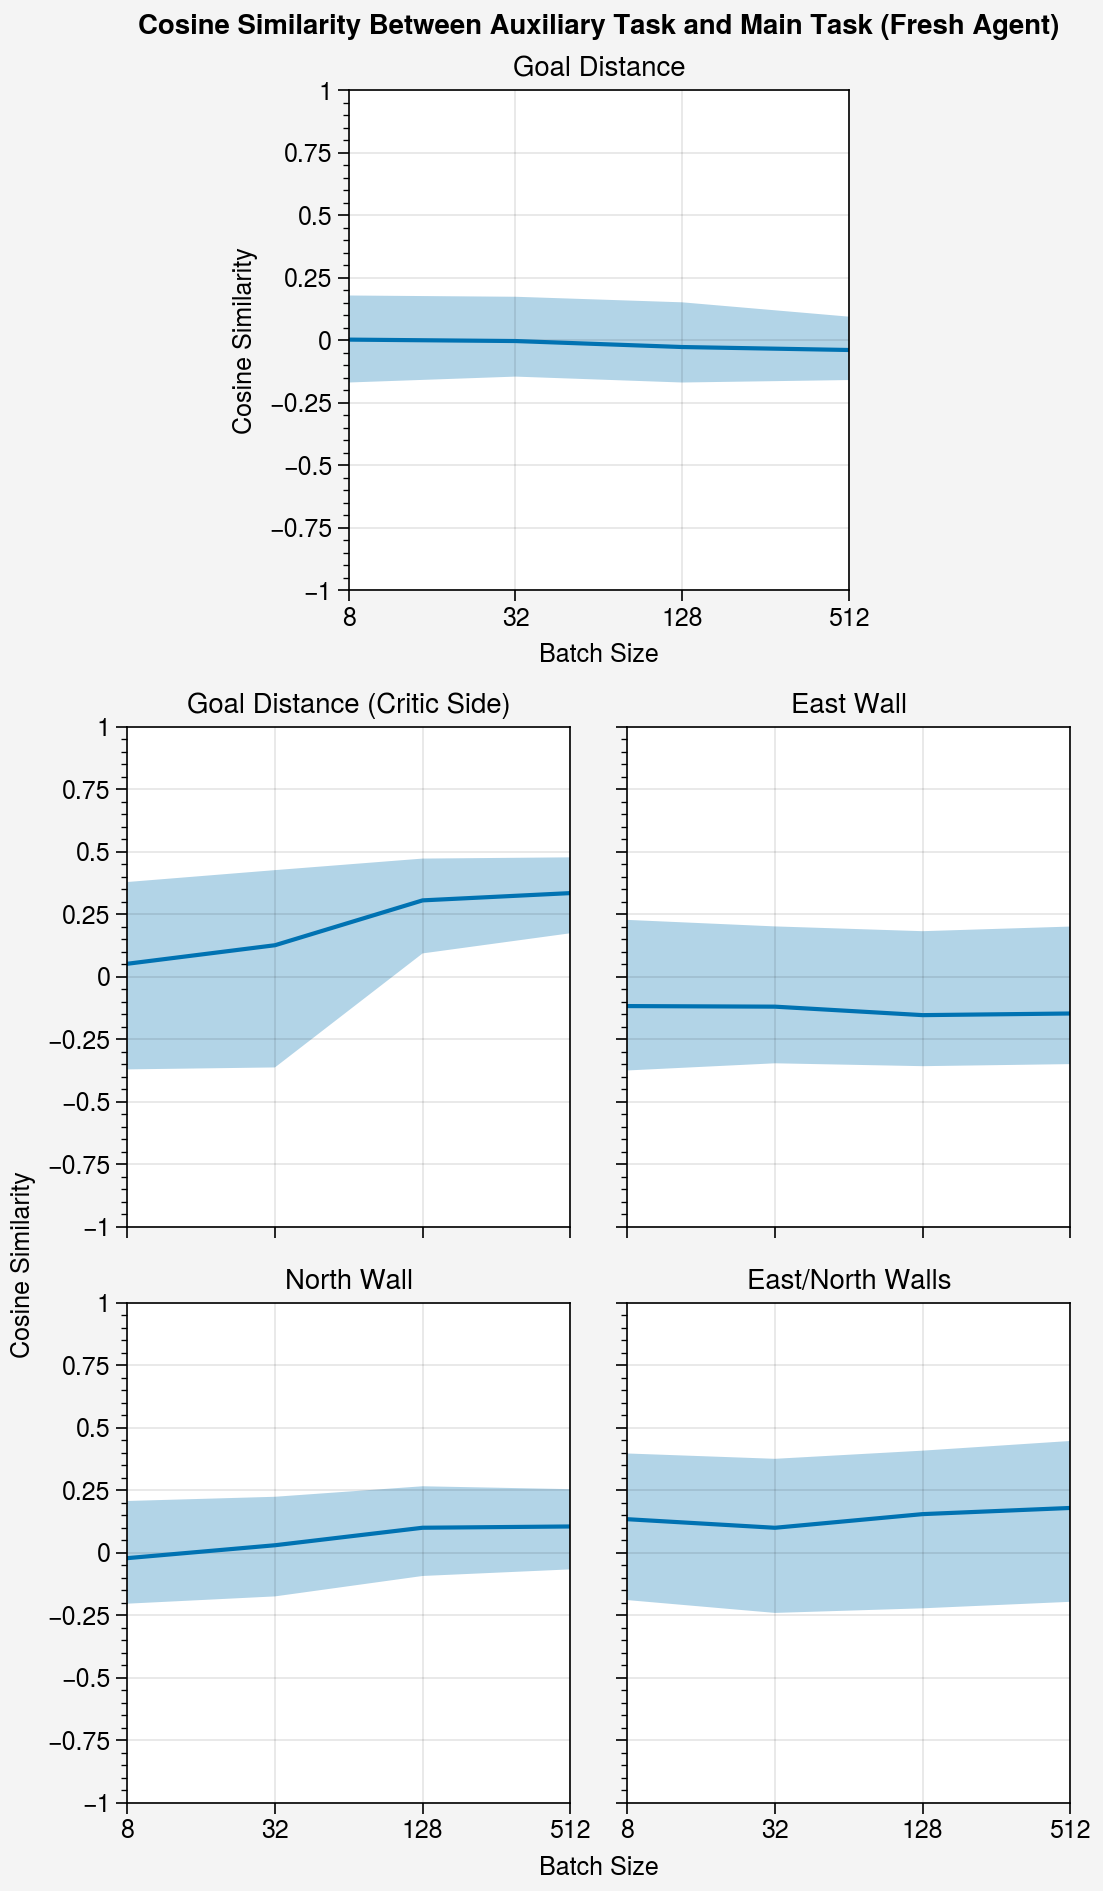

In [16]:
aux_labels = ['Goal Distance', 'Goal Distance (Critic Side)', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']
array = [[0, 1, 1, 0], [2, 2, 3, 3], [4, 4, 5, 5]]
fig, ax = pplt.subplots(array)

# num_layers = len(all_grads[aux][batch]['value'])
num_layers = 16

for n, aux in enumerate(aux_tasks):
    xs = []
    ys = []
    lows = []
    stds = []
    highs = []
    
    for x, batch in enumerate(batch_sizes):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))

    ax[n].plot(xs, ys)
    ax[n].fill_between(xs, lows, highs, alpha=0.3)

ax.format(ylim=[-1, 1], title=aux_labels,
         xlabel='Batch Size',
         xlocator=range(len(batch_sizes)), xticklabels=[str(batch) for batch in batch_sizes],
         ylabel='Cosine Similarity',
         suptitle='Cosine Similarity Between Auxiliary Task and Main Task (Fresh Agent)')


    
    

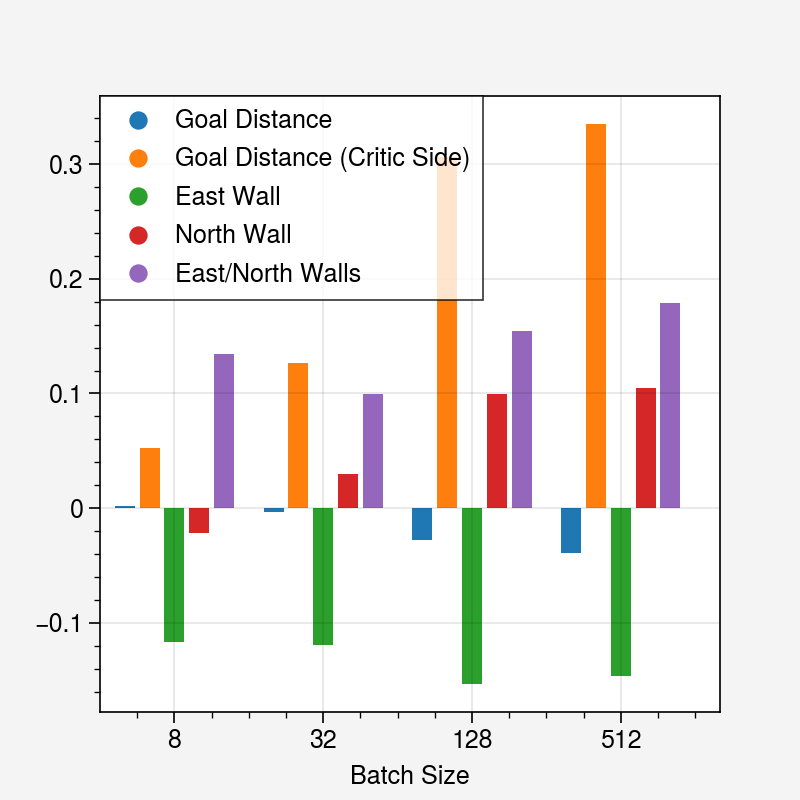

In [15]:
aux_labels = ['Goal Distance', 'Goal Distance (Critic Side)', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']

num_layers = 16

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255
actor_test_layers = [0, 1, 6, 10]

for n, aux in enumerate(aux_tasks):
    
    for x, batch in enumerate(batch_sizes):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][batch]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xlabel('Batch Size')
plt.xlim([-1, 24])

for n, label in enumerate(aux_labels):
    plt.scatter([-20],[0],c=[rgb_colors[n]], label=label)

plt.legend()

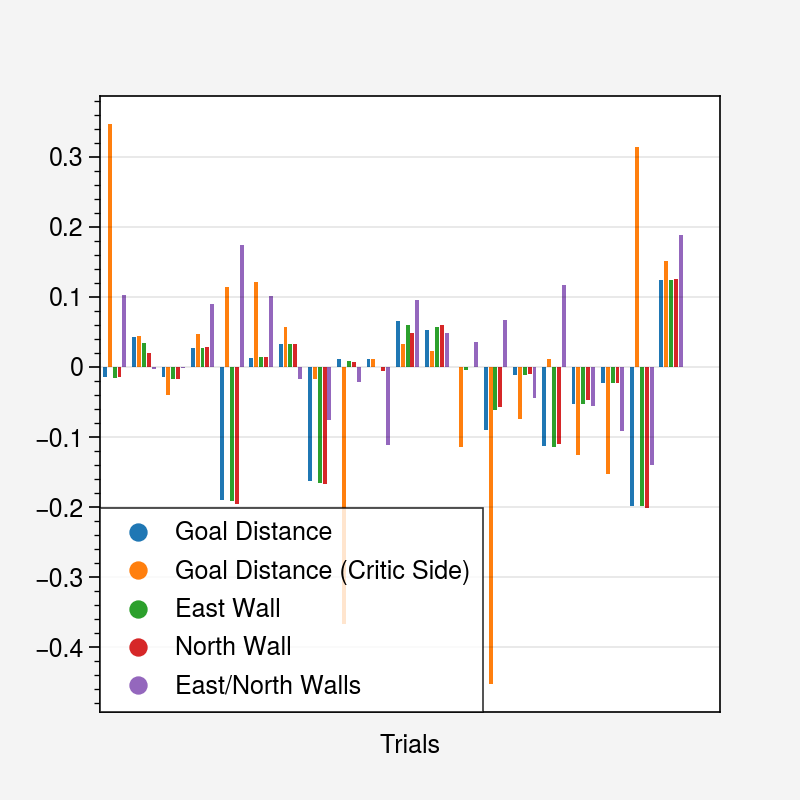

In [45]:
aux_labels = ['Goal Distance', 'Goal Distance (Critic Side)', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 20

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255



for n, aux in enumerate(aux_tasks):
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            # cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            # cs = cs[cs != 0]
            # cos_sims += list(cs)
            for j in range(num_batches):
                cs = cosine_similarity(cumu_grad[j].reshape(1, -1),
                                       aux_grad[j].reshape(1, -1))
                cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
# plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xticks([])
plt.xlabel('Trials')
plt.xlim([-1, 6*(num_trials+1)])

for n, label in enumerate(aux_labels):
    plt.scatter([-20],[0],c=[rgb_colors[n]], label=label)

plt.legend()

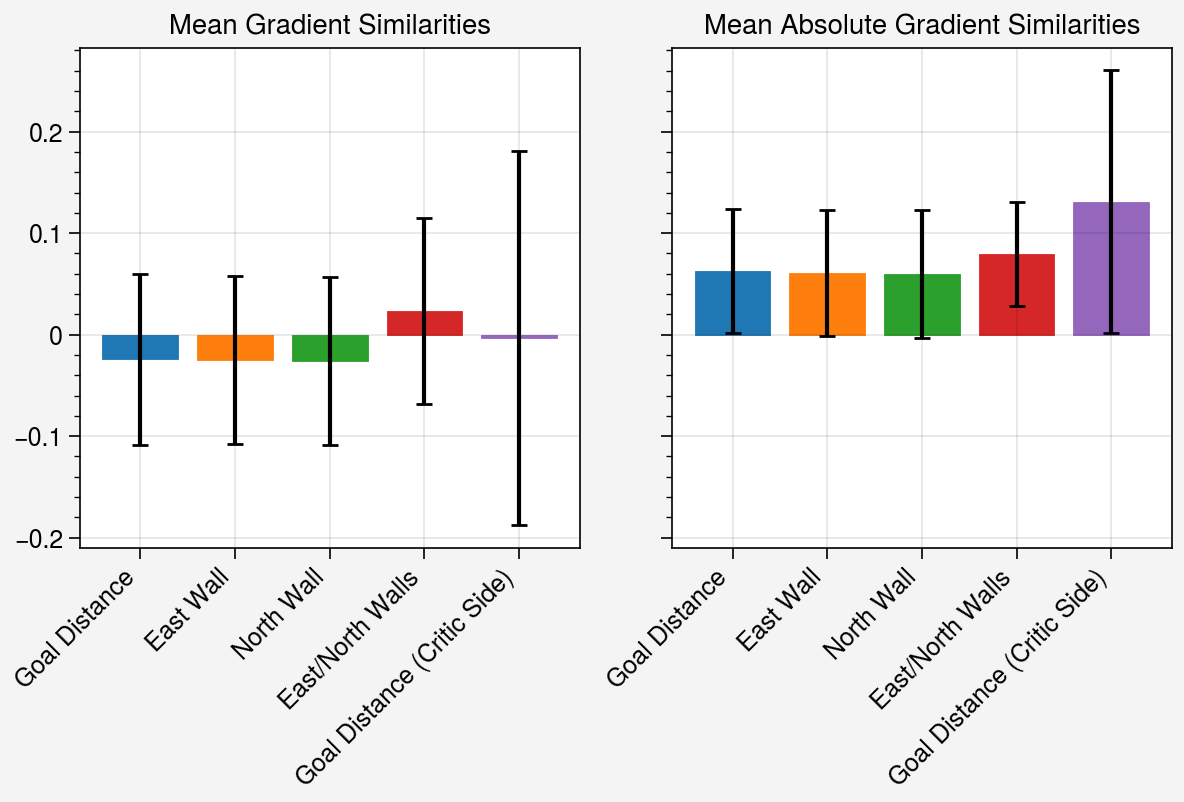

In [28]:
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls', 'Goal Distance (Critic Side)']
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'goaldist_c']

num_layers = 16
num_trials = 20

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        

x2 = []
y2 = []
std2 = []
y3 = []
std3 = []
c = []
for n, aux in enumerate(aux_tasks):
    y = ys[n*20:(n+1)*20]
    y2.append(np.mean(y))
    y3.append(np.mean(np.abs(y)))
    
    std2.append(np.std(y))
    std3.append(np.std(np.abs(y)))
    x2.append(n)
    c.append(rgb_colors[n])
    
    
# fig, ax = plt.subplots(1, 2)
fig, ax = pplt.subplots(ncols=2)
ax[0].bar(x2, y2, color=c, yerr=std2)
ax[1].bar(x2, y3, color=c, yerr=std3)

ax.format(xlocator=range(len(aux_tasks)), xticklabels=aux_labels,
          xrotation=45, 
          title=['Mean Gradient Similarities', 'Mean Absolute Gradient Similarities'])

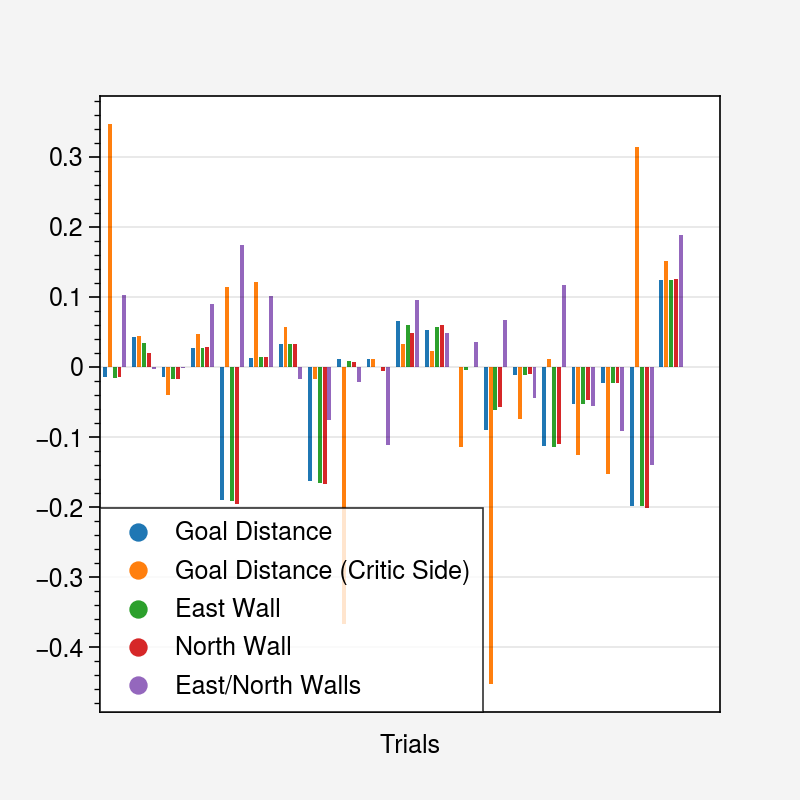

In [45]:
aux_labels = ['Goal Distance', 'Goal Distance (Critic Side)', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']

num_layers = 16
num_trials = 20

xs = []
ys = []
lows = []
stds = []
highs = []
c = []
colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

for n, aux in enumerate(aux_tasks):
    
    for t in range(num_trials):
        cos_sims = []
        for i in range(num_layers):
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad

            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(t*6+n)
        ys.append(np.mean(cos_sims))
        lows.append(np.percentile(cos_sims, 12.5))
        highs.append(np.percentile(cos_sims, 87.5))
        stds.append(np.std(cos_sims))
        c.append(rgb_colors[n])
        
plt.bar(xs, ys, width=0.8, color=c)
# plt.xticks([2, 8, 14, 20], labels=[str(batch) for batch in batch_sizes])
plt.xticks([])
plt.xlabel('Trials')
plt.xlim([-1, 6*(num_trials+1)])

for n, label in enumerate(aux_labels):
    plt.scatter([-20],[0],c=[rgb_colors[n]], label=label)

plt.legend()

#### Within batch

Earlier section was using pairwise similarities, trying within batch now

In [391]:
all_results = pickle.load(open('data/grads/width16fresh_aux_grads', 'rb'))
all_grads = all_results['all_grads']

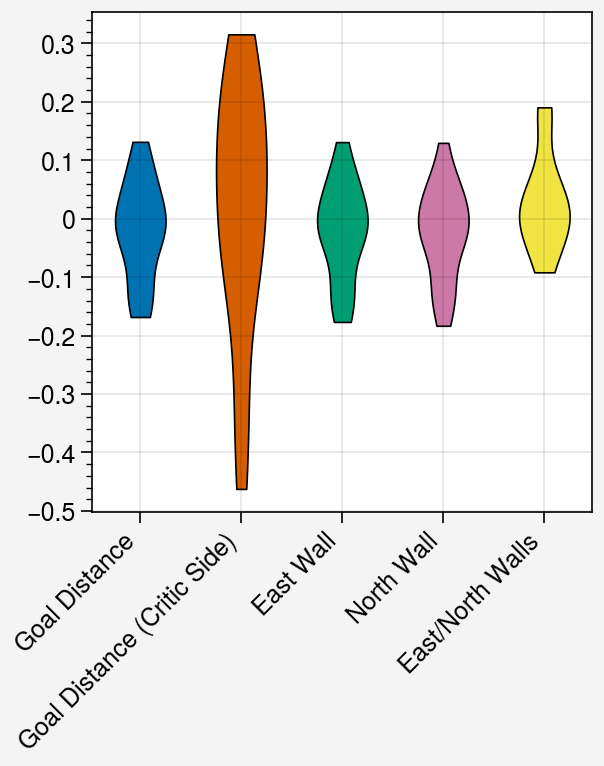

In [424]:
cos_sims = aux_cos_sims_from_all_grads(all_grads)
aux_labels = ['Goal Distance', 'Goal Distance (Critic Side)', 'East Wall', 'North Wall', 'East/North Walls']
aux_tasks = ['goaldist', 'goaldist_c', 'wall0', 'wall1', 'wall01']


fig, ax = pplt.subplots()
ax.violinplot(np.array(cos_sims['y']).T,)
ax.format(xlocator=range(5), xticklabels=aux_labels, xrotation=45)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2894fef3340>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x2894c226700>,
 'cmins': <matplotlib.collections.LineCollection at 0x2894ff1d220>,
 'cbars': <matplotlib.collections.LineCollection at 0x2894ff1deb0>}

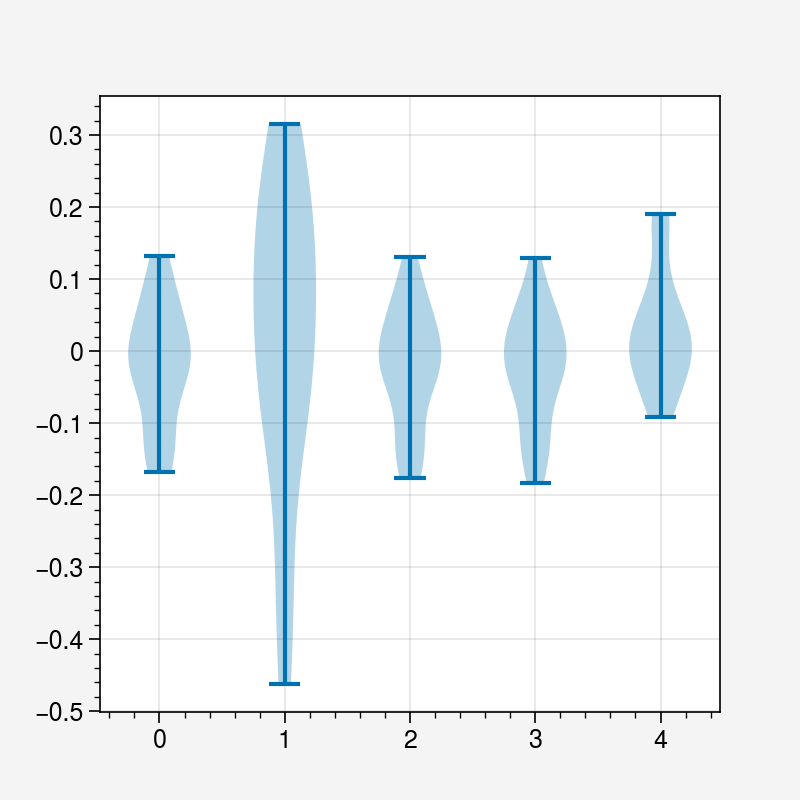

In [407]:
fig, ax = plt.subplots()
ax.violinplot(cos_sims['y'], range(5))

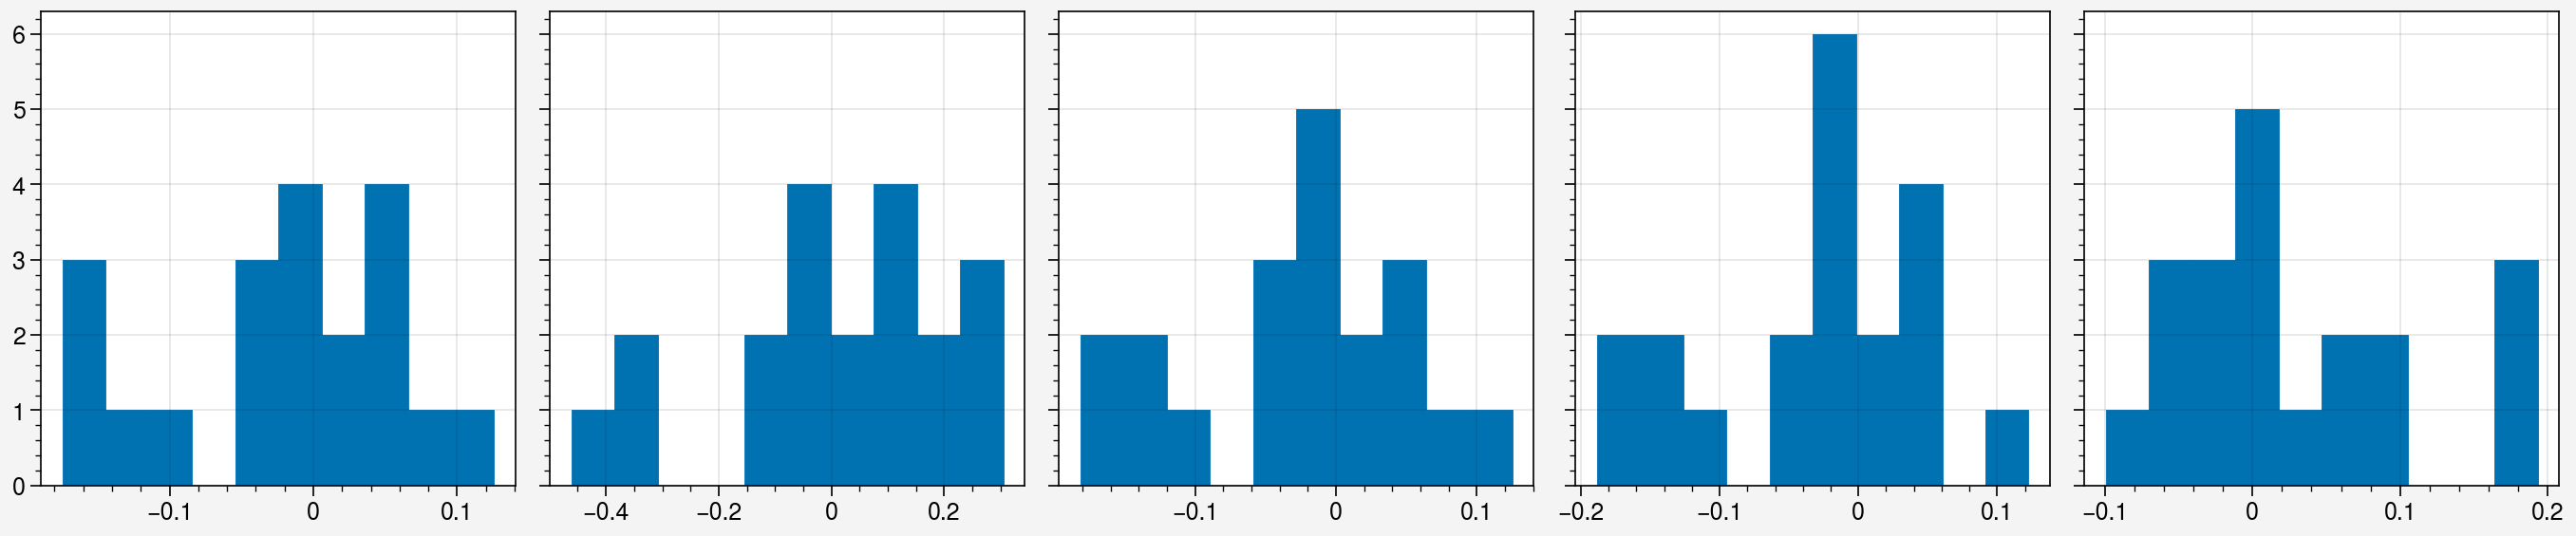

In [218]:
fig, ax = pplt.subplots(nrows=1, ncols=5)
for n, label in enumerate(aux_labels):
    y = ys[n*20:(n+1)*20]
    ax[n].hist(y)

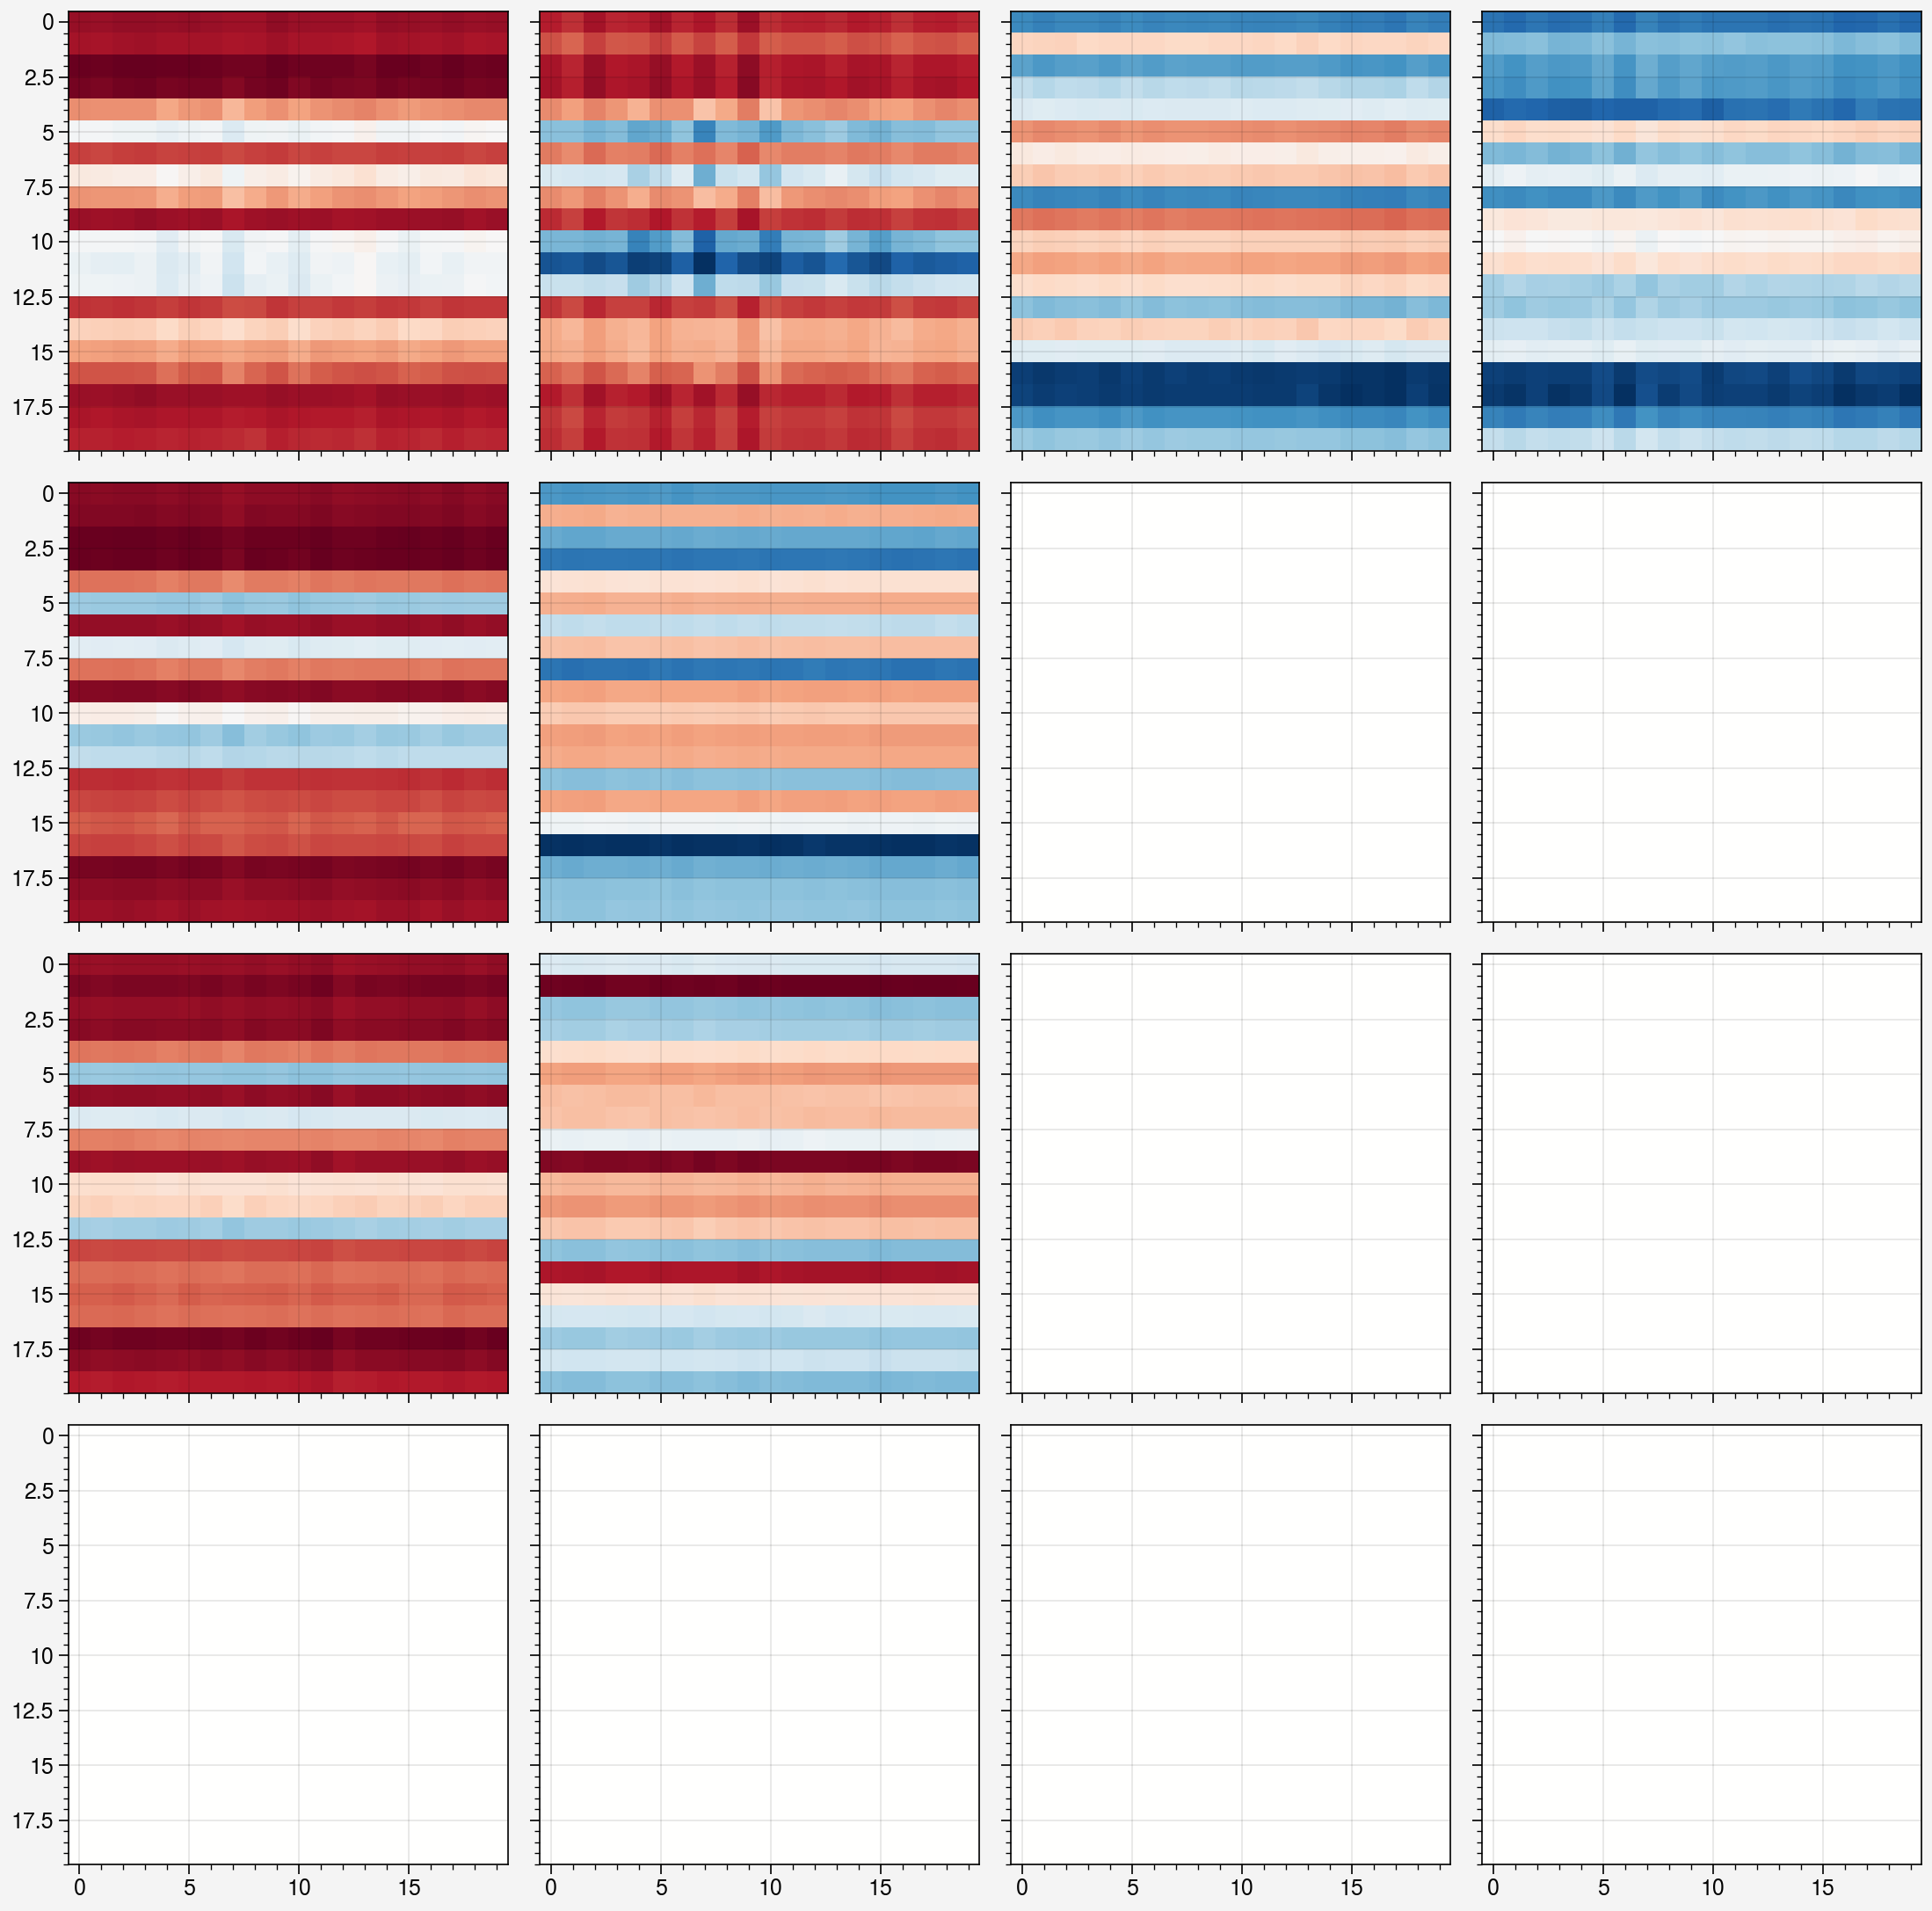

In [ ]:
aux = 'goaldist_c'
t = 1
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(16):
    value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
    action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
    entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
    aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
    cumu_grad = value_grad + action_grad + entropy_grad

    cs = cosine_similarity(cumu_grad, aux_grad)
    ax[i].imshow(cs)

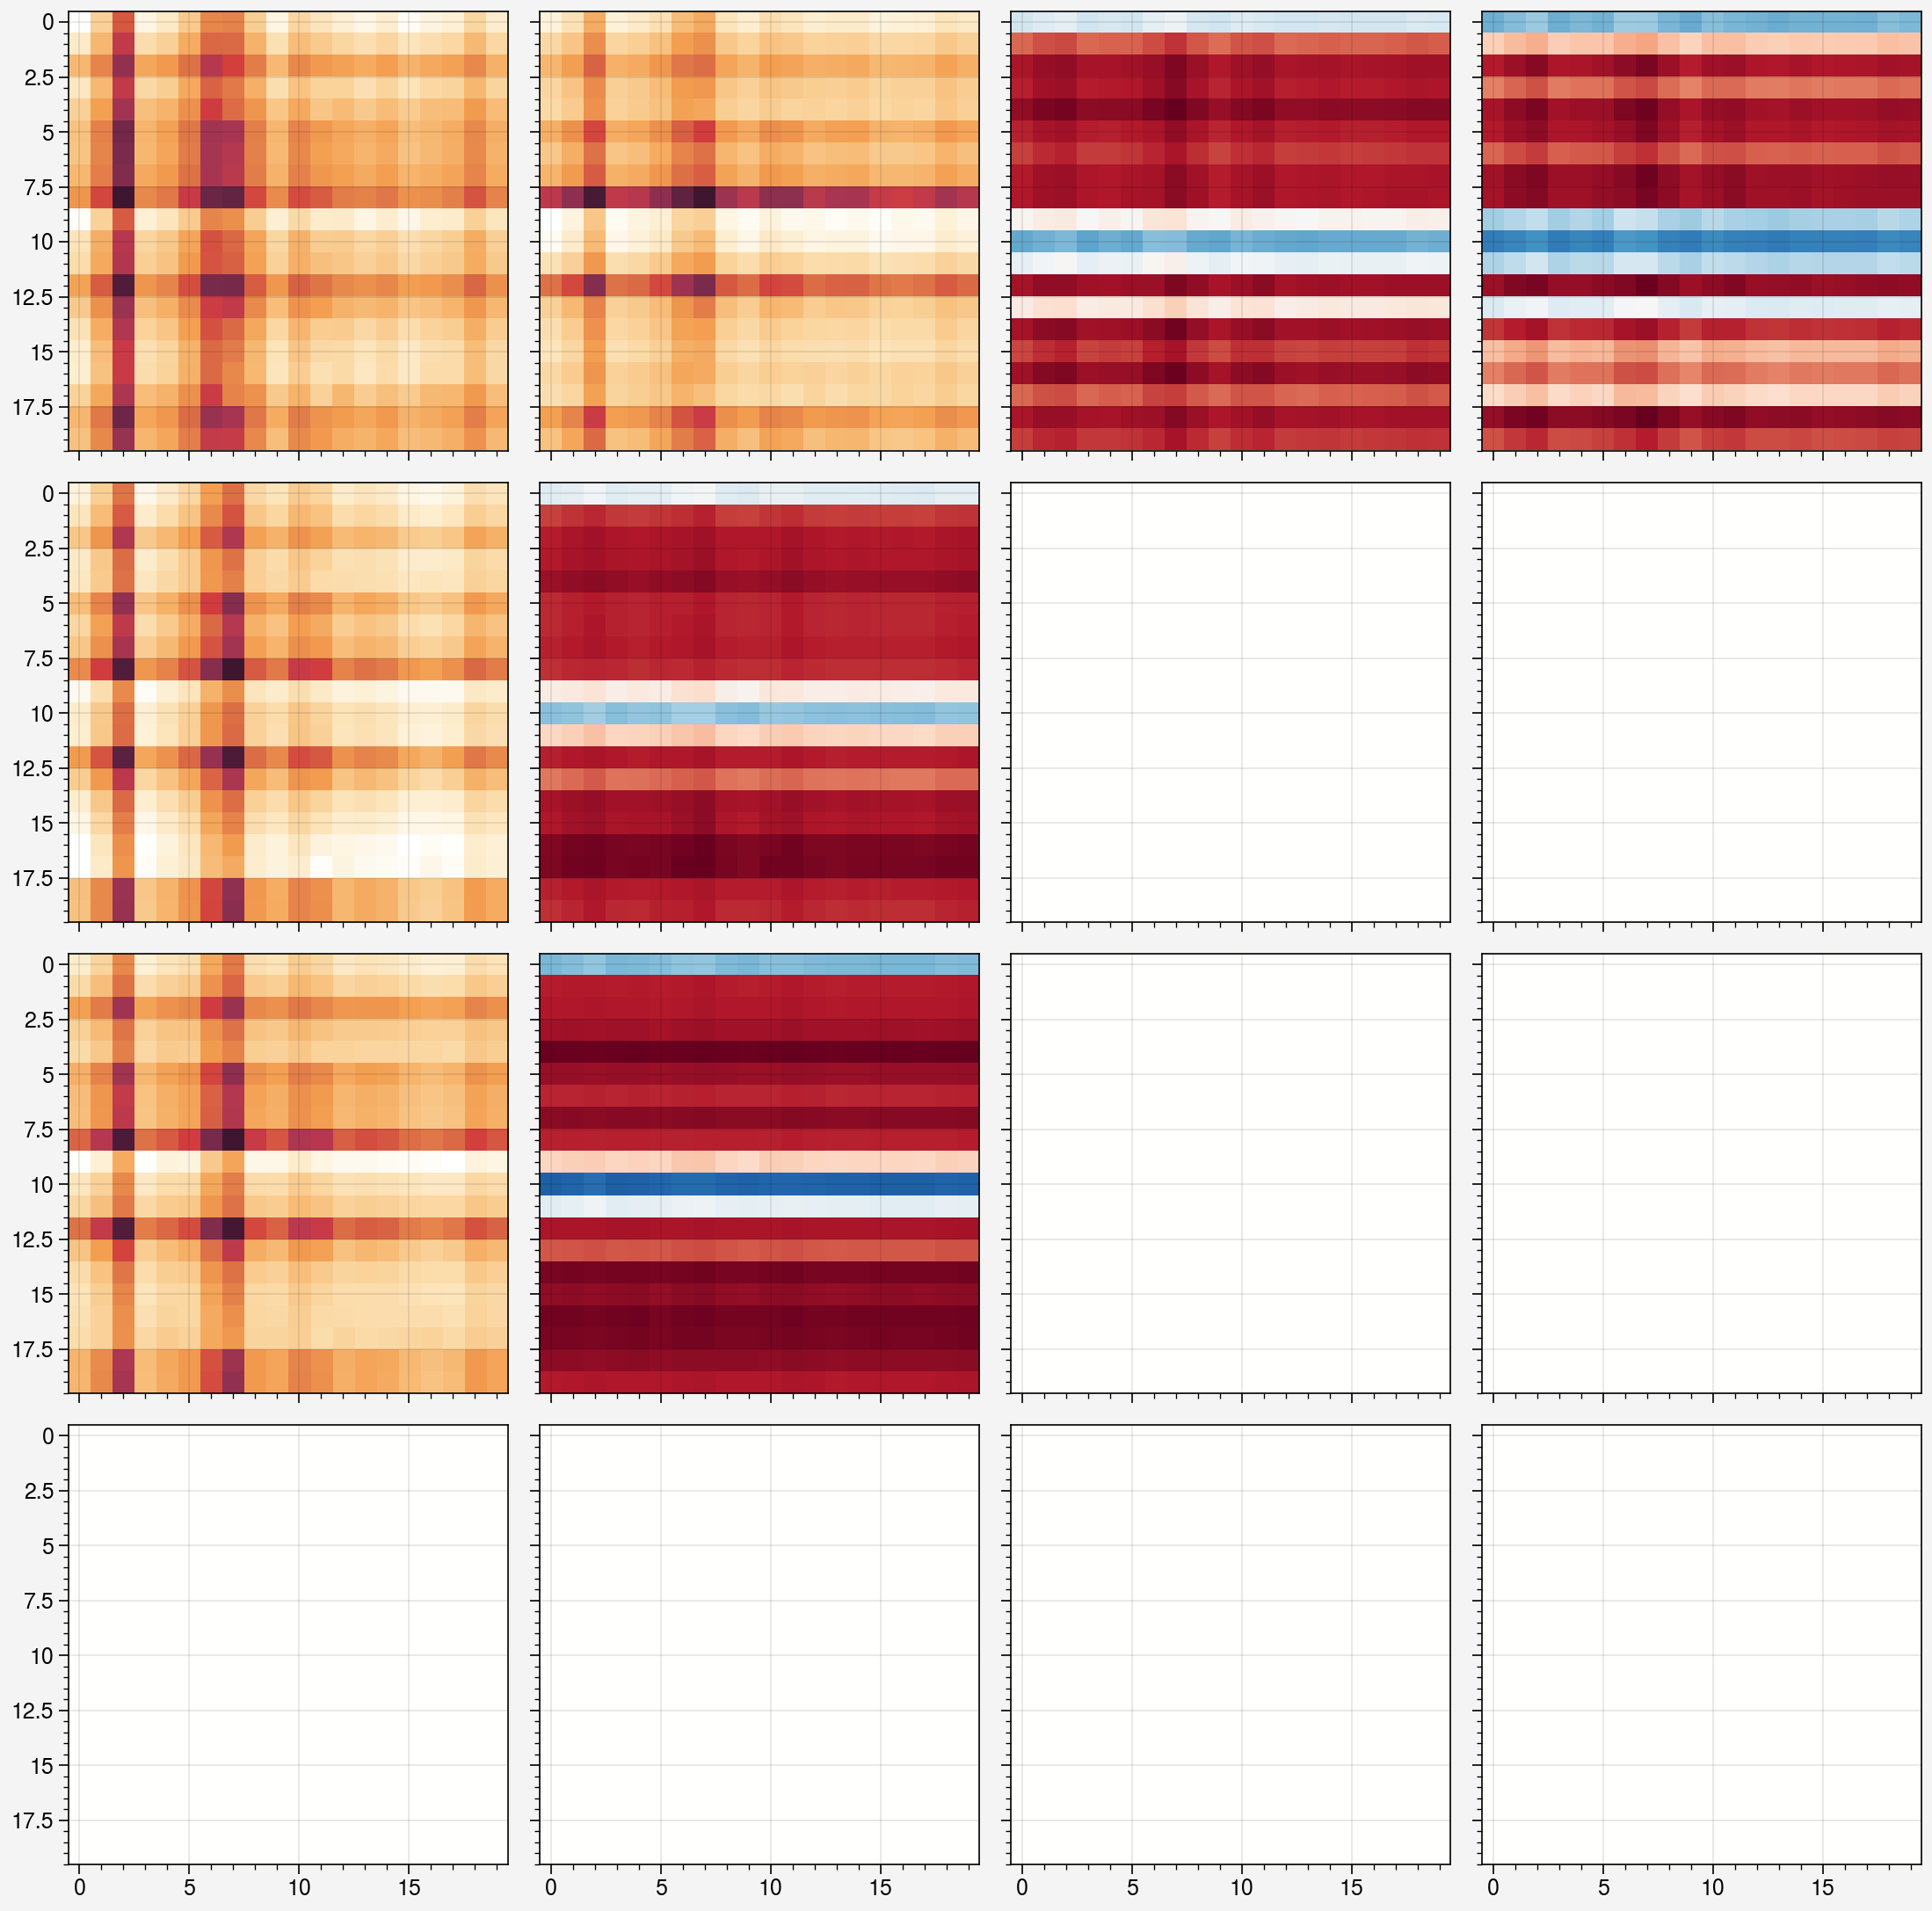

In [198]:
aux = 'goaldist_c'
t = 2
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(16):
    value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['value'][i]])
    action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['action'][i]])
    entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['entropy'][i]])
    aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][t]['auxiliary'][i]])
    cumu_grad = value_grad + action_grad + entropy_grad

    cs = cosine_similarity(cumu_grad, aux_grad)
    ax[i].imshow(cs)

## Does auxiliary gradient cos sim change over training?

### Data Collection

In [330]:
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01']
checkpoints = [0, 10, 20, 30, 40, 50, 80, 120, 160, 200]

num_layers = 16
num_batches = 20
num_proceses = 16
batch_size = 128

all_grads = {aux: [] for aux in aux_tasks}
all_rewarded = {aux: [] for aux in aux_tasks}
all_rewards = {aux: [] for aux in aux_tasks}
all_value_losses = {aux: [] for aux in aux_tasks}
all_action_losses = {aux: [] for aux in aux_tasks}
all_value_diffs = {aux: [] for aux in aux_tasks}

for i, aux in enumerate(aux_tasks):
    kwarg_file_name = f'../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}_env'
    env_kwargs = pickle.load(open(kwarg_file_name, 'rb'))
    env = gym.make('NavEnv-v0', **env_kwargs)
    envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                        False, env_kwargs=env_kwargs)
    obs = envs.reset()
    
    path = Path(f'../trained_models/checkpoint/nav_pdistal_batchaux/nav_pdistal_batch128aux{aux}_t0')

    for chk in tqdm(checkpoints):
        model, obs_rms = torch.load(path/f'{chk}.pt')
        agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            take_optimizer_step=False)

        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)

        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches, 
                                        decompose_grads=True)

        all_grads[aux].append(res['all_grads'])
        all_rewarded[aux].append(res['rewarded'])
        all_rewards[aux].append(res['rewards'])
        all_value_losses[aux].append(res['value_losses'])
        all_action_losses[aux].append(res['action_losses'])
        all_value_diffs[aux].append(res['value_diff'])

        obs = rollouts.obs[-1]

all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open('data/grads/checkpoint16_aux_grads', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.70s/it]


### Plotting

In [ ]:
all_results = pickle.load(open('data/grads/checkpoint16_aux_grads', 'rb'))
all_grads = all_results['all_grads']
aux_tasks = all_grads.keys()

In [354]:
aux = 'wall0'
x = 0
i = 0
value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['value'][i]])
action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['action'][i]])
entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['entropy'][i]])
aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['auxiliary'][i]])
cumu_grad = value_grad + action_grad + entropy_grad


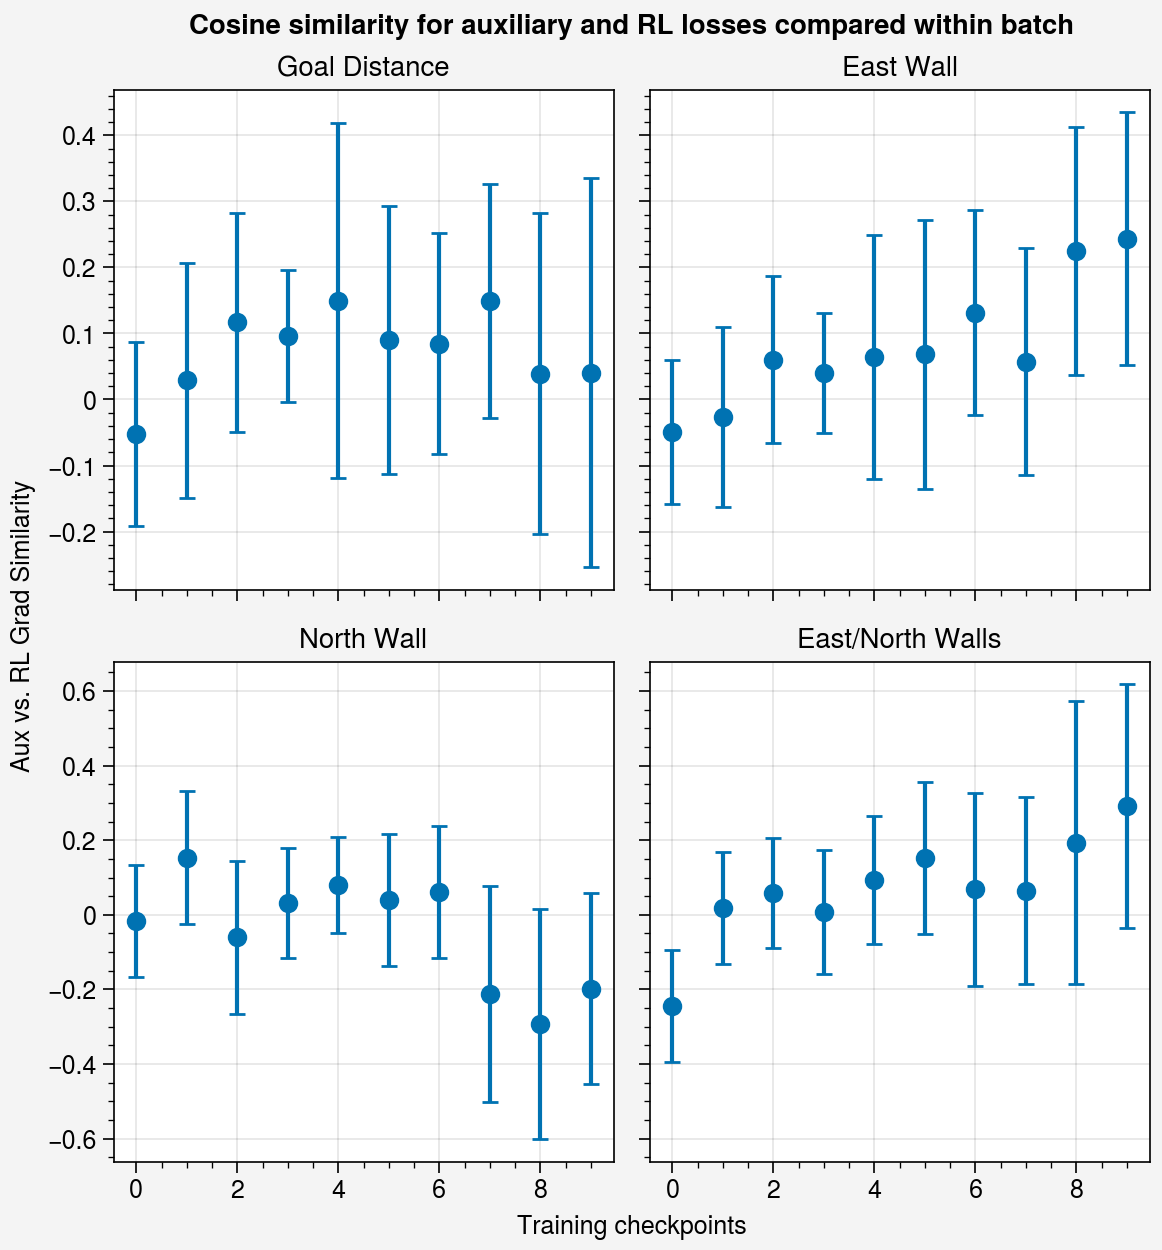

In [363]:
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']

num_layers = 16
num_batches = 20
test_layers = [0, 1, 6, 10]

colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255
actor_test_layers = [0, 1, 6, 10]

fig, ax = pplt.subplots(nrows=2, ncols=2)

for n, aux in enumerate(aux_tasks):
    xs = []
    ys = []
    stds = []
    for x in range(len(checkpoints)):
        cos_sims = []
        for i in test_layers:
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad
            
            for j in range(num_batches):
                cs = cosine_similarity(cumu_grad[j].reshape(1, -1),
                                       aux_grad[j].reshape(1, -1))
                cos_sims += list(cs)
        xs.append(x)
        ys.append(np.mean(cos_sims))
        stds.append(np.std(cos_sims))
        # c.append(rgb_colors[n])
    
    ax[n].errorbar(xs, ys, yerr=stds, fmt='o')

ax.format(title=aux_labels, xlabel='Training checkpoints', 
          ylabel='Aux vs. RL Grad Similarity', 
          suptitle='Cosine similarity for auxiliary and RL losses compared within batch')

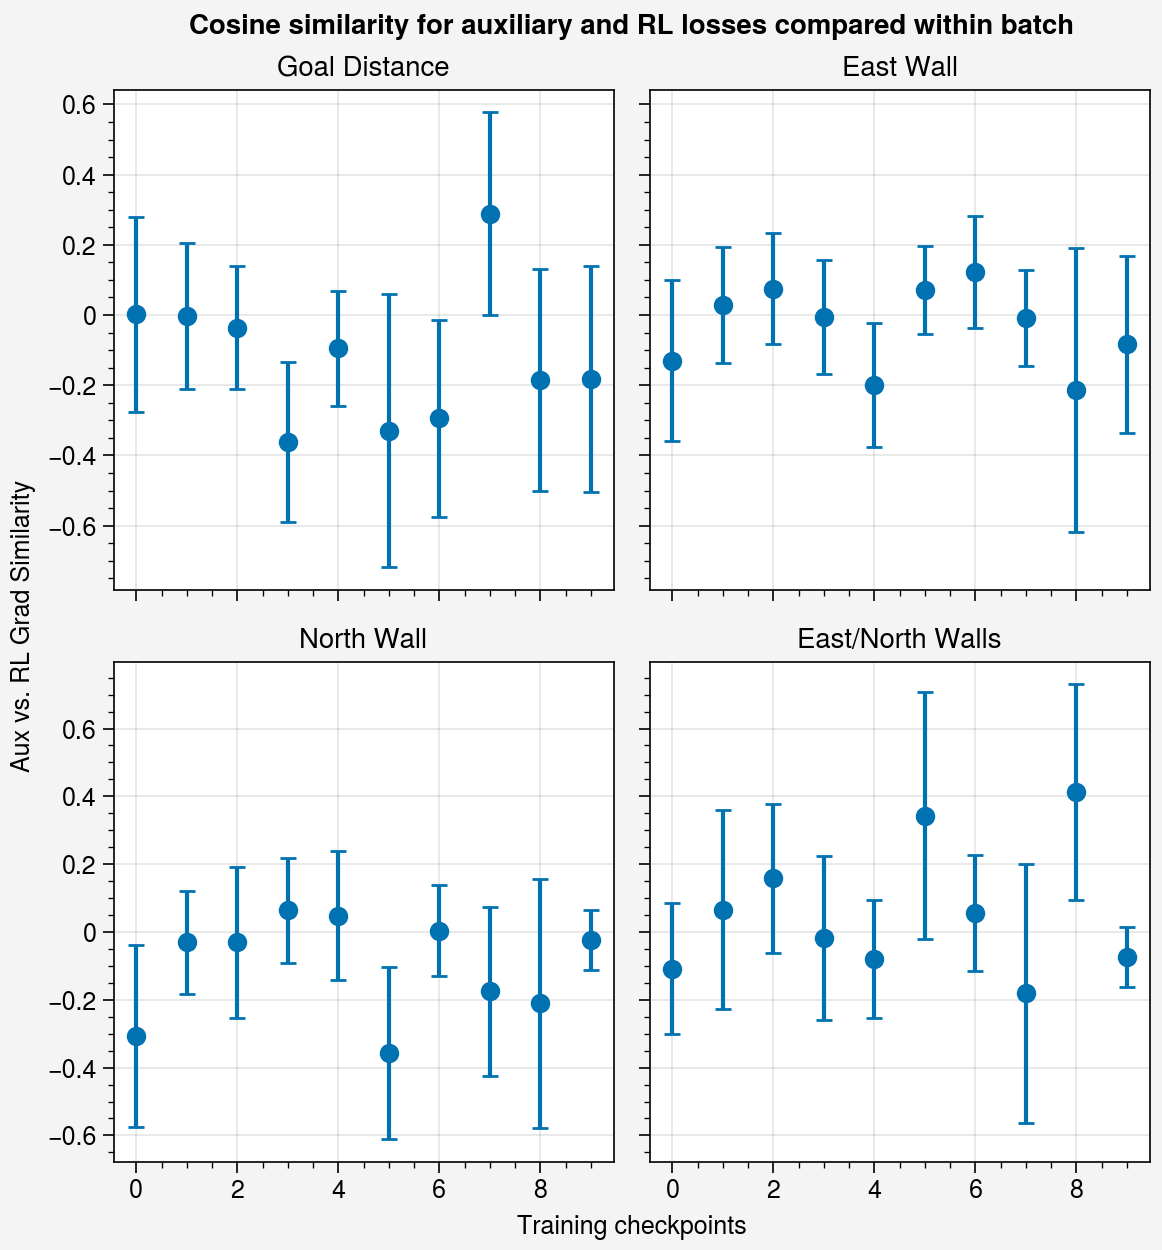

In [373]:
aux_labels = ['Goal Distance', 'East Wall', 'North Wall', 'East/North Walls']

num_layers = 16
num_batches = 20
test_layers = [0, 1, 6, 10]

colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255
actor_test_layers = [0, 1, 6, 10]

fig, ax = pplt.subplots(nrows=2, ncols=2)

for n, aux in enumerate(aux_tasks):
    xs = []
    ys = []
    stds = []
    for x in range(len(checkpoints)):
        cos_sims = []
        for i in test_layers:
            value_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['value'][i]])
            action_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['action'][i]])
            entropy_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['entropy'][i]])
            aux_grad = torch.vstack([grad.reshape(-1) for grad in all_grads[aux][x]['auxiliary'][i]])
            cumu_grad = value_grad + action_grad + entropy_grad
            
            cs = np.triu(cosine_similarity(cumu_grad, aux_grad), k=1)
            cs = cs[cs != 0]
            cos_sims += list(cs)
        xs.append(x)
        ys.append(np.mean(cos_sims))
        stds.append(np.std(cos_sims))
        # c.append(rgb_colors[n])
    
    ax[n].errorbar(xs, ys, yerr=stds, fmt='o')

ax.format(title=aux_labels, xlabel='Training checkpoints', 
          ylabel='Aux vs. RL Grad Similarity', 
          suptitle='Cosine similarity for auxiliary and RL losses compared within batch')

## Comparison of individual trials

### Do agent initialize with same sets of parameters?

* Yes, even with different auxiliary heads setup, the base layers share same params

In [433]:
checkpoint_folder = Path('../trained_models/checkpoint/nav_pdistal_batchaux')
aux = 'none'
path = checkpoint_folder/f'nav_pdistal_batch128aux{aux}_t0'
model1, obs_rms = torch.load(path/'0.pt')

list(model1.parameters())[0]

Parameter containing:
tensor([[-0.1164, -0.3418,  0.0597,  ..., -0.0692,  0.0537, -0.0904],
        [ 0.0706,  0.0189, -0.1389,  ...,  0.1261,  0.0771, -0.1293],
        [ 0.1405,  0.2557,  0.0354,  ...,  0.0605, -0.0404, -0.4059],
        ...,
        [ 0.0777, -0.3128,  0.1152,  ..., -0.0229,  0.0239, -0.1235],
        [ 0.3906, -0.0378,  0.1160,  ...,  0.4388, -0.3218,  0.0964],
        [ 0.1762,  0.0665,  0.1525,  ..., -0.2626,  0.1173,  0.0022]],
       requires_grad=True)

In [432]:
checkpoint_folder = Path('../trained_models/checkpoint/nav_pdistal_batchaux')
aux = 'wall0'
path = checkpoint_folder/f'nav_pdistal_batch128aux{aux}_t0'
model2, obs_rms = torch.load(path/'0.pt')

list(model2.parameters())[0]

Parameter containing:
tensor([[-0.1203, -0.3451,  0.0548,  ..., -0.0529,  0.0706, -0.0729],
        [ 0.0666,  0.0128, -0.1499,  ...,  0.1088,  0.0597, -0.1473],
        [ 0.1242,  0.2458,  0.0346,  ...,  0.0485, -0.0519, -0.4165],
        ...,
        [ 0.0656, -0.3227,  0.1099,  ..., -0.0149,  0.0323, -0.1150],
        [ 0.4076, -0.0233,  0.1270,  ...,  0.4353, -0.3274,  0.0893],
        [ 0.1795,  0.0544,  0.1506,  ..., -0.2717,  0.1090, -0.0053]],
       requires_grad=True)

In [441]:
checkpoint_folder = Path('../trained_models/checkpoint/nav_pdistal_batchaux')
aux = 'wall0'
path = checkpoint_folder/f'nav_pdistal_batch128aux{aux}_t0'
model1, obs_rms = torch.load(path/'0.pt')

list(model1.parameters())[0]

checkpoint_folder = Path('../trained_models/checkpoint/nav_pdistal_batchaux')
aux = 'wall1'
path = checkpoint_folder/f'nav_pdistal_batch128aux{aux}_t0'
model2, obs_rms = torch.load(path/'0.pt')

list(model2.parameters())[0]

for i in range(16):
    print(cosine_similarity(list(model1.parameters())[i].detach().numpy().reshape(1, -1),
                  list(model2.parameters())[i].detach().numpy().reshape(1, -1)))

[[0.99974406]]
[[0.9997714]]
[[0.9879605]]
[[0.9871609]]
[[0.99999875]]
[[0.99827075]]
[[0.99998367]]
[[0.9997951]]
[[0.9999989]]
[[0.9998169]]
[[0.9999783]]
[[0.9999535]]
[[0.9999994]]
[[1.]]
[[0.9999824]]
[[1.]]


### How do individual trials compare in learning performance?

#### Data Collection

Here we are collecting by trial of trained agent rather than auxiliary task

In [6]:
aux = 'wall01'
batch_size = 128 #used for loading trained models
# batch_size = 16

checkpoints = np.array([0, 10, 20, 30, 40, 50, 80, 120, 160, 200])
# checkpoints = checkpoints * 8


num_layers = 16
num_batches = 20
num_processes = 16
batch = 128 #Used for collecting rollouts and grads
num_trials = 5

all_grads = {t: [] for t in range(num_trials)}
all_rewarded = {t: [] for t in range(num_trials)}
all_rewards = {t: [] for t in range(num_trials)}
all_value_losses = {t: [] for t in range(num_trials)}
all_action_losses = {t: [] for t in range(num_trials)}
all_value_diffs = {t: [] for t in range(num_trials)}

for t in tqdm(range(num_trials)):
    kwarg_file_name = f'../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch{batch_size}aux{aux}_env'
    env_kwargs = pickle.load(open(kwarg_file_name, 'rb'))
    env = gym.make('NavEnv-v0', **env_kwargs)
    envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                        False, env_kwargs=env_kwargs)
    obs = envs.reset()
    
    path = Path(f'../trained_models/checkpoint/nav_pdistal_batchaux/nav_pdistal_batch{batch_size}aux{aux}_t{t}')

    for chk in checkpoints:
        model, obs_rms = torch.load(path/f'{chk}.pt')
        agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            take_optimizer_step=False)

        rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                                  model.recurrent_hidden_state_size, model.auxiliary_output_size)
        rollouts.obs[0].copy_(obs)

        res = collect_batches_and_grads(agent, envs, rollouts, num_batches=num_batches, 
                                        decompose_grads=True)

        all_grads[t].append(res['all_grads'])
        all_rewarded[t].append(res['rewarded'])
        all_rewards[t].append(res['rewards'])
        all_value_losses[t].append(res['value_losses'])
        all_action_losses[t].append(res['action_losses'])
        all_value_diffs[t].append(res['value_diff'])

        obs = rollouts.obs[-1]

all_results = {
    'all_grads': all_grads,
    'all_rewarded': all_rewarded,
    'all_rewards': all_rewards,
    'all_value_losses': all_value_losses,
    'all_action_losses': all_action_losses,
    'all_value_diffs': all_value_diffs
}
pickle.dump(all_results, open(f'data/grads/checkpointb{batch_size}_aux{aux}_grads', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:41<00:00, 128.27s/it]


#### Plotting

Very strangely... the cosine similarity seems to develop in the same way consistently over time? Troubling is that the auxiliary task never seems to provide much benefit, and there is certainly no consistent correlation between the cosine similarity of aux and RL gradients and learning curve

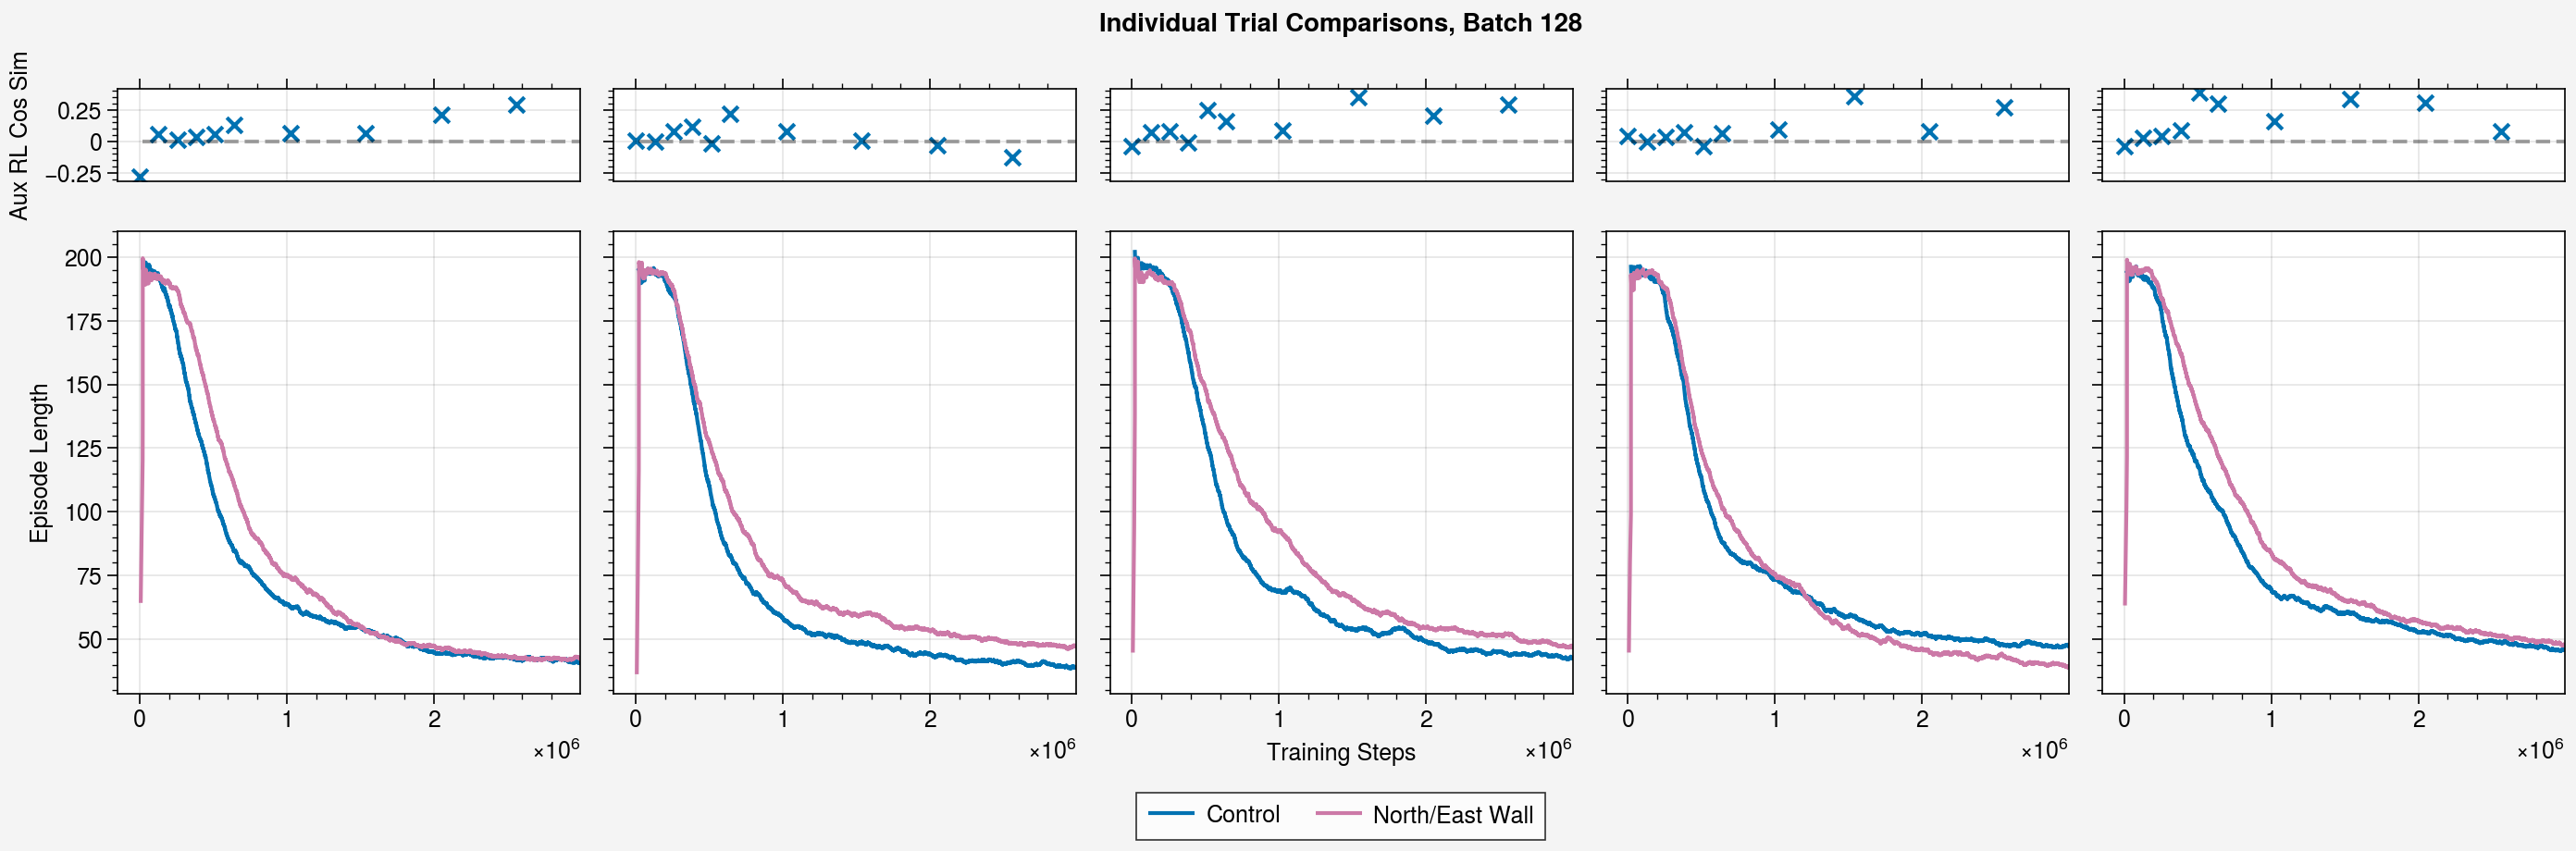

In [31]:
batch_size = 128
aux = 'wall01'

all_results = pickle.load(open(f'data/grads/checkpointb{batch_size}_aux{aux}_grads', 'rb'))
all_grads = all_results['all_grads']

checkpoints = np.array([0, 10, 20, 30, 40, 50, 80, 120, 160, 200])
chk_steps = checkpoints * 100 * batch_size

exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch_size}aux{aux}'
aux_xs, aux_ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch_size}auxnone'
ref_xs, ref_ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)

fig, ax = pplt.subplots(ncols=5)
tax = ax.panel_axes('t')

cos_sims = aux_cos_sims_from_all_grads(all_grads)

for i in range(5):
    lines = []
    
    tax[i].scatter(chk_steps, cos_sims['y'][i], marker='x')
    tax[i].plot([min_x, max_x], [0, 0], '--k', alpha=0.35)
    lines.append(ax[i].plot(ref_xs, ref_ys[i], label='Control'))
    ax[i].plot([min_x, min_x], [100, 100], alpha=0)
    ax[i].plot([min_x, min_x], [100, 100], alpha=0)
    lines.append(ax[i].plot(aux_xs, aux_ys[i], label='North/East Wall'))
    
tax.format(ylabel='Aux RL Cos Sim')
ax.format(ylabel='Episode Length', xlabel='Training Steps', 
          suptitle=f'Individual Trial Comparisons, Batch {batch_size}')

fig.legend(lines, loc='b')

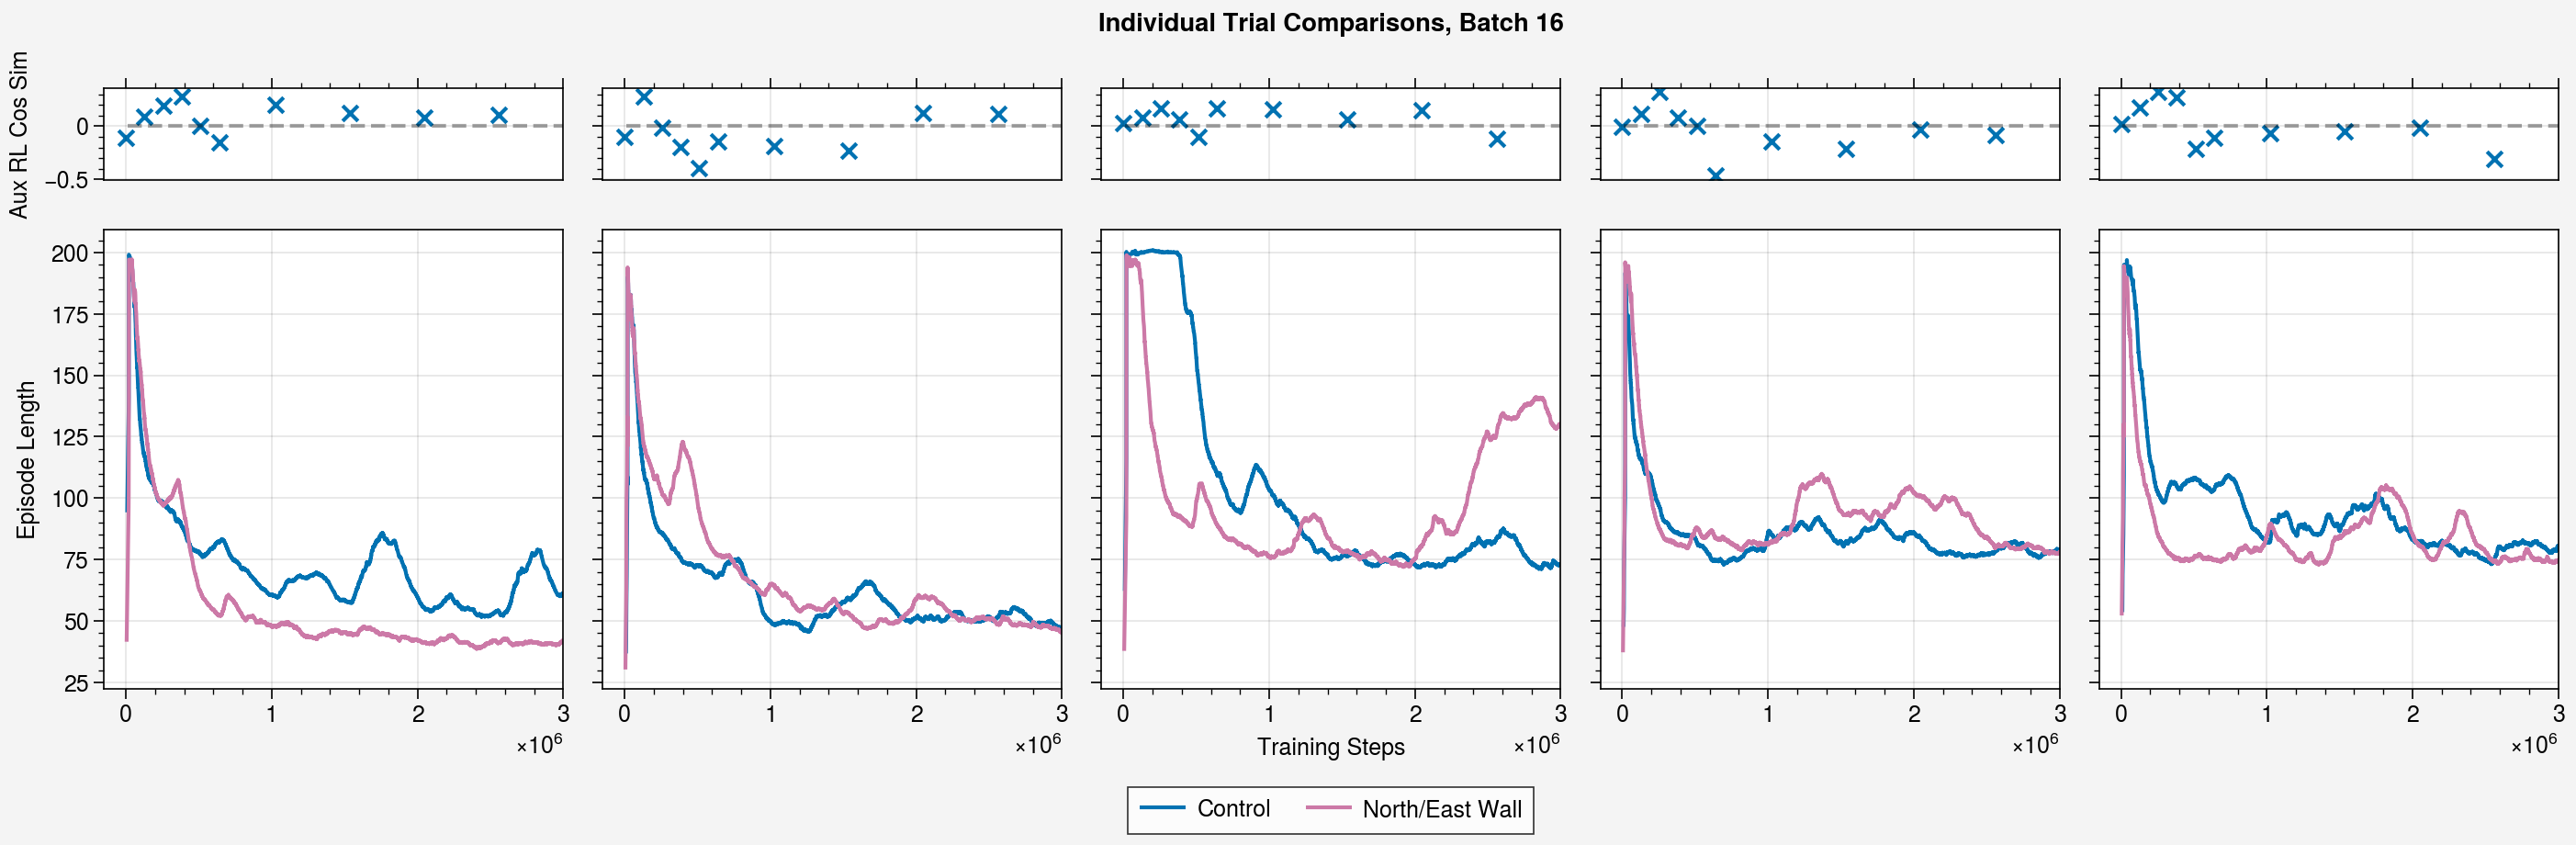

In [32]:
batch_size = 16
aux = 'wall01'

all_results = pickle.load(open(f'data/grads/checkpointb{batch_size}_aux{aux}_grads', 'rb'))
all_grads = all_results['all_grads']

checkpoints = np.array([0, 10, 20, 30, 40, 50, 80, 120, 160, 200])
chk_steps = checkpoints * 100 * batch_size * 8

exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch_size}aux{aux}'
aux_xs, aux_ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch_size}auxnone'
ref_xs, ref_ys, min_x, max_x = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)

fig, ax = pplt.subplots(ncols=5)
tax = ax.panel_axes('t')

cos_sims = aux_cos_sims_from_all_grads(all_grads)

for i in range(5):
    lines = []
    
    tax[i].scatter(chk_steps, cos_sims['y'][i], marker='x')
    tax[i].plot([min_x, max_x], [0, 0], '--k', alpha=0.35)
    lines.append(ax[i].plot(ref_xs, ref_ys[i], label='Control'))
    ax[i].plot([min_x, min_x], [100, 100], alpha=0)
    ax[i].plot([min_x, min_x], [100, 100], alpha=0)
    lines.append(ax[i].plot(aux_xs, aux_ys[i], label='North/East Wall'))
    
tax.format(ylabel='Aux RL Cos Sim')
ax.format(ylabel='Episode Length', xlabel='Training Steps',
          suptitle=f'Individual Trial Comparisons, Batch {batch_size}')

fig.legend(lines, loc='b')

# Random other testing

## Testing DecomposePPO 

In [99]:
aux_task = [3]
aux_args = [None]
aux_heads = [[-1, 0, 1]]
num_processes = 2
batch = 32

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
          'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
          'poster': 1, 'character_reset_pos': 1,
          'auxiliary_tasks': aux_task, 'auxiliary_task_args': aux_args}
env = gym.make('NavEnv-v0', **env_kwargs)
nn_base_kwargs = {'hidden_size': 16, 'auxiliary_heads': aux_heads}
envs = make_vec_envs('NavEnv-v0', 0, num_processes, 0.99, '/tmp/gym/', torch.device('cpu'),
                    False, env_kwargs=env_kwargs)
obs = envs.reset()

model = Policy(env.observation_space.shape,
               env.action_space,
               base='FlexBase',
               base_kwargs={'recurrent': True, **nn_base_kwargs})
model.to(device)
agent = DecomposeGradPPO(model, 0.5, 4, 1, 0.5, 0.01, 0.3, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                    take_optimizer_step=False)

rollouts = RolloutStorage(batch, num_processes, envs.observation_space.shape, envs.action_space,
                          model.recurrent_hidden_state_size, model.auxiliary_output_size)
rollouts.obs[0].copy_(obs)

populate_rollouts(model, envs, rollouts, batch)
next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                             rollouts.masks[-1]).detach()
rollouts.compute_returns(next_value, False, 0.99, 0.95)


In [100]:
advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (
    advantages.std() + 1e-5)

value_loss_epoch = 0
action_loss_epoch = 0
dist_entropy_epoch = 0
auxiliary_loss_epoch = 0

clipfracs = []
explained_vars = []

num_update_steps = 0

data_generator = rollouts.recurrent_generator(
    advantages, agent.num_mini_batch)

for sample in data_generator:
    num_update_steps += 1
    obs_batch, recurrent_hidden_states_batch, actions_batch, \
       value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
        adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

    # Reshape to do in a single forward pass for all steps
    values, action_log_probs, dist_entropy, _, auxiliary_preds = agent.actor_critic.evaluate_actions(
        obs_batch, recurrent_hidden_states_batch, masks_batch,
        actions_batch)

    logratio = action_log_probs - old_action_log_probs_batch 
    ratio = torch.exp(logratio)
    surr1 = ratio * adv_targ
    surr2 = torch.clamp(ratio, 1.0 - agent.clip_param,
                        1.0 + agent.clip_param) * adv_targ
    action_loss = -torch.min(surr1, surr2).mean()

    #Andy: compute approx kl
    with torch.no_grad():
        # old_approx_kl = (-logratio).mean()
        approx_kl = ((ratio - 1) - logratio).mean()
        clipfracs += [
            ((ratio - 1.0).abs() > agent.clip_param).float().mean().item()
        ]

    value_loss = 0.5 * (return_batch - values).pow(2).mean()
    auxiliary_loss = 0.5 * (auxiliary_truth_batch - auxiliary_preds).pow(2).mean()


In [141]:
agent.optimizer.zero_grad()

In [128]:
auxiliary_loss.backward(retain_graph=True)

In [134]:
action_loss.backward(retain_graph=True)

In [142]:
value_loss.backward(retain_graph=True)

## Random gradient tests

(tensor([[2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04,
         2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04, 2.1909e-04,
         1.6901e+00, 1.3903e+00, 1.1011e+00, 8.6489e-01, 6.6586e-01, 5.2740e-01,
         4.2061e-01, 3.1348e-01, 3.3307e-01, 3.8926e-01, 4.8463e-01, 5.7624e-01]]), tensor([[5.3419]]), array([ True]), [{'auxiliary': array([], dtype=float64), 'episode': {'r': 1.0, 'l': 20, 't': 115.543484}, 'terminal_observation': array([ 2.1543466e-04,  2.1543466e-04,  2.1543466e-04,  2.1543466e-04,
        2.1543466e-04,  2.1543466e-04,  2.1543466e-04,  2.1543466e-04,
        2.1543466e-04,  2.1543466e-04,  2.1543466e-04,  2.1543466e-04,
       -1.2720786e+00, -1.2388921e+00, -1.1798737e+00, -1.1216507e+00,
       -1.3269703e+00, -1.4293290e+00, -1.4989356e+00, -1.5302937e+00,
       -1.6056600e+00, -1.5726438e+00, -1.5203936e+00, -1.4665300e+00],
      dtype=float32)}])


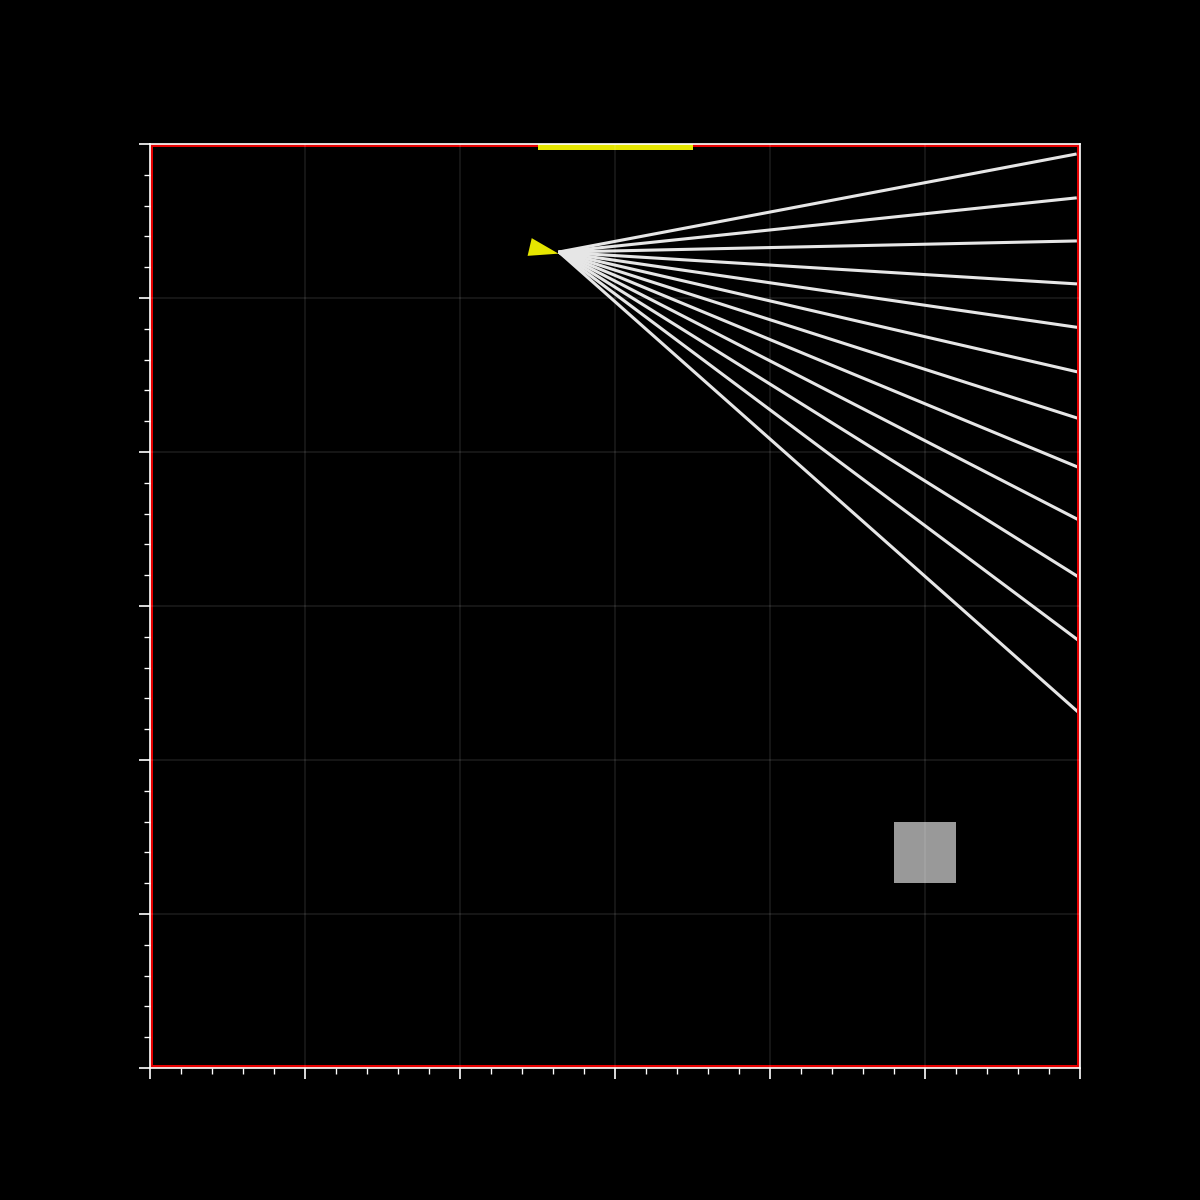

In [211]:
print(envs.step(torch.tensor([[1]])))
envs.get_attr('render')[0]('human')


In [89]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))
nn_base_kwargs = {'hidden_size': 16}

# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
batch_sizes = [8, 32, 128]
# batch_sizes = [256]

total_steps = 256*4
grads = {batch: [] for batch in batch_sizes}
rewards = {batch: [] for batch in batch_sizes}

for batch in batch_sizes:
    agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, nn_base_kwargs=nn_base_kwargs,
                                    num_steps=batch, num_processes=8, ppo_epoch=1, num_mini_batch=1)
    
    params = list(agent.actor_critic.parameters())
    num_updates = total_steps // batch
    for i in tqdm(range(num_updates)):
        populate_rollouts(agent.actor_critic, envs, rollouts, batch)
        rewards[batch].append(torch.sum(rollouts.rewards).item())
        # update_model(agent, rollouts)
        # grads[batch].append([param.grad.clone() for param in params])
        
        
        

 91%|████████████████████████████████████████████████████████████████████████▌       | 116/128 [00:02<00:00, 55.90it/s]


KeyboardInterrupt: 

<a list of 1 Line2D objects>

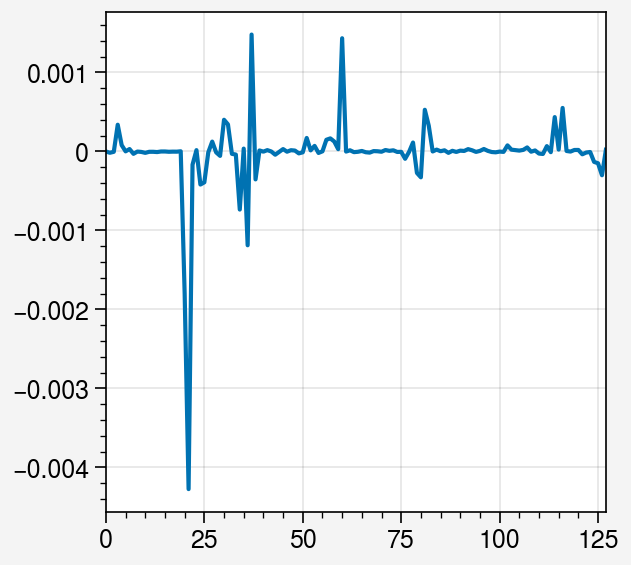

In [98]:
fig, ax = pplt.subplots()
ax.plot([grads[8][i][0][0, 0].item() for i in range(len(grads[8]))])

In [109]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

In [133]:
grad_flatten = [grads[8][i][0].numpy().reshape(1, -1) for i in range(len(grads[8]))]


In [139]:
sims = []
for i in range(1000):
    norm1 = np.random.normal(size=(1, grad_flatten[0].shape[1]))
    norm2 = np.random.normal(size=(1, grad_flatten[0].shape[1]))
    sims.append(cosine_similarity(norm1, norm2)[0, 0])
plt.hist(sims)

(array([ 4.,  8., 18., 15., 24., 23., 10.,  9., 11.,  5.]),
 array([-0.8775398 , -0.6958389 , -0.514138  , -0.3324371 , -0.15073618,
         0.03096473,  0.21266565,  0.39436656,  0.57606745,  0.7577684 ,
         0.9394693 ], dtype=float32),
 <BarContainer object of 10 artists>)

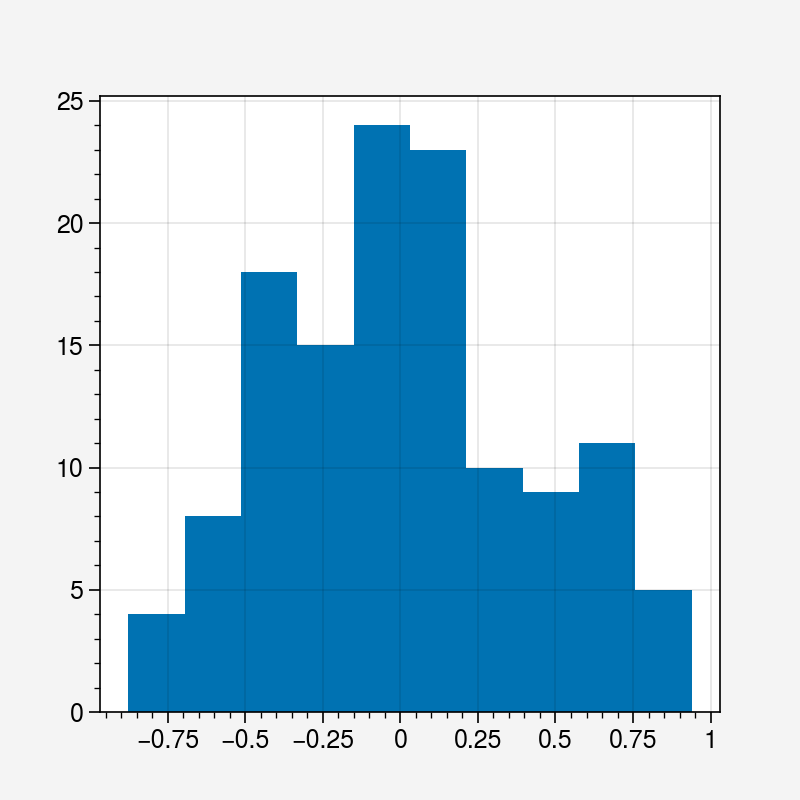

In [142]:
sims = []
for i in range(len(grad_flatten)-1):
    sims.append(cosine_similarity(grad_flatten[i], grad_flatten[i+1])[0,0])
plt.hist(sims)

<a list of 1 Line2D objects>

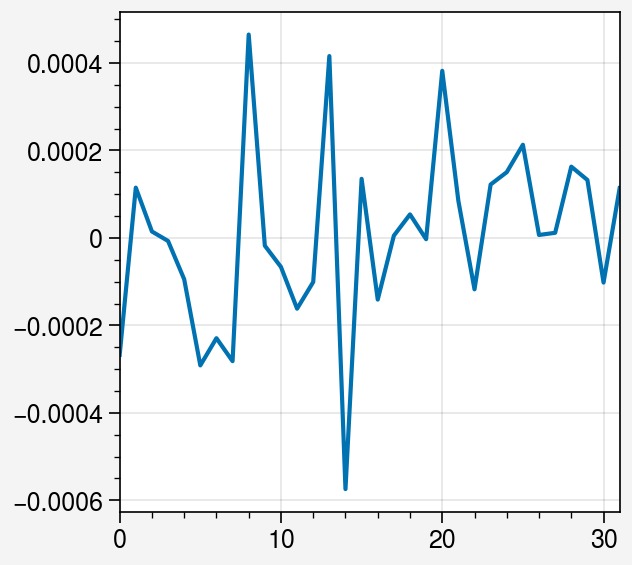

In [99]:
fig, ax = pplt.subplots()
batch = 32
ax.plot([grads[batch][i][0][0, 0].item() for i in range(len(grads[batch]))])

<a list of 1 Line2D objects>

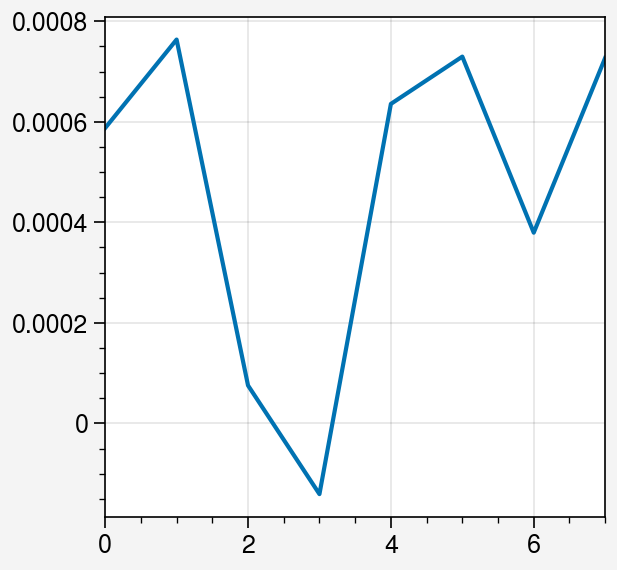

In [101]:
fig, ax = pplt.subplots()
batch = 128
ax.plot([grads[batch][i][0][0, 0].item() for i in range(len(grads[batch]))])

In [70]:
update_model(agent, rollouts, after_update=False)

(0.16650226712226868,
 -7.450580596923828e-09,
 1.3862899541854858,
 tensor(0.),
 [0.0],
 0.0)

In [81]:
agent.optimizer.zero_grad()

In [76]:
params = list(agent.actor_critic.parameters())

In [82]:
params[0].grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [83]:
params[0].grad.clone()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])